Exploratory analysis of releasing particles near a topographic boundary

To characterize the interaction of the flow with a complex topography like a coral reef, I am going to release particles near the boundary and track them forwards and backwards in time. This notebook is designed to outline a structure for the study.
First let's import the necessary modules

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "\\Users\\Gebruiker\\Documents\\GitHub\\parcels\\")

from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4_3D, ErrorCode, plotTrajectoriesFile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from datetime import timedelta
import cmocean
from netCDF4 import Dataset,num2date,date2num
from explfunctions import deleteparticle, removeNaNs, DistParticle, FinalDistance

Now we are going to obtain flowfields in netcdf form. Because the general 2D structure in Parcels expects lon-lat, while these flowfield are 1D and depth, we are going to transform the data, add a dimension and use from_data to read in the 3D flow fields. This also sets up further research in 3D. Here we decide which flow we are going to analyse and whether to do it forwards or backwards in time

In [2]:
filename = 'output-corals-regridded-parabolic-wave'
fb = 'backward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
corald = Dataset(filename+'.nc','r+') # read netcdf file
T = corald.variables['T'][:]
X = corald.variables['X'][:]
Y = corald.variables['Y'][:]
U = corald.variables['U'][:]
V = corald.variables['V'][:]
corald.close()

Here the variables are going to be changed to fit parcels

In [3]:
U = np.asarray(U)
U = np.expand_dims(U,2) # add a third dimension

V = np.asarray(V)
V = np.expand_dims(V,2) # add a third dimension

t = num2date(T,units='seconds since 2000-01-01 00:00:00.0') # make t a datetime object
t = date2num(t,units='seconds since 2000-01-01 00:00:00.0')

times = t
xs = X
ys = np.asarray([-1,0,1]) # third dimension with length 3. 2D flow field will be inserted on the middle value to ensure the AdvectionRK4_3D works correctly
depths = -Y # Y was height, but parcels expects depth

u = np.zeros(U.shape)
u = np.concatenate((u,u,u),axis=2) # add the third dimension
u[:,:,1,:] = U[:,:,0,:] # add the data to the middle value of the third dimension
v = np.zeros(u.shape)
w = np.zeros(U.shape)
w = np.concatenate((w,w,w),axis=2)
w[:,:,1,:] = -V[:,:,0,:]

Now we are going to read the data into a parcels fieldset using FieldSet.from_data.

In [6]:
data = {'U': u,
        'V': v,
        'W': w}
dimensions = {'lon':xs,
              'lat':ys,
              'depth':depths,
              'time':times}
fieldset = FieldSet.from_data(data=data, dimensions= dimensions, mesh='flat')

Now that the data are read into a fieldset object, we want to define the attributes of the particles we are going to release as a particleset object. In this experiment, we want to release particles at all gridpoints in the model, except for the ones where coral geometrical objects are in the flow. Also, we want to define for how long the particles are advected, which timestep to use and what output to obtain.

In [7]:
lons, ds = np.meshgrid(xs,depths)                        # meshgrid at all gridpoints in the flow data
um = np.ma.masked_invalid(u[0,:,1,:])                    # retrieve mask from flowfield to take out points over coral objects

lons = np.ma.masked_array(lons,mask=um.mask)             # mask points in meshgrid
lons = lons.flatten()
ds = np.ma.masked_array(ds,mask=um.mask)                 # mask points in meshgrid
ds = ds.flatten()

outputdt = timedelta(seconds=0.1)                        # timesteps to create output at
dt=timedelta(seconds=0.01)                               # timesteps to calculate particle trajectories
runtime=timedelta(seconds=44)                            # total time to execute the particleset
lats = np.asarray([0]*len(lons))                         # all particles must start and stay on the middle value of the extra dimension
inittime = np.asarray([0]*len(lons))                     # default time to start the particles is zero
if fb == 'backward':                                     # change timestep and start time when in 'backward' mode
    dt = dt*-1
    inittime = np.asarray([runtime.seconds]*len(lons))

In [8]:
pset = ParticleSet(fieldset=fieldset, pclass=DistParticle, lon=lons, lat=lats, depth=ds,time=inittime)
n_part = pset.size

The masked values at the coral objects are seen by parcels as zero, so we are going to remove these trajectories. If we do not do this we are calculating many more trajectories which all start at the same time at lon = 0 and depth = 0. The function that does this is removeNaNs in the explfunctions file.

In [9]:
k_removeNaNs = pset.Kernel(removeNaNs)
pset.execute(k_removeNaNs, runtime = timedelta(seconds=0))

INFO: Compiled DistParticleremoveNaNs ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\dea8d2e1908ce1c1762fe0c2e207b7d7_0.dll


Aside from the trajectories, we would like to find out which particles are beached, i.e. find themselves on the coral where there are no velocities to advect them. To look at this through time, we have written the function FinalDistance, which saves the distance moved in the last timestep at each output time. If this is zero, we assume the particle to be stuck. The output file is named based on the input file, whether the run is forward or backward in time and the runtime.

In [10]:
k_dist = pset.Kernel(FinalDistance)  # Casting the FinalDistance function to a kernel.

pset.execute(AdvectionRK4_3D+k_dist,
             runtime=runtime,
             dt=dt,
             recovery = {ErrorCode.ErrorOutOfBounds:deleteparticle},
             output_file=pset.ParticleFile(name=filename+fb+str(runtime.seconds), outputdt=outputdt)
            )

INFO: Compiled DistParticleAdvectionRK4_3DFinalDistance ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\1206796b2b3b295d1beceb6fa39c348a_0.dll


Particle 0 has died at t = 44.0 at lon, lat, depth = -0.5, 1.0, -0.49
Particle 1 has died at t = 43.99000000022352 at lon, lat, depth = -0.5, 1.0, -0.49
Particle 2 has died at t = 43.980000000447035 at lon, lat, depth = -0.49999982, 1.0, -0.49
Particle 3 has died at t = 43.97000000067055 at lon, lat, depth = -0.49994856, 1.0, -0.49
Particle 4 has died at t = 43.96000000089407 at lon, lat, depth = -0.49984658, 1.0, -0.49
Particle 5 has died at t = 43.95000000111759 at lon, lat, depth = -0.49974436, 1.0, -0.49
Particle 6 has died at t = 43.940000001341105 at lon, lat, depth = -0.49964133, 1.0, -0.49
Particle 7 has died at t = 43.93000000156462 at lon, lat, depth = -0.49953723, 1.0, -0.49
Particle 8 has died at t = 43.92000000178814 at lon, lat, depth = -0.49938047, 1.0, -0.49
Particle 9 has died at t = 43.91000000201166 at lon, lat, depth = -0.49917123, 1.0, -0.49
Particle 417 has died at t = 44.0 at lon, lat, depth = 3.67, 1.0, -0.49
Particle 418 has died at t = 44.0 at lon, lat, depth 

Particle 10 has died at t = 43.900000002235174 at lon, lat, depth = -0.49896088, 1.0, -0.49
Particle 11 has died at t = 43.89000000245869 at lon, lat, depth = -0.4987495, 1.0, -0.49
Particle 12 has died at t = 43.88000000268221 at lon, lat, depth = -0.49848422, 1.0, -0.49
Particle 13 has died at t = 43.870000002905726 at lon, lat, depth = -0.4981655, 1.0, -0.49
Particle 14 has died at t = 43.860000003129244 at lon, lat, depth = -0.49784574, 1.0, -0.49
Particle 15 has died at t = 43.85000000335276 at lon, lat, depth = -0.49752456, 1.0, -0.49
Particle 16 has died at t = 43.84000000357628 at lon, lat, depth = -0.4972015, 1.0, -0.49
Particle 17 has died at t = 43.830000003799796 at lon, lat, depth = -0.49682227, 1.0, -0.49
Particle 18 has died at t = 43.82000000402331 at lon, lat, depth = -0.49638823, 1.0, -0.49
Particle 19 has died at t = 43.81000000424683 at lon, lat, depth = -0.49595225, 1.0, -0.49
Particle 445 has died at t = 43.900000002235174 at lon, lat, depth = 3.839807, 1.0, -0.49

Particle 20 has died at t = 43.80000000447035 at lon, lat, depth = -0.49551386, 1.0, -0.49
Particle 21 has died at t = 43.790000004693866 at lon, lat, depth = -0.4950731, 1.0, -0.49
Particle 22 has died at t = 43.78000000491738 at lon, lat, depth = -0.49457347, 1.0, -0.49
Particle 23 has died at t = 43.7700000051409 at lon, lat, depth = -0.4940164, 1.0, -0.49
Particle 24 has died at t = 43.76000000536442 at lon, lat, depth = -0.4934568, 1.0, -0.49
Particle 25 has died at t = 43.750000005587935 at lon, lat, depth = -0.4928955, 1.0, -0.49
Particle 26 has died at t = 43.74000000581145 at lon, lat, depth = -0.49227452, 1.0, -0.49
Particle 27 has died at t = 43.73000000603497 at lon, lat, depth = -0.49159384, 1.0, -0.49
Particle 28 has died at t = 43.72000000625849 at lon, lat, depth = -0.49091262, 1.0, -0.49
Particle 29 has died at t = 43.710000006482005 at lon, lat, depth = -0.49022806, 1.0, -0.49
Particle 456 has died at t = 43.80000000447035 at lon, lat, depth = 3.8395476, 1.0, -0.49000

INFO: Temporary output files are stored in out-MTEVTDKE.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MTEVTDKE" to convert these to a NetCDF file during the run.
N/A% (0 of 44.0) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


Particle 30 has died at t = 43.69000000692904 at lon, lat, depth = -0.49953762, 1.0, -0.49
Particle 31 has died at t = 43.68000000715256 at lon, lat, depth = -0.49878597, 1.0, -0.49
Particle 32 has died at t = 43.670000007376075 at lon, lat, depth = -0.49797538, 1.0, -0.49
Particle 33 has died at t = 43.66000000759959 at lon, lat, depth = -0.49715886, 1.0, -0.49
Particle 34 has died at t = 43.65000000782311 at lon, lat, depth = -0.49633953, 1.0, -0.49
Particle 35 has died at t = 43.64000000804663 at lon, lat, depth = -0.4954586, 1.0, -0.49
Particle 36 has died at t = 43.630000008270144 at lon, lat, depth = -0.49451593, 1.0, -0.49
Particle 37 has died at t = 43.62000000849366 at lon, lat, depth = -0.49356434, 1.0, -0.49
Particle 38 has died at t = 43.61000000871718 at lon, lat, depth = -0.49261218, 1.0, -0.49
Particle 467 has died at t = 43.70000000670552 at lon, lat, depth = 3.836401, 1.0, -0.49000186
Particle 468 has died at t = 43.69000000692904 at lon, lat, depth = 3.8348389, 1.0, -

  0% (0.4000000000000057 of 44.0) |      | Elapsed Time: 0:00:04 ETA:   0:07:18


Particle 39 has died at t = 43.6000000089407 at lon, lat, depth = -0.49165428, 1.0, -0.49
Particle 40 has died at t = 43.590000009164214 at lon, lat, depth = -0.4906302, 1.0, -0.49
Particle 41 has died at t = 43.57000000961125 at lon, lat, depth = -0.4995428, 1.0, -0.49
Particle 42 has died at t = 43.560000009834766 at lon, lat, depth = -0.49845093, 1.0, -0.49
Particle 43 has died at t = 43.550000010058284 at lon, lat, depth = -0.49735615, 1.0, -0.49
Particle 44 has died at t = 43.5400000102818 at lon, lat, depth = -0.4961916, 1.0, -0.49
Particle 45 has died at t = 43.53000001050532 at lon, lat, depth = -0.49495897, 1.0, -0.49
Particle 46 has died at t = 43.520000010728836 at lon, lat, depth = -0.49372593, 1.0, -0.49
Particle 47 has died at t = 43.51000001095235 at lon, lat, depth = -0.49248418, 1.0, -0.49
Particle 479 has died at t = 43.6000000089407 at lon, lat, depth = 3.8382945, 1.0, -0.4899798
Particle 480 has died at t = 43.590000009164214 at lon, lat, depth = 3.8361602, 1.0, -0.

  1% (0.5000000000000071 of 44.0) |      | Elapsed Time: 0:00:07 ETA:   0:28:19


Particle 48 has died at t = 43.50000001117587 at lon, lat, depth = -0.4911717, 1.0, -0.49
Particle 49 has died at t = 43.480000011622906 at lon, lat, depth = -0.49979255, 1.0, -0.49
Particle 50 has died at t = 43.47000001184642 at lon, lat, depth = -0.4984113, 1.0, -0.49
Particle 51 has died at t = 43.46000001206994 at lon, lat, depth = -0.49702606, 1.0, -0.49
Particle 52 has died at t = 43.45000001229346 at lon, lat, depth = -0.4956257, 1.0, -0.49
Particle 53 has died at t = 43.440000012516975 at lon, lat, depth = -0.4941547, 1.0, -0.49
Particle 54 has died at t = 43.43000001274049 at lon, lat, depth = -0.492623, 1.0, -0.49
Particle 55 has died at t = 43.42000001296401 at lon, lat, depth = -0.49108464, 1.0, -0.49
Particle 489 has died at t = 43.50000001117587 at lon, lat, depth = 3.8147712, 1.0, -0.48997113
Particle 490 has died at t = 43.49000001139939 at lon, lat, depth = 3.8121214, 1.0, -0.4899786
Particle 491 has died at t = 43.480000011622906 at lon, lat, depth = 3.8094137, 1.0, 

  1% (0.6000000000000085 of 44.0) |      | Elapsed Time: 0:00:11 ETA:   0:28:10


Particle 56 has died at t = 43.400000013411045 at lon, lat, depth = -0.499531, 1.0, -0.49
Particle 57 has died at t = 43.39000001363456 at lon, lat, depth = -0.49790394, 1.0, -0.49
Particle 58 has died at t = 43.38000001385808 at lon, lat, depth = -0.49621847, 1.0, -0.49
Particle 59 has died at t = 43.3700000140816 at lon, lat, depth = -0.49451852, 1.0, -0.49
Particle 60 has died at t = 43.360000014305115 at lon, lat, depth = -0.49280298, 1.0, -0.49
Particle 61 has died at t = 43.35000001452863 at lon, lat, depth = -0.49102363, 1.0, -0.49
Particle 62 has died at t = 43.33000001497567 at lon, lat, depth = -0.4991738, 1.0, -0.49
Particle 63 has died at t = 43.320000015199184 at lon, lat, depth = -0.49730545, 1.0, -0.49
Particle 64 has died at t = 43.3100000154227 at lon, lat, depth = -0.49543542, 1.0, -0.49
Particle 499 has died at t = 43.400000013411045 at lon, lat, depth = 3.785746, 1.0, -0.48997653
Particle 500 has died at t = 43.39000001363456 at lon, lat, depth = 3.782533, 1.0, -0.4

  1% (0.70000000000001 of 44.0) |        | Elapsed Time: 0:00:15 ETA:   0:27:51


Particle 65 has died at t = 43.30000001564622 at lon, lat, depth = -0.49348944, 1.0, -0.49
Particle 66 has died at t = 43.29000001586974 at lon, lat, depth = -0.491466, 1.0, -0.49
Particle 67 has died at t = 43.27000001631677 at lon, lat, depth = -0.4994454, 1.0, -0.49
Particle 68 has died at t = 43.26000001654029 at lon, lat, depth = -0.49739894, 1.0, -0.49
Particle 69 has died at t = 43.250000016763806 at lon, lat, depth = -0.49535668, 1.0, -0.49
Particle 70 has died at t = 43.240000016987324 at lon, lat, depth = -0.49323285, 1.0, -0.49
Particle 71 has died at t = 43.23000001721084 at lon, lat, depth = -0.49103114, 1.0, -0.49
Particle 72 has died at t = 43.210000017657876 at lon, lat, depth = -0.49882892, 1.0, -0.49
Particle 507 has died at t = 43.30000001564622 at lon, lat, depth = 3.7335396, 1.0, -0.48999718
Particle 508 has died at t = 43.29000001586974 at lon, lat, depth = 3.7298794, 1.0, -0.48999023
Particle 509 has died at t = 43.27000001631677 at lon, lat, depth = 3.713497, 1.

  1% (0.8000000000000114 of 44.0) |      | Elapsed Time: 0:00:19 ETA:   0:27:23


Particle 73 has died at t = 43.20000001788139 at lon, lat, depth = -0.49659917, 1.0, -0.49
Particle 74 has died at t = 43.19000001810491 at lon, lat, depth = -0.4943074, 1.0, -0.49
Particle 75 has died at t = 43.18000001832843 at lon, lat, depth = -0.4919283, 1.0, -0.49
Particle 76 has died at t = 43.16000001877546 at lon, lat, depth = -0.49954104, 1.0, -0.49
Particle 77 has died at t = 43.15000001899898 at lon, lat, depth = -0.49714574, 1.0, -0.49
Particle 78 has died at t = 43.1400000192225 at lon, lat, depth = -0.4946631, 1.0, -0.49
Particle 79 has died at t = 43.130000019446015 at lon, lat, depth = -0.49211308, 1.0, -0.49
Particle 80 has died at t = 43.11000001989305 at lon, lat, depth = -0.4995434, 1.0, -0.49
Particle 973 has died at t = 43.20000001788139 at lon, lat, depth = -0.49659917, 1.0, -0.48261672
Particle 974 has died at t = 43.19000001810491 at lon, lat, depth = -0.4943074, 1.0, -0.48265946
Particle 975 has died at t = 43.18000001832843 at lon, lat, depth = -0.4919283, 1

  2% (0.9000000000000128 of 44.0) |      | Elapsed Time: 0:00:23 ETA:   0:27:50


Particle 81 has died at t = 43.10000002011657 at lon, lat, depth = -0.49696702, 1.0, -0.49
Particle 82 has died at t = 43.090000020340085 at lon, lat, depth = -0.49438053, 1.0, -0.49
Particle 83 has died at t = 43.0800000205636 at lon, lat, depth = -0.49171725, 1.0, -0.49
Particle 84 has died at t = 43.06000002101064 at lon, lat, depth = -0.49897304, 1.0, -0.49
Particle 85 has died at t = 43.050000021234155 at lon, lat, depth = -0.4962009, 1.0, -0.49
Particle 86 has died at t = 43.04000002145767 at lon, lat, depth = -0.49342868, 1.0, -0.49
Particle 87 has died at t = 43.03000002168119 at lon, lat, depth = -0.4905753, 1.0, -0.49
Particle 88 has died at t = 43.010000022128224 at lon, lat, depth = -0.4976473, 1.0, -0.49
Particle 981 has died at t = 43.10000002011657 at lon, lat, depth = -0.49696702, 1.0, -0.48306304
Particle 982 has died at t = 43.090000020340085 at lon, lat, depth = -0.49438053, 1.0, -0.4831012
Particle 983 has died at t = 43.0800000205636 at lon, lat, depth = -0.4917172

  2% (1.0000000000000142 of 44.0) |      | Elapsed Time: 0:00:27 ETA:   0:30:07


Particle 89 has died at t = 43.00000002235174 at lon, lat, depth = -0.49467725, 1.0, -0.49
Particle 90 has died at t = 42.99000002257526 at lon, lat, depth = -0.4917247, 1.0, -0.49
Particle 91 has died at t = 42.970000023022294 at lon, lat, depth = -0.49876145, 1.0, -0.49
Particle 92 has died at t = 42.96000002324581 at lon, lat, depth = -0.49572247, 1.0, -0.49
Particle 93 has died at t = 42.95000002346933 at lon, lat, depth = -0.49255583, 1.0, -0.49
Particle 94 has died at t = 42.930000023916364 at lon, lat, depth = -0.4994141, 1.0, -0.49
Particle 95 has died at t = 42.92000002413988 at lon, lat, depth = -0.49627817, 1.0, -0.49
Particle 96 has died at t = 42.9100000243634 at lon, lat, depth = -0.49312687, 1.0, -0.49
Particle 989 has died at t = 43.00000002235174 at lon, lat, depth = -0.49467725, 1.0, -0.48347825
Particle 990 has died at t = 42.99000002257526 at lon, lat, depth = -0.4917247, 1.0, -0.48351154
Particle 991 has died at t = 42.970000023022294 at lon, lat, depth = -0.498761

  2% (1.1000000000000156 of 44.0) |      | Elapsed Time: 0:00:31 ETA:   0:26:50


Particle 97 has died at t = 42.89000002481043 at lon, lat, depth = -0.49986207, 1.0, -0.49
Particle 98 has died at t = 42.88000002503395 at lon, lat, depth = -0.49654648, 1.0, -0.49
Particle 99 has died at t = 42.87000002525747 at lon, lat, depth = -0.49322742, 1.0, -0.49
Particle 100 has died at t = 42.8500000257045 at lon, lat, depth = -0.49986655, 1.0, -0.49
Particle 101 has died at t = 42.84000002592802 at lon, lat, depth = -0.49653897, 1.0, -0.49
Particle 102 has died at t = 42.83000002615154 at lon, lat, depth = -0.49313188, 1.0, -0.49
Particle 103 has died at t = 42.81000002659857 at lon, lat, depth = -0.4996104, 1.0, -0.49
Particle 997 has died at t = 42.89000002481043 at lon, lat, depth = -0.49986207, 1.0, -0.48385537
Particle 998 has died at t = 42.88000002503395 at lon, lat, depth = -0.49654648, 1.0, -0.48386997
Particle 999 has died at t = 42.87000002525747 at lon, lat, depth = -0.49322742, 1.0, -0.48388332
Particle 1000 has died at t = 42.8500000257045 at lon, lat, depth =

  2% (1.200000000000017 of 44.0) |       | Elapsed Time: 0:00:34 ETA:   0:26:02


Particle 104 has died at t = 42.80000002682209 at lon, lat, depth = -0.4961035, 1.0, -0.49
Particle 105 has died at t = 42.79000002704561 at lon, lat, depth = -0.49260798, 1.0, -0.49
Particle 106 has died at t = 42.77000002749264 at lon, lat, depth = -0.4991066, 1.0, -0.49
Particle 107 has died at t = 42.76000002771616 at lon, lat, depth = -0.49550614, 1.0, -0.49
Particle 108 has died at t = 42.75000002793968 at lon, lat, depth = -0.49184665, 1.0, -0.49
Particle 109 has died at t = 42.73000002838671 at lon, lat, depth = -0.49818125, 1.0, -0.49
Particle 110 has died at t = 42.72000002861023 at lon, lat, depth = -0.4945099, 1.0, -0.49
Particle 111 has died at t = 42.71000002883375 at lon, lat, depth = -0.49087468, 1.0, -0.49
Particle 1004 has died at t = 42.80000002682209 at lon, lat, depth = -0.49610355, 1.0, -0.48401904
Particle 1005 has died at t = 42.79000002704561 at lon, lat, depth = -0.49260882, 1.0, -0.48402128
Particle 1006 has died at t = 42.77000002749264 at lon, lat, depth = 

  2% (1.3000000000000185 of 44.0) |      | Elapsed Time: 0:00:38 ETA:   0:26:31


Particle 112 has died at t = 42.69000002928078 at lon, lat, depth = -0.49712142, 1.0, -0.49
Particle 113 has died at t = 42.6800000295043 at lon, lat, depth = -0.4933027, 1.0, -0.49
Particle 114 has died at t = 42.660000029951334 at lon, lat, depth = -0.49950346, 1.0, -0.49
Particle 115 has died at t = 42.65000003017485 at lon, lat, depth = -0.49568254, 1.0, -0.49
Particle 116 has died at t = 42.64000003039837 at lon, lat, depth = -0.49188855, 1.0, -0.49
Particle 117 has died at t = 42.620000030845404 at lon, lat, depth = -0.49814138, 1.0, -0.49
Particle 118 has died at t = 42.61000003106892 at lon, lat, depth = -0.4942651, 1.0, -0.49
Particle 1012 has died at t = 42.69000002928078 at lon, lat, depth = -0.49713334, 1.0, -0.48410264
Particle 1013 has died at t = 42.6800000295043 at lon, lat, depth = -0.4933168, 1.0, -0.48408732
Particle 1014 has died at t = 42.660000029951334 at lon, lat, depth = -0.49951994, 1.0, -0.48410732
Particle 1015 has died at t = 42.65000003017485 at lon, lat, 

  3% (1.40000000000002 of 44.0) |        | Elapsed Time: 0:00:42 ETA:   0:25:31


Particle 119 has died at t = 42.60000003129244 at lon, lat, depth = -0.49031395, 1.0, -0.49
Particle 120 has died at t = 42.58000003173947 at lon, lat, depth = -0.49639887, 1.0, -0.49
Particle 121 has died at t = 42.57000003196299 at lon, lat, depth = -0.4924949, 1.0, -0.49
Particle 122 has died at t = 42.550000032410026 at lon, lat, depth = -0.4986039, 1.0, -0.49
Particle 123 has died at t = 42.54000003263354 at lon, lat, depth = -0.49471268, 1.0, -0.49
Particle 124 has died at t = 42.53000003285706 at lon, lat, depth = -0.4907652, 1.0, -0.49
Particle 125 has died at t = 42.510000033304095 at lon, lat, depth = -0.49672002, 1.0, -0.49
Particle 1019 has died at t = 42.60000003129244 at lon, lat, depth = -0.49034128, 1.0, -0.48402563
Particle 1020 has died at t = 42.58000003173947 at lon, lat, depth = -0.4964283, 1.0, -0.48403195
Particle 1021 has died at t = 42.57000003196299 at lon, lat, depth = -0.4925265, 1.0, -0.4840006
Particle 1022 has died at t = 42.550000032410026 at lon, lat, d

  3% (1.5000000000000213 of 44.0) |      | Elapsed Time: 0:00:45 ETA:   0:24:25


Particle 126 has died at t = 42.50000003352761 at lon, lat, depth = -0.49270433, 1.0, -0.49
Particle 127 has died at t = 42.48000003397465 at lon, lat, depth = -0.49872795, 1.0, -0.49
Particle 128 has died at t = 42.470000034198165 at lon, lat, depth = -0.49474525, 1.0, -0.49
Particle 129 has died at t = 42.46000003442168 at lon, lat, depth = -0.49080637, 1.0, -0.49
Particle 130 has died at t = 42.44000003486872 at lon, lat, depth = -0.49686766, 1.0, -0.49
Particle 131 has died at t = 42.430000035092235 at lon, lat, depth = -0.4928625, 1.0, -0.49
Particle 132 has died at t = 42.41000003553927 at lon, lat, depth = -0.4987966, 1.0, -0.49
Particle 1026 has died at t = 42.50000003352761 at lon, lat, depth = -0.49274722, 1.0, -0.48386788
Particle 1027 has died at t = 42.48000003397465 at lon, lat, depth = -0.4987731, 1.0, -0.48384866
Particle 1028 has died at t = 42.470000034198165 at lon, lat, depth = -0.4947932, 1.0, -0.48379976
Particle 1029 has died at t = 42.46000003442168 at lon, lat,

  3% (1.6000000000000227 of 44.0) |      | Elapsed Time: 0:00:49 ETA:   0:29:38


Particle 133 has died at t = 42.40000003576279 at lon, lat, depth = -0.49473533, 1.0, -0.49
Particle 134 has died at t = 42.390000035986304 at lon, lat, depth = -0.49073797, 1.0, -0.49
Particle 135 has died at t = 42.37000003643334 at lon, lat, depth = -0.49671993, 1.0, -0.49
Particle 136 has died at t = 42.36000003665686 at lon, lat, depth = -0.49274397, 1.0, -0.49
Particle 137 has died at t = 42.34000003710389 at lon, lat, depth = -0.498785, 1.0, -0.49
Particle 138 has died at t = 42.33000003732741 at lon, lat, depth = -0.4947648, 1.0, -0.49
Particle 139 has died at t = 42.320000037550926 at lon, lat, depth = -0.49067998, 1.0, -0.49
Particle 1033 has died at t = 42.40000003576279 at lon, lat, depth = -0.4948015, 1.0, -0.48356786
Particle 1034 has died at t = 42.390000035986304 at lon, lat, depth = -0.4908099, 1.0, -0.4834992
Particle 1035 has died at t = 42.37000003643334 at lon, lat, depth = -0.49679968, 1.0, -0.48345616
Particle 1036 has died at t = 42.36000003665686 at lon, lat, d

  3% (1.7000000000000242 of 44.0) |      | Elapsed Time: 0:00:54 ETA:   0:33:11


Particle 140 has died at t = 42.30000003799796 at lon, lat, depth = -0.49662516, 1.0, -0.49
Particle 141 has died at t = 42.29000003822148 at lon, lat, depth = -0.49260527, 1.0, -0.49
Particle 142 has died at t = 42.27000003866851 at lon, lat, depth = -0.4986005, 1.0, -0.49
Particle 143 has died at t = 42.26000003889203 at lon, lat, depth = -0.49465024, 1.0, -0.49
Particle 144 has died at t = 42.25000003911555 at lon, lat, depth = -0.49070635, 1.0, -0.49
Particle 145 has died at t = 42.23000003956258 at lon, lat, depth = -0.4968209, 1.0, -0.49
Particle 146 has died at t = 42.2200000397861 at lon, lat, depth = -0.4928581, 1.0, -0.49
Particle 1040 has died at t = 42.30000003799796 at lon, lat, depth = -0.4967426, 1.0, -0.48315072
Particle 1041 has died at t = 42.29000003822148 at lon, lat, depth = -0.49272808, 1.0, -0.48308048
Particle 1042 has died at t = 42.27000003866851 at lon, lat, depth = -0.498731, 1.0, -0.48303095
Particle 1043 has died at t = 42.26000003889203 at lon, lat, depth

  4% (1.8000000000000256 of 44.0) |      | Elapsed Time: 0:00:58 ETA:   0:24:09


Particle 147 has died at t = 42.200000040233135 at lon, lat, depth = -0.49884135, 1.0, -0.49
Particle 148 has died at t = 42.19000004045665 at lon, lat, depth = -0.49485865, 1.0, -0.49
Particle 149 has died at t = 42.18000004068017 at lon, lat, depth = -0.49090785, 1.0, -0.49
Particle 150 has died at t = 42.160000041127205 at lon, lat, depth = -0.4970001, 1.0, -0.49
Particle 151 has died at t = 42.15000004135072 at lon, lat, depth = -0.49313, 1.0, -0.49
Particle 152 has died at t = 42.13000004179776 at lon, lat, depth = -0.49930587, 1.0, -0.49
Particle 153 has died at t = 42.120000042021275 at lon, lat, depth = -0.49550408, 1.0, -0.49
Particle 154 has died at t = 42.11000004224479 at lon, lat, depth = -0.4917668, 1.0, -0.49
Particle 1047 has died at t = 42.200000040233135 at lon, lat, depth = -0.49900886, 1.0, -0.48270747
Particle 1048 has died at t = 42.19000004045665 at lon, lat, depth = -0.49503118, 1.0, -0.48263735
Particle 1049 has died at t = 42.18000004068017 at lon, lat, depth 

  4% (1.900000000000027 of 44.0) |       | Elapsed Time: 0:01:01 ETA:   0:23:37


Particle 155 has died at t = 42.09000004269183 at lon, lat, depth = -0.49795258, 1.0, -0.49
Particle 156 has died at t = 42.080000042915344 at lon, lat, depth = -0.4940861, 1.0, -0.49
Particle 157 has died at t = 42.07000004313886 at lon, lat, depth = -0.49026257, 1.0, -0.49
Particle 158 has died at t = 42.0500000435859 at lon, lat, depth = -0.49649912, 1.0, -0.49
Particle 159 has died at t = 42.040000043809414 at lon, lat, depth = -0.49277622, 1.0, -0.49
Particle 160 has died at t = 42.02000004425645 at lon, lat, depth = -0.4991069, 1.0, -0.49
Particle 161 has died at t = 42.010000044479966 at lon, lat, depth = -0.49546096, 1.0, -0.49
Particle 1055 has died at t = 42.09000004269183 at lon, lat, depth = -0.49817577, 1.0, -0.48217234
Particle 1056 has died at t = 42.080000042915344 at lon, lat, depth = -0.4943202, 1.0, -0.4821018
Particle 1057 has died at t = 42.07000004313886 at lon, lat, depth = -0.49050364, 1.0, -0.48202875
Particle 1058 has died at t = 42.0500000435859 at lon, lat, 

  4% (2.0000000000000284 of 44.0) |      | Elapsed Time: 0:01:04 ETA:   0:21:57


Particle 162 has died at t = 42.000000044703484 at lon, lat, depth = -0.49186367, 1.0, -0.49
Particle 163 has died at t = 41.98000004515052 at lon, lat, depth = -0.4983304, 1.0, -0.49
Particle 164 has died at t = 41.970000045374036 at lon, lat, depth = -0.49483496, 1.0, -0.49
Particle 165 has died at t = 41.96000004559755 at lon, lat, depth = -0.49139297, 1.0, -0.49
Particle 166 has died at t = 41.94000004604459 at lon, lat, depth = -0.49798504, 1.0, -0.49
Particle 167 has died at t = 41.930000046268106 at lon, lat, depth = -0.4946511, 1.0, -0.49
Particle 168 has died at t = 41.92000004649162 at lon, lat, depth = -0.4912436, 1.0, -0.49
Particle 1062 has died at t = 42.000000044703484 at lon, lat, depth = -0.49213883, 1.0, -0.48168132
Particle 1063 has died at t = 41.98000004515052 at lon, lat, depth = -0.49862137, 1.0, -0.48161194
Particle 1064 has died at t = 41.970000045374036 at lon, lat, depth = -0.49512264, 1.0, -0.48154166
Particle 1065 has died at t = 41.96000004559755 at lon, l

  4% (2.10000000000003 of 44.0) |        | Elapsed Time: 0:01:07 ETA:   0:22:29


Particle 169 has died at t = 41.90000004693866 at lon, lat, depth = -0.49779934, 1.0, -0.49
Particle 170 has died at t = 41.890000047162175 at lon, lat, depth = -0.49440515, 1.0, -0.49
Particle 171 has died at t = 41.88000004738569 at lon, lat, depth = -0.49108055, 1.0, -0.49
Particle 172 has died at t = 41.86000004783273 at lon, lat, depth = -0.49777544, 1.0, -0.49
Particle 173 has died at t = 41.850000048056245 at lon, lat, depth = -0.49454644, 1.0, -0.49
Particle 174 has died at t = 41.84000004827976 at lon, lat, depth = -0.49135375, 1.0, -0.49
Particle 175 has died at t = 41.8200000487268 at lon, lat, depth = -0.49822694, 1.0, -0.49
Particle 176 has died at t = 41.810000048950315 at lon, lat, depth = -0.4951697, 1.0, -0.49
Particle 1069 has died at t = 41.90000004693866 at lon, lat, depth = -0.49831954, 1.0, -0.4812215
Particle 1070 has died at t = 41.890000047162175 at lon, lat, depth = -0.49492806, 1.0, -0.4811598
Particle 1071 has died at t = 41.88000004738569 at lon, lat, depth

  5% (2.2000000000000313 of 44.0) |      | Elapsed Time: 0:01:10 ETA:   0:20:27


Particle 177 has died at t = 41.80000004917383 at lon, lat, depth = -0.49213174, 1.0, -0.49
Particle 178 has died at t = 41.78000004962087 at lon, lat, depth = -0.4991779, 1.0, -0.49
Particle 179 has died at t = 41.770000049844384 at lon, lat, depth = -0.49626783, 1.0, -0.49
Particle 180 has died at t = 41.7600000500679 at lon, lat, depth = -0.49340928, 1.0, -0.49
Particle 181 has died at t = 41.75000005029142 at lon, lat, depth = -0.49060446, 1.0, -0.49
Particle 182 has died at t = 41.730000050738454 at lon, lat, depth = -0.49785805, 1.0, -0.49
Particle 183 has died at t = 41.72000005096197 at lon, lat, depth = -0.49516758, 1.0, -0.49
Particle 184 has died at t = 41.71000005118549 at lon, lat, depth = -0.49253318, 1.0, -0.49
Particle 1077 has died at t = 41.80000004917383 at lon, lat, depth = -0.49268383, 1.0, -0.48077568
Particle 1078 has died at t = 41.78000004962087 at lon, lat, depth = -0.49973434, 1.0, -0.4807256
Particle 1079 has died at t = 41.770000049844384 at lon, lat, depth

  5% (2.3000000000000327 of 44.0) |      | Elapsed Time: 0:01:13 ETA:   0:20:05


Particle 185 has died at t = 41.69000005163252 at lon, lat, depth = -0.49995765, 1.0, -0.49
Particle 186 has died at t = 41.68000005185604 at lon, lat, depth = -0.4974403, 1.0, -0.49
Particle 187 has died at t = 41.67000005207956 at lon, lat, depth = -0.4949589, 1.0, -0.49
Particle 188 has died at t = 41.660000052303076 at lon, lat, depth = -0.49255094, 1.0, -0.49
Particle 189 has died at t = 41.65000005252659 at lon, lat, depth = -0.49018586, 1.0, -0.49
Particle 190 has died at t = 41.63000005297363 at lon, lat, depth = -0.4978846, 1.0, -0.49
Particle 191 has died at t = 41.620000053197145 at lon, lat, depth = -0.49564344, 1.0, -0.49
Particle 192 has died at t = 41.61000005342066 at lon, lat, depth = -0.49345547, 1.0, -0.49
Particle 1085 has died at t = 41.700000051409006 at lon, lat, depth = -0.49054283, 1.0, -0.48043004
Particle 1086 has died at t = 41.68000005185604 at lon, lat, depth = -0.49801758, 1.0, -0.4803941
Particle 1087 has died at t = 41.67000005207956 at lon, lat, depth 

  5% (2.400000000000034 of 44.0) |       | Elapsed Time: 0:01:16 ETA:   0:19:37


Particle 193 has died at t = 41.60000005364418 at lon, lat, depth = -0.4913182, 1.0, -0.49
Particle 194 has died at t = 41.580000054091215 at lon, lat, depth = -0.49926615, 1.0, -0.49
Particle 195 has died at t = 41.57000005431473 at lon, lat, depth = -0.49724516, 1.0, -0.49
Particle 196 has died at t = 41.56000005453825 at lon, lat, depth = -0.49529606, 1.0, -0.49
Particle 197 has died at t = 41.55000005476177 at lon, lat, depth = -0.49340034, 1.0, -0.49
Particle 198 has died at t = 41.540000054985285 at lon, lat, depth = -0.49155328, 1.0, -0.49
Particle 199 has died at t = 41.52000005543232 at lon, lat, depth = -0.4997555, 1.0, -0.49
Particle 200 has died at t = 41.51000005565584 at lon, lat, depth = -0.49802506, 1.0, -0.49
Particle 1093 has died at t = 41.60000005364418 at lon, lat, depth = -0.49191958, 1.0, -0.48018768
Particle 1094 has died at t = 41.580000054091215 at lon, lat, depth = -0.49987876, 1.0, -0.480165
Particle 1095 has died at t = 41.57000005431473 at lon, lat, depth 

Particle 69607 has died at t = 41.540000054985285 at lon, lat, depth = -0.49780196, 1.0, 0.46943444
Particle 69608 has died at t = 41.55000005476177 at lon, lat, depth = -0.4892231, 1.0, 0.4679016
Particle 69609 has died at t = 41.55000005476177 at lon, lat, depth = -0.49127454, 1.0, 0.46708226
Particle 69610 has died at t = 41.55000005476177 at lon, lat, depth = -0.48875758, 1.0, 0.46653423
Particle 69611 has died at t = 41.540000054985285 at lon, lat, depth = -0.49978593, 1.0, 0.46611473
Particle 69612 has died at t = 41.540000054985285 at lon, lat, depth = -0.49093854, 1.0, 0.46602845
Particle 69613 has died at t = 41.5300000552088 at lon, lat, depth = -0.4923907, 1.0, 0.46662217
Particle 69614 has died at t = 41.52000005543232 at lon, lat, depth = -0.48732698, 1.0, 0.46753883
Particle 70161 has died at t = 41.5300000552088 at lon, lat, depth = 8.488581, 1.0, 0.060529906
Particle 70431 has died at t = 41.57000005431473 at lon, lat, depth = -0.4940774, 1.0, 0.49171892
Particle 70432 

  5% (2.5000000000000355 of 44.0) |      | Elapsed Time: 0:01:19 ETA:   0:18:20


Particle 201 has died at t = 41.500000055879354 at lon, lat, depth = -0.49634504, 1.0, -0.49
Particle 202 has died at t = 41.49000005610287 at lon, lat, depth = -0.49473438, 1.0, -0.49
Particle 203 has died at t = 41.48000005632639 at lon, lat, depth = -0.49325898, 1.0, -0.49
Particle 204 has died at t = 41.47000005654991 at lon, lat, depth = -0.4919343, 1.0, -0.49
Particle 205 has died at t = 41.460000056773424 at lon, lat, depth = -0.490643, 1.0, -0.49
Particle 206 has died at t = 41.44000005722046 at lon, lat, depth = -0.49942642, 1.0, -0.49
Particle 207 has died at t = 41.430000057443976 at lon, lat, depth = -0.49824557, 1.0, -0.49
Particle 208 has died at t = 41.420000057667494 at lon, lat, depth = -0.4971395, 1.0, -0.49
Particle 209 has died at t = 41.41000005789101 at lon, lat, depth = -0.49608177, 1.0, -0.49
Particle 1101 has died at t = 41.500000055879354 at lon, lat, depth = -0.49698702, 1.0, -0.48004657
Particle 1102 has died at t = 41.49000005610287 at lon, lat, depth = -0.

  5% (2.600000000000037 of 44.0) |       | Elapsed Time: 0:01:21 ETA:   0:18:34


Particle 210 has died at t = 41.40000005811453 at lon, lat, depth = -0.4950658, 1.0, -0.49
Particle 211 has died at t = 41.390000058338046 at lon, lat, depth = -0.49412653, 1.0, -0.49
Particle 212 has died at t = 41.38000005856156 at lon, lat, depth = -0.49322283, 1.0, -0.49
Particle 213 has died at t = 41.37000005878508 at lon, lat, depth = -0.49238056, 1.0, -0.49
Particle 214 has died at t = 41.3600000590086 at lon, lat, depth = -0.4915872, 1.0, -0.49
Particle 215 has died at t = 41.350000059232116 at lon, lat, depth = -0.49085546, 1.0, -0.49
Particle 216 has died at t = 41.34000005945563 at lon, lat, depth = -0.4902498, 1.0, -0.49
Particle 217 has died at t = 41.32000005990267 at lon, lat, depth = -0.49977592, 1.0, -0.49
Particle 218 has died at t = 41.310000060126185 at lon, lat, depth = -0.4993357, 1.0, -0.49
Particle 1110 has died at t = 41.40000005811453 at lon, lat, depth = -0.49571455, 1.0, -0.48
Particle 1111 has died at t = 41.390000058338046 at lon, lat, depth = -0.49476087

  6% (2.7000000000000384 of 44.0) |      | Elapsed Time: 0:01:24 ETA:   0:18:44


Particle 219 has died at t = 41.3000000603497 at lon, lat, depth = -0.4989465, 1.0, -0.49
Particle 220 has died at t = 41.29000006057322 at lon, lat, depth = -0.49859893, 1.0, -0.49
Particle 221 has died at t = 41.28000006079674 at lon, lat, depth = -0.49831164, 1.0, -0.49
Particle 222 has died at t = 41.270000061020255 at lon, lat, depth = -0.49807888, 1.0, -0.49
Particle 223 has died at t = 41.26000006124377 at lon, lat, depth = -0.49788213, 1.0, -0.49
Particle 224 has died at t = 41.25000006146729 at lon, lat, depth = -0.4977385, 1.0, -0.49
Particle 225 has died at t = 41.24000006169081 at lon, lat, depth = -0.49765688, 1.0, -0.49
Particle 226 has died at t = 41.230000061914325 at lon, lat, depth = -0.49767375, 1.0, -0.49
Particle 227 has died at t = 41.22000006213784 at lon, lat, depth = -0.497819, 1.0, -0.49
Particle 228 has died at t = 41.21000006236136 at lon, lat, depth = -0.49800584, 1.0, -0.49
Particle 1119 has died at t = 41.3000000603497 at lon, lat, depth = -0.49958012, 1.

  6% (2.80000000000004 of 44.0) |        | Elapsed Time: 0:01:27 ETA:   0:20:34


Particle 229 has died at t = 41.20000006258488 at lon, lat, depth = -0.49823073, 1.0, -0.49
Particle 230 has died at t = 41.190000062808394 at lon, lat, depth = -0.4985037, 1.0, -0.49
Particle 231 has died at t = 41.18000006303191 at lon, lat, depth = -0.49882156, 1.0, -0.49
Particle 232 has died at t = 41.17000006325543 at lon, lat, depth = -0.49919283, 1.0, -0.49
Particle 233 has died at t = 41.16000006347895 at lon, lat, depth = -0.49959448, 1.0, -0.49
Particle 234 has died at t = 41.16000006347895 at lon, lat, depth = -0.4901143, 1.0, -0.49
Particle 235 has died at t = 41.150000063702464 at lon, lat, depth = -0.49074164, 1.0, -0.49
Particle 236 has died at t = 41.14000006392598 at lon, lat, depth = -0.49140018, 1.0, -0.49
Particle 237 has died at t = 41.1300000641495 at lon, lat, depth = -0.49210912, 1.0, -0.49
Particle 238 has died at t = 41.120000064373016 at lon, lat, depth = -0.49286604, 1.0, -0.49
Particle 239 has died at t = 41.110000064596534 at lon, lat, depth = -0.4936526,

Particle 57075 has died at t = 41.20000006258488 at lon, lat, depth = -0.4839521, 1.0, 0.46653697
Particle 57076 has died at t = 41.17000006325543 at lon, lat, depth = -0.4990575, 1.0, 0.46666366
Particle 57550 has died at t = 41.20000006258488 at lon, lat, depth = 8.475298, 1.0, 0.01285913
Particle 57969 has died at t = 41.17000006325543 at lon, lat, depth = -0.48324218, 1.0, 0.4697348
Particle 57970 has died at t = 41.1300000641495 at lon, lat, depth = -0.49586442, 1.0, 0.46988043
Particle 57971 has died at t = 41.110000064596534 at lon, lat, depth = -0.48575503, 1.0, 0.46977594
Particle 57974 has died at t = 41.110000064596534 at lon, lat, depth = -0.4824763, 1.0, 0.4688255
Particle 57975 has died at t = 41.120000064373016 at lon, lat, depth = -0.4881626, 1.0, 0.46834418
Particle 57976 has died at t = 41.120000064373016 at lon, lat, depth = -0.48828238, 1.0, 0.46769494
Particle 58785 has died at t = 41.20000006258488 at lon, lat, depth = -0.49577284, 1.0, 0.49166745
Particle 58865 h

  6% (2.900000000000041 of 44.0) |       | Elapsed Time: 0:01:30 ETA:   0:17:02


Particle 240 has died at t = 41.10000006482005 at lon, lat, depth = -0.49448457, 1.0, -0.49
Particle 241 has died at t = 41.09000006504357 at lon, lat, depth = -0.49535924, 1.0, -0.49
Particle 242 has died at t = 41.080000065267086 at lon, lat, depth = -0.49632233, 1.0, -0.49
Particle 243 has died at t = 41.0700000654906 at lon, lat, depth = -0.49740878, 1.0, -0.49
Particle 244 has died at t = 41.06000006571412 at lon, lat, depth = -0.49851784, 1.0, -0.49
Particle 245 has died at t = 41.05000006593764 at lon, lat, depth = -0.4996546, 1.0, -0.49
Particle 246 has died at t = 41.05000006593764 at lon, lat, depth = -0.4908591, 1.0, -0.49
Particle 247 has died at t = 41.040000066161156 at lon, lat, depth = -0.49207422, 1.0, -0.49
Particle 248 has died at t = 41.03000006638467 at lon, lat, depth = -0.49333692, 1.0, -0.49
Particle 249 has died at t = 41.02000006660819 at lon, lat, depth = -0.49465448, 1.0, -0.49
Particle 250 has died at t = 41.01000006683171 at lon, lat, depth = -0.49605367, 

  6% (3.0000000000000426 of 44.0) |      | Elapsed Time: 0:01:32 ETA:   0:19:45


Particle 251 has died at t = 41.000000067055225 at lon, lat, depth = -0.49753815, 1.0, -0.49
Particle 252 has died at t = 40.99000006727874 at lon, lat, depth = -0.4990796, 1.0, -0.49
Particle 253 has died at t = 40.99000006727874 at lon, lat, depth = -0.49064487, 1.0, -0.49
Particle 254 has died at t = 40.98000006750226 at lon, lat, depth = -0.49224156, 1.0, -0.49
Particle 255 has died at t = 40.97000006772578 at lon, lat, depth = -0.49387452, 1.0, -0.49
Particle 256 has died at t = 40.960000067949295 at lon, lat, depth = -0.49553865, 1.0, -0.49
Particle 257 has died at t = 40.95000006817281 at lon, lat, depth = -0.49724656, 1.0, -0.49
Particle 258 has died at t = 40.94000006839633 at lon, lat, depth = -0.49898374, 1.0, -0.49
Particle 259 has died at t = 40.94000006839633 at lon, lat, depth = -0.49081108, 1.0, -0.49
Particle 260 has died at t = 40.93000006861985 at lon, lat, depth = -0.49272963, 1.0, -0.49
Particle 261 has died at t = 40.920000068843365 at lon, lat, depth = -0.4946678

  7% (3.100000000000044 of 44.0) |       | Elapsed Time: 0:01:35 ETA:   0:16:13


Particle 263 has died at t = 40.9000000692904 at lon, lat, depth = -0.4986714, 1.0, -0.49
Particle 264 has died at t = 40.9000000692904 at lon, lat, depth = -0.49072188, 1.0, -0.49
Particle 265 has died at t = 40.89000006951392 at lon, lat, depth = -0.49279076, 1.0, -0.49
Particle 266 has died at t = 40.880000069737434 at lon, lat, depth = -0.49490446, 1.0, -0.49
Particle 267 has died at t = 40.87000006996095 at lon, lat, depth = -0.4970539, 1.0, -0.49
Particle 268 has died at t = 40.86000007018447 at lon, lat, depth = -0.49921805, 1.0, -0.49
Particle 269 has died at t = 40.86000007018447 at lon, lat, depth = -0.49141404, 1.0, -0.49
Particle 270 has died at t = 40.85000007040799 at lon, lat, depth = -0.49366626, 1.0, -0.49
Particle 271 has died at t = 40.840000070631504 at lon, lat, depth = -0.4959303, 1.0, -0.49
Particle 272 has died at t = 40.83000007085502 at lon, lat, depth = -0.49822372, 1.0, -0.49
Particle 273 has died at t = 40.83000007085502 at lon, lat, depth = -0.49056283, 1.

  7% (3.2000000000000455 of 44.0) |      | Elapsed Time: 0:01:37 ETA:   0:15:33


Particle 276 has died at t = 40.800000071525574 at lon, lat, depth = -0.4977367, 1.0, -0.49
Particle 277 has died at t = 40.800000071525574 at lon, lat, depth = -0.4902373, 1.0, -0.49
Particle 278 has died at t = 40.79000007174909 at lon, lat, depth = -0.4928099, 1.0, -0.49
Particle 279 has died at t = 40.78000007197261 at lon, lat, depth = -0.49541807, 1.0, -0.49
Particle 280 has died at t = 40.770000072196126 at lon, lat, depth = -0.49805003, 1.0, -0.49
Particle 281 has died at t = 40.770000072196126 at lon, lat, depth = -0.49066666, 1.0, -0.49
Particle 282 has died at t = 40.76000007241964 at lon, lat, depth = -0.49325964, 1.0, -0.49
Particle 283 has died at t = 40.75000007264316 at lon, lat, depth = -0.495886, 1.0, -0.49
Particle 284 has died at t = 40.74000007286668 at lon, lat, depth = -0.49852934, 1.0, -0.49
Particle 285 has died at t = 40.74000007286668 at lon, lat, depth = -0.4912167, 1.0, -0.49
Particle 286 has died at t = 40.730000073090196 at lon, lat, depth = -0.49391362, 

Particle 40116 has died at t = 40.79000007174909 at lon, lat, depth = -0.48692712, 1.0, 0.41148037
Particle 40117 has died at t = 40.78000007197261 at lon, lat, depth = -0.4974836, 1.0, 0.4121716
Particle 40118 has died at t = 40.78000007197261 at lon, lat, depth = -0.4895722, 1.0, 0.41251802
Particle 40119 has died at t = 40.770000072196126 at lon, lat, depth = -0.4993001, 1.0, 0.41315883
Particle 40120 has died at t = 40.770000072196126 at lon, lat, depth = -0.48997474, 1.0, 0.4133574
Particle 40121 has died at t = 40.76000007241964 at lon, lat, depth = -0.49755818, 1.0, 0.4136417
Particle 40122 has died at t = 40.76000007241964 at lon, lat, depth = -0.48644635, 1.0, 0.41381752
Particle 40123 has died at t = 40.75000007264316 at lon, lat, depth = -0.49183917, 1.0, 0.41391936
Particle 40124 has died at t = 40.74000007286668 at lon, lat, depth = -0.4957959, 1.0, 0.41377228
Particle 40125 has died at t = 40.730000073090196 at lon, lat, depth = -0.49849078, 1.0, 0.41366827
Particle 40126

  7% (3.300000000000047 of 44.0) |       | Elapsed Time: 0:01:39 ETA:   0:15:00


Particle 290 has died at t = 40.70000007376075 at lon, lat, depth = -0.49504483, 1.0, -0.49
Particle 291 has died at t = 40.690000073984265 at lon, lat, depth = -0.4979063, 1.0, -0.49
Particle 292 has died at t = 40.690000073984265 at lon, lat, depth = -0.4907961, 1.0, -0.49
Particle 293 has died at t = 40.68000007420778 at lon, lat, depth = -0.49371654, 1.0, -0.49
Particle 294 has died at t = 40.6700000744313 at lon, lat, depth = -0.4966517, 1.0, -0.49
Particle 295 has died at t = 40.66000007465482 at lon, lat, depth = -0.49962014, 1.0, -0.49
Particle 296 has died at t = 40.66000007465482 at lon, lat, depth = -0.49261132, 1.0, -0.49
Particle 297 has died at t = 40.650000074878335 at lon, lat, depth = -0.4956391, 1.0, -0.49
Particle 298 has died at t = 40.64000007510185 at lon, lat, depth = -0.49869657, 1.0, -0.49
Particle 299 has died at t = 40.64000007510185 at lon, lat, depth = -0.49178594, 1.0, -0.49
Particle 300 has died at t = 40.63000007532537 at lon, lat, depth = -0.49489087, 1

  7% (3.4000000000000483 of 44.0) |      | Elapsed Time: 0:01:41 ETA:   0:14:26


Particle 304 has died at t = 40.60000007599592 at lon, lat, depth = -0.49760148, 1.0, -0.49
Particle 305 has died at t = 40.60000007599592 at lon, lat, depth = -0.49080503, 1.0, -0.49
Particle 306 has died at t = 40.59000007621944 at lon, lat, depth = -0.49398178, 1.0, -0.49
Particle 307 has died at t = 40.58000007644296 at lon, lat, depth = -0.49719986, 1.0, -0.49
Particle 308 has died at t = 40.58000007644296 at lon, lat, depth = -0.4904532, 1.0, -0.49
Particle 309 has died at t = 40.570000076666474 at lon, lat, depth = -0.49370846, 1.0, -0.49
Particle 310 has died at t = 40.56000007688999 at lon, lat, depth = -0.49701715, 1.0, -0.49
Particle 311 has died at t = 40.56000007688999 at lon, lat, depth = -0.49035668, 1.0, -0.49
Particle 312 has died at t = 40.55000007711351 at lon, lat, depth = -0.49372494, 1.0, -0.49
Particle 313 has died at t = 40.54000007733703 at lon, lat, depth = -0.49710992, 1.0, -0.49
Particle 314 has died at t = 40.54000007733703 at lon, lat, depth = -0.49051908,

  7% (3.5000000000000497 of 44.0) |      | Elapsed Time: 0:01:43 ETA:   0:13:48


Particle 319 has died at t = 40.500000078231096 at lon, lat, depth = -0.49820825, 1.0, -0.49
Particle 320 has died at t = 40.500000078231096 at lon, lat, depth = -0.49187922, 1.0, -0.49
Particle 321 has died at t = 40.490000078454614 at lon, lat, depth = -0.4955944, 1.0, -0.49
Particle 322 has died at t = 40.48000007867813 at lon, lat, depth = -0.4993216, 1.0, -0.49
Particle 323 has died at t = 40.48000007867813 at lon, lat, depth = -0.49308866, 1.0, -0.49
Particle 324 has died at t = 40.47000007890165 at lon, lat, depth = -0.49688563, 1.0, -0.49
Particle 325 has died at t = 40.47000007890165 at lon, lat, depth = -0.49070215, 1.0, -0.48999974
Particle 326 has died at t = 40.460000079125166 at lon, lat, depth = -0.49454403, 1.0, -0.48999825
Particle 327 has died at t = 40.45000007934868 at lon, lat, depth = -0.49841598, 1.0, -0.48999438
Particle 328 has died at t = 40.45000007934868 at lon, lat, depth = -0.49236283, 1.0, -0.48999107
Particle 329 has died at t = 40.4400000795722 at lon, 

  8% (3.600000000000051 of 44.0) |       | Elapsed Time: 0:01:45 ETA:   0:13:32


Particle 336 has died at t = 40.40000008046627 at lon, lat, depth = -0.4954327, 1.0, -0.48986277
Particle 337 has died at t = 40.39000008068979 at lon, lat, depth = -0.4997672, 1.0, -0.48982498
Particle 338 has died at t = 40.39000008068979 at lon, lat, depth = -0.49415737, 1.0, -0.48979226
Particle 339 has died at t = 40.380000080913305 at lon, lat, depth = -0.4985775, 1.0, -0.48974848
Particle 340 has died at t = 40.380000080913305 at lon, lat, depth = -0.49305287, 1.0, -0.48970494
Particle 341 has died at t = 40.37000008113682 at lon, lat, depth = -0.49758703, 1.0, -0.48965123
Particle 342 has died at t = 40.37000008113682 at lon, lat, depth = -0.49214816, 1.0, -0.48959514
Particle 343 has died at t = 40.36000008136034 at lon, lat, depth = -0.4967708, 1.0, -0.48953652
Particle 344 has died at t = 40.36000008136034 at lon, lat, depth = -0.49144042, 1.0, -0.48947328
Particle 345 has died at t = 40.35000008158386 at lon, lat, depth = -0.49618122, 1.0, -0.4892431
Particle 346 has died a

  8% (3.7000000000000526 of 44.0) |      | Elapsed Time: 0:01:47 ETA:   0:13:16


Particle 355 has died at t = 40.300000082701445 at lon, lat, depth = -0.49646372, 1.0, -0.48537344
Particle 356 has died at t = 40.300000082701445 at lon, lat, depth = -0.49178553, 1.0, -0.4849256
Particle 357 has died at t = 40.29000008292496 at lon, lat, depth = -0.497139, 1.0, -0.48444927
Particle 358 has died at t = 40.29000008292496 at lon, lat, depth = -0.49253923, 1.0, -0.48401776
Particle 359 has died at t = 40.28000008314848 at lon, lat, depth = -0.49801192, 1.0, -0.48353755
Particle 360 has died at t = 40.28000008314848 at lon, lat, depth = -0.49352002, 1.0, -0.4830859
Particle 361 has died at t = 40.270000083372 at lon, lat, depth = -0.4990666, 1.0, -0.48257798
Particle 362 has died at t = 40.270000083372 at lon, lat, depth = -0.49468356, 1.0, -0.48211753
Particle 363 has died at t = 40.270000083372 at lon, lat, depth = -0.49036086, 1.0, -0.48165557
Particle 364 has died at t = 40.260000083595514 at lon, lat, depth = -0.4960735, 1.0, -0.48112035
Particle 365 has died at t = 

  8% (3.800000000000054 of 44.0) |       | Elapsed Time: 0:01:49 ETA:   0:12:50


Particle 379 has died at t = 40.20000008493662 at lon, lat, depth = -0.49745697, 1.0, -0.47383177
Particle 380 has died at t = 40.20000008493662 at lon, lat, depth = -0.49391258, 1.0, -0.4734213
Particle 381 has died at t = 40.20000008493662 at lon, lat, depth = -0.4903834, 1.0, -0.47302192
Particle 382 has died at t = 40.190000085160136 at lon, lat, depth = -0.49690276, 1.0, -0.4725392
Particle 383 has died at t = 40.190000085160136 at lon, lat, depth = -0.49344215, 1.0, -0.47211817
Particle 384 has died at t = 40.190000085160136 at lon, lat, depth = -0.49001384, 1.0, -0.4716453
Particle 385 has died at t = 40.180000085383654 at lon, lat, depth = -0.4966077, 1.0, -0.47111288
Particle 386 has died at t = 40.180000085383654 at lon, lat, depth = -0.49324363, 1.0, -0.47067407
Particle 387 has died at t = 40.17000008560717 at lon, lat, depth = -0.49991474, 1.0, -0.4701685
Particle 388 has died at t = 40.17000008560717 at lon, lat, depth = -0.4966143, 1.0, -0.46975434
Particle 389 has died 

Particle 41043 has died at t = 40.110000086948276 at lon, lat, depth = -0.4997694, 1.0, 0.4667641
Particle 41818 has died at t = 40.190000085160136 at lon, lat, depth = -0.4838392, 1.0, 0.47411284
Particle 41938 has died at t = 40.150000086054206 at lon, lat, depth = -0.48840892, 1.0, 0.4662063
Particle 42685 has died at t = 40.17000008560717 at lon, lat, depth = -0.48562068, 1.0, 0.47346786
Particle 42830 has died at t = 40.20000008493662 at lon, lat, depth = -0.49280417, 1.0, 0.46575293
Particle 42831 has died at t = 40.150000086054206 at lon, lat, depth = -0.4851518, 1.0, 0.46715754
Particle 43584 has died at t = 40.180000085383654 at lon, lat, depth = -0.4985873, 1.0, 0.47308362
Particle 43719 has died at t = 40.20000008493662 at lon, lat, depth = -0.48560965, 1.0, 0.46669888
Particle 43720 has died at t = 40.16000008583069 at lon, lat, depth = -0.49323842, 1.0, 0.46770027
Particle 43721 has died at t = 40.150000086054206 at lon, lat, depth = -0.49635732, 1.0, 0.46781227
Particle 4

  8% (3.9000000000000554 of 44.0) |      | Elapsed Time: 0:01:51 ETA:   0:12:10


Particle 410 has died at t = 40.10000008717179 at lon, lat, depth = -0.49770722, 1.0, -0.46571082
Particle 411 has died at t = 40.10000008717179 at lon, lat, depth = -0.4946479, 1.0, -0.46565747
Particle 412 has died at t = 40.10000008717179 at lon, lat, depth = -0.49156868, 1.0, -0.46560258
Particle 413 has died at t = 40.09000008739531 at lon, lat, depth = -0.49847707, 1.0, -0.46546897
Particle 414 has died at t = 40.09000008739531 at lon, lat, depth = -0.49539575, 1.0, -0.46541125
Particle 415 has died at t = 40.09000008739531 at lon, lat, depth = -0.49228513, 1.0, -0.46536633
Particle 416 has died at t = 40.08000008761883 at lon, lat, depth = -0.49917397, 1.0, -0.46524528
Particle 1311 has died at t = 40.10000008717179 at lon, lat, depth = -0.4982686, 1.0, -0.4330372
Particle 1312 has died at t = 40.10000008717179 at lon, lat, depth = -0.495163, 1.0, -0.43307337
Particle 1313 has died at t = 40.10000008717179 at lon, lat, depth = -0.49200726, 1.0, -0.43322414
Particle 1314 has died

  9% (4.000000000000057 of 44.0) |       | Elapsed Time: 0:01:53 ETA:   0:11:10


Particle 1342 has died at t = 40.00000008940697 at lon, lat, depth = -0.4967769, 1.0, -0.43885908
Particle 1343 has died at t = 40.00000008940697 at lon, lat, depth = -0.49338737, 1.0, -0.4389492
Particle 1344 has died at t = 39.990000089630485 at lon, lat, depth = -0.49998996, 1.0, -0.43873975
Particle 1345 has died at t = 39.990000089630485 at lon, lat, depth = -0.4965995, 1.0, -0.43870008
Particle 1346 has died at t = 39.990000089630485 at lon, lat, depth = -0.49320966, 1.0, -0.43868124
Particle 1347 has died at t = 39.980000089854 at lon, lat, depth = -0.4998006, 1.0, -0.4384577
Particle 1348 has died at t = 39.980000089854 at lon, lat, depth = -0.49638507, 1.0, -0.43842998
Particle 1349 has died at t = 39.980000089854 at lon, lat, depth = -0.49298015, 1.0, -0.43839768
Particle 1350 has died at t = 39.97000009007752 at lon, lat, depth = -0.49959484, 1.0, -0.43816474
Particle 1351 has died at t = 39.97000009007752 at lon, lat, depth = -0.49619907, 1.0, -0.4381493
Particle 1352 has d

  9% (4.100000000000058 of 44.0) |       | Elapsed Time: 0:01:54 ETA:   0:10:48


Particle 1371 has died at t = 39.90000009164214 at lon, lat, depth = -0.49915105, 1.0, -0.4361476
Particle 1372 has died at t = 39.90000009164214 at lon, lat, depth = -0.49586722, 1.0, -0.43613532
Particle 1373 has died at t = 39.90000009164214 at lon, lat, depth = -0.4926006, 1.0, -0.4361044
Particle 1374 has died at t = 39.89000009186566 at lon, lat, depth = -0.49935403, 1.0, -0.4358721
Particle 1375 has died at t = 39.89000009186566 at lon, lat, depth = -0.4960896, 1.0, -0.43571144
Particle 1376 has died at t = 39.89000009186566 at lon, lat, depth = -0.49288788, 1.0, -0.43545038
Particle 1377 has died at t = 39.880000092089176 at lon, lat, depth = -0.4997187, 1.0, -0.43496388
Particle 1378 has died at t = 39.880000092089176 at lon, lat, depth = -0.496488, 1.0, -0.43472505
Particle 1379 has died at t = 39.880000092089176 at lon, lat, depth = -0.49329683, 1.0, -0.43447205
Particle 1380 has died at t = 39.880000092089176 at lon, lat, depth = -0.49014482, 1.0, -0.4341994
Particle 1381 h

  9% (4.20000000000006 of 44.0) |        | Elapsed Time: 0:01:56 ETA:   0:10:34


Particle 513 has died at t = 39.77000009454787 at lon, lat, depth = -0.49824303, 1.0, -0.46432948
Particle 514 has died at t = 39.77000009454787 at lon, lat, depth = -0.49535105, 1.0, -0.46424267
Particle 515 has died at t = 39.77000009454787 at lon, lat, depth = -0.492539, 1.0, -0.46422777
Particle 516 has died at t = 39.760000094771385 at lon, lat, depth = -0.49971846, 1.0, -0.46404877
Particle 517 has died at t = 39.760000094771385 at lon, lat, depth = -0.49687716, 1.0, -0.46390435
Particle 518 has died at t = 39.760000094771385 at lon, lat, depth = -0.49409354, 1.0, -0.46392784
Particle 519 has died at t = 39.760000094771385 at lon, lat, depth = -0.49131948, 1.0, -0.46383134
Particle 520 has died at t = 39.7500000949949 at lon, lat, depth = -0.49852318, 1.0, -0.46366876
Particle 521 has died at t = 39.7500000949949 at lon, lat, depth = -0.4957736, 1.0, -0.46356186
Particle 522 has died at t = 39.7500000949949 at lon, lat, depth = -0.49300832, 1.0, -0.46353105
Particle 523 has died 

  9% (4.300000000000061 of 44.0) |       | Elapsed Time: 0:01:57 ETA:   0:10:14


Particle 539 has died at t = 39.70000009611249 at lon, lat, depth = -0.4980477, 1.0, -0.46017417
Particle 540 has died at t = 39.70000009611249 at lon, lat, depth = -0.4955105, 1.0, -0.46003515
Particle 541 has died at t = 39.70000009611249 at lon, lat, depth = -0.49300867, 1.0, -0.45975947
Particle 542 has died at t = 39.70000009611249 at lon, lat, depth = -0.49048072, 1.0, -0.45947143
Particle 543 has died at t = 39.69000009633601 at lon, lat, depth = -0.4980151, 1.0, -0.4590287
Particle 544 has died at t = 39.69000009633601 at lon, lat, depth = -0.495522, 1.0, -0.45892143
Particle 545 has died at t = 39.69000009633601 at lon, lat, depth = -0.4930492, 1.0, -0.45854583
Particle 546 has died at t = 39.69000009633601 at lon, lat, depth = -0.49060714, 1.0, -0.45826238
Particle 547 has died at t = 39.680000096559525 at lon, lat, depth = -0.49814993, 1.0, -0.45800576
Particle 548 has died at t = 39.680000096559525 at lon, lat, depth = -0.49575096, 1.0, -0.45772696
Particle 549 has died at 

 10% (4.4000000000000625 of 44.0) |      | Elapsed Time: 0:01:59 ETA:   0:10:20


Particle 582 has died at t = 39.600000098347664 at lon, lat, depth = -0.49939612, 1.0, -0.45190114
Particle 583 has died at t = 39.600000098347664 at lon, lat, depth = -0.497259, 1.0, -0.45175013
Particle 584 has died at t = 39.600000098347664 at lon, lat, depth = -0.49522132, 1.0, -0.45190802
Particle 585 has died at t = 39.600000098347664 at lon, lat, depth = -0.49310362, 1.0, -0.45201793
Particle 586 has died at t = 39.600000098347664 at lon, lat, depth = -0.49107826, 1.0, -0.45142284
Particle 587 has died at t = 39.59000009857118 at lon, lat, depth = -0.49899903, 1.0, -0.45115188
Particle 588 has died at t = 39.59000009857118 at lon, lat, depth = -0.49696755, 1.0, -0.45103943
Particle 589 has died at t = 39.59000009857118 at lon, lat, depth = -0.49493697, 1.0, -0.45100683
Particle 590 has died at t = 39.59000009857118 at lon, lat, depth = -0.4928943, 1.0, -0.4508449
Particle 591 has died at t = 39.59000009857118 at lon, lat, depth = -0.49087295, 1.0, -0.4505688
Particle 592 has die

 10% (4.500000000000064 of 44.0) |       | Elapsed Time: 0:02:00 ETA:   0:09:27


Particle 634 has died at t = 39.50000010058284 at lon, lat, depth = -0.49927855, 1.0, -0.44408873
Particle 635 has died at t = 39.50000010058284 at lon, lat, depth = -0.497422, 1.0, -0.44435102
Particle 636 has died at t = 39.50000010058284 at lon, lat, depth = -0.49556655, 1.0, -0.4440165
Particle 637 has died at t = 39.50000010058284 at lon, lat, depth = -0.49370596, 1.0, -0.44414833
Particle 638 has died at t = 39.50000010058284 at lon, lat, depth = -0.49188825, 1.0, -0.44388688
Particle 639 has died at t = 39.50000010058284 at lon, lat, depth = -0.49001545, 1.0, -0.44406044
Particle 640 has died at t = 39.490000100806355 at lon, lat, depth = -0.4981544, 1.0, -0.4437152
Particle 641 has died at t = 39.490000100806355 at lon, lat, depth = -0.49631023, 1.0, -0.44367892
Particle 642 has died at t = 39.490000100806355 at lon, lat, depth = -0.49448696, 1.0, -0.44358972
Particle 643 has died at t = 39.490000100806355 at lon, lat, depth = -0.49260443, 1.0, -0.4435763
Particle 644 has died 

 10% (4.600000000000065 of 44.0) |       | Elapsed Time: 0:02:02 ETA:   0:08:26


Particle 689 has died at t = 39.40000010281801 at lon, lat, depth = -0.49912998, 1.0, -0.44112277
Particle 690 has died at t = 39.40000010281801 at lon, lat, depth = -0.49737448, 1.0, -0.44084516
Particle 691 has died at t = 39.40000010281801 at lon, lat, depth = -0.4956341, 1.0, -0.4410942
Particle 692 has died at t = 39.40000010281801 at lon, lat, depth = -0.49393025, 1.0, -0.44079903
Particle 693 has died at t = 39.40000010281801 at lon, lat, depth = -0.492216, 1.0, -0.44099247
Particle 694 has died at t = 39.40000010281801 at lon, lat, depth = -0.49042657, 1.0, -0.44087118
Particle 695 has died at t = 39.39000010304153 at lon, lat, depth = -0.49878713, 1.0, -0.44059625
Particle 696 has died at t = 39.39000010304153 at lon, lat, depth = -0.49700123, 1.0, -0.4406255
Particle 697 has died at t = 39.39000010304153 at lon, lat, depth = -0.49526852, 1.0, -0.44048578
Particle 698 has died at t = 39.39000010304153 at lon, lat, depth = -0.4936301, 1.0, -0.44061124
Particle 699 has died at t

 10% (4.700000000000067 of 44.0) |       | Elapsed Time: 0:02:03 ETA:   0:08:11


Particle 750 has died at t = 39.300000105053186 at lon, lat, depth = -0.49955085, 1.0, -0.42856073
Particle 751 has died at t = 39.300000105053186 at lon, lat, depth = -0.4980895, 1.0, -0.42806834
Particle 752 has died at t = 39.300000105053186 at lon, lat, depth = -0.4966871, 1.0, -0.42778388
Particle 753 has died at t = 39.300000105053186 at lon, lat, depth = -0.49534494, 1.0, -0.4273994
Particle 754 has died at t = 39.300000105053186 at lon, lat, depth = -0.49398237, 1.0, -0.4269425
Particle 755 has died at t = 39.300000105053186 at lon, lat, depth = -0.49260807, 1.0, -0.42669913
Particle 756 has died at t = 39.300000105053186 at lon, lat, depth = -0.4912374, 1.0, -0.42621762
Particle 757 has died at t = 39.290000105276704 at lon, lat, depth = -0.49989685, 1.0, -0.42556378
Particle 758 has died at t = 39.290000105276704 at lon, lat, depth = -0.49859494, 1.0, -0.42520967
Particle 759 has died at t = 39.290000105276704 at lon, lat, depth = -0.49731687, 1.0, -0.42484713
Particle 760 ha

 10% (4.800000000000068 of 44.0) |       | Elapsed Time: 0:02:04 ETA:   0:08:13


Particle 1731 has died at t = 39.20000010728836 at lon, lat, depth = -0.49978614, 1.0, -0.3528438
Particle 1732 has died at t = 39.20000010728836 at lon, lat, depth = -0.49842203, 1.0, -0.3532139
Particle 1733 has died at t = 39.20000010728836 at lon, lat, depth = -0.4970867, 1.0, -0.35325542
Particle 1734 has died at t = 39.20000010728836 at lon, lat, depth = -0.4957121, 1.0, -0.35363483
Particle 1735 has died at t = 39.20000010728836 at lon, lat, depth = -0.4942815, 1.0, -0.35376674
Particle 1736 has died at t = 39.20000010728836 at lon, lat, depth = -0.49285796, 1.0, -0.3540965
Particle 1737 has died at t = 39.20000010728836 at lon, lat, depth = -0.49146903, 1.0, -0.3546341
Particle 1738 has died at t = 39.20000010728836 at lon, lat, depth = -0.49004093, 1.0, -0.35439798
Particle 1739 has died at t = 39.19000010751188 at lon, lat, depth = -0.49866205, 1.0, -0.35443658
Particle 1740 has died at t = 39.19000010751188 at lon, lat, depth = -0.49727458, 1.0, -0.35471404
Particle 1741 has

 11% (4.90000000000007 of 44.0) |        | Elapsed Time: 0:02:05 ETA:   0:07:40


Particle 2698 has died at t = 39.100000109523535 at lon, lat, depth = -0.4995016, 1.0, -0.29885158
Particle 2699 has died at t = 39.100000109523535 at lon, lat, depth = -0.497909, 1.0, -0.29888985
Particle 3594 has died at t = 39.100000109523535 at lon, lat, depth = -0.49998772, 1.0, -0.23275116
Particle 3595 has died at t = 39.100000109523535 at lon, lat, depth = -0.49839127, 1.0, -0.23307084
Particle 3596 has died at t = 39.100000109523535 at lon, lat, depth = -0.4968769, 1.0, -0.23388708
Particle 3597 has died at t = 39.100000109523535 at lon, lat, depth = -0.49536452, 1.0, -0.23475777
Particle 3598 has died at t = 39.100000109523535 at lon, lat, depth = -0.4937827, 1.0, -0.2348704
Particle 3599 has died at t = 39.100000109523535 at lon, lat, depth = -0.4922951, 1.0, -0.23573698
Particle 4490 has died at t = 39.100000109523535 at lon, lat, depth = -0.4989309, 1.0, -0.16868596
Particle 4491 has died at t = 39.100000109523535 at lon, lat, depth = -0.49735308, 1.0, -0.16901016
Particle

 11% (5.000000000000071 of 44.0) |       | Elapsed Time: 0:02:06 ETA:   0:06:57


Particle 9889 has died at t = 39.00000011175871 at lon, lat, depth = -0.49996436, 1.0, 0.15168732
Particle 9890 has died at t = 39.00000011175871 at lon, lat, depth = -0.49797994, 1.0, 0.15097566
Particle 9891 has died at t = 39.00000011175871 at lon, lat, depth = -0.4961522, 1.0, 0.1499683
Particle 9892 has died at t = 39.00000011175871 at lon, lat, depth = -0.49449492, 1.0, 0.14869615
Particle 9893 has died at t = 39.00000011175871 at lon, lat, depth = -0.49312994, 1.0, 0.14712447
Particle 9894 has died at t = 39.00000011175871 at lon, lat, depth = -0.49180004, 1.0, 0.1454339
Particle 9895 has died at t = 38.990000111982226 at lon, lat, depth = -0.49915037, 1.0, 0.1452674
Particle 9896 has died at t = 38.990000111982226 at lon, lat, depth = -0.4979824, 1.0, 0.14331105
Particle 9897 has died at t = 38.990000111982226 at lon, lat, depth = -0.4965909, 1.0, 0.14161567
Particle 9898 has died at t = 38.990000111982226 at lon, lat, depth = -0.49497503, 1.0, 0.14019531
Particle 9899 has died

 11% (5.1000000000000725 of 44.0) |      | Elapsed Time: 0:02:07 ETA:   0:07:12


Particle 12582 has died at t = 38.90000011399388 at lon, lat, depth = -0.49989367, 1.0, 0.26562473
Particle 12583 has died at t = 38.90000011399388 at lon, lat, depth = -0.4967166, 1.0, 0.26510826
Particle 12584 has died at t = 38.90000011399388 at lon, lat, depth = -0.4940557, 1.0, 0.26439774
Particle 12585 has died at t = 38.8900001142174 at lon, lat, depth = -0.49891132, 1.0, 0.2649803
Particle 12586 has died at t = 38.8900001142174 at lon, lat, depth = -0.49573883, 1.0, 0.26453653
Particle 12587 has died at t = 38.8900001142174 at lon, lat, depth = -0.49284923, 1.0, 0.26390013
Particle 12588 has died at t = 38.88000011444092 at lon, lat, depth = -0.49801928, 1.0, 0.26416415
Particle 12589 has died at t = 38.88000011444092 at lon, lat, depth = -0.49478245, 1.0, 0.26377624
Particle 12590 has died at t = 38.870000114664435 at lon, lat, depth = -0.49984238, 1.0, 0.26418963
Particle 12591 has died at t = 38.870000114664435 at lon, lat, depth = -0.49793887, 1.0, 0.26302716
Particle 12592

 11% (5.200000000000074 of 44.0) |       | Elapsed Time: 0:02:08 ETA:   0:06:58


Particle 13492 has died at t = 38.80000011622906 at lon, lat, depth = -0.49709743, 1.0, 0.29104987
Particle 13493 has died at t = 38.80000011622906 at lon, lat, depth = -0.49544743, 1.0, 0.28974935
Particle 13494 has died at t = 38.80000011622906 at lon, lat, depth = -0.49528855, 1.0, 0.28783202
Particle 13495 has died at t = 38.80000011622906 at lon, lat, depth = -0.4942075, 1.0, 0.28641397
Particle 13496 has died at t = 38.80000011622906 at lon, lat, depth = -0.494491, 1.0, 0.28438053
Particle 13497 has died at t = 38.80000011622906 at lon, lat, depth = -0.49494842, 1.0, 0.28228915
Particle 13498 has died at t = 38.80000011622906 at lon, lat, depth = -0.4947098, 1.0, 0.280566
Particle 13499 has died at t = 38.80000011622906 at lon, lat, depth = -0.49512395, 1.0, 0.2786896
Particle 14370 has died at t = 38.80000011622906 at lon, lat, depth = -0.49777293, 1.0, 0.3277171
Particle 14371 has died at t = 38.80000011622906 at lon, lat, depth = -0.49573907, 1.0, 0.3266217
Particle 14372 has 

 12% (5.300000000000075 of 44.0) |       | Elapsed Time: 0:02:09 ETA:   0:06:37


Particle 15269 has died at t = 38.70000011846423 at lon, lat, depth = -0.49939674, 1.0, 0.3493953
Particle 15270 has died at t = 38.70000011846423 at lon, lat, depth = -0.4969111, 1.0, 0.34856445
Particle 15271 has died at t = 38.70000011846423 at lon, lat, depth = -0.49618652, 1.0, 0.34747976
Particle 15272 has died at t = 38.70000011846423 at lon, lat, depth = -0.4938408, 1.0, 0.34662268
Particle 15273 has died at t = 38.69000011868775 at lon, lat, depth = -0.4979711, 1.0, 0.34634602
Particle 15274 has died at t = 38.69000011868775 at lon, lat, depth = -0.49682525, 1.0, 0.34538305
Particle 15275 has died at t = 38.69000011868775 at lon, lat, depth = -0.49432448, 1.0, 0.34457612
Particle 15276 has died at t = 38.680000118911266 at lon, lat, depth = -0.49934277, 1.0, 0.34413916
Particle 15277 has died at t = 38.680000118911266 at lon, lat, depth = -0.49695766, 1.0, 0.34327513
Particle 15278 has died at t = 38.680000118911266 at lon, lat, depth = -0.4947071, 1.0, 0.34239212
Particle 152

 12% (5.400000000000077 of 44.0) |       | Elapsed Time: 0:02:10 ETA:   0:06:32


Particle 15292 has died at t = 38.600000120699406 at lon, lat, depth = -0.49896264, 1.0, 0.33503506
Particle 15293 has died at t = 38.600000120699406 at lon, lat, depth = -0.4970616, 1.0, 0.334051
Particle 15294 has died at t = 38.600000120699406 at lon, lat, depth = -0.49553064, 1.0, 0.33298177
Particle 15295 has died at t = 38.600000120699406 at lon, lat, depth = -0.4963023, 1.0, 0.3314996
Particle 15296 has died at t = 38.600000120699406 at lon, lat, depth = -0.49861053, 1.0, 0.32980067
Particle 15297 has died at t = 38.600000120699406 at lon, lat, depth = -0.49962342, 1.0, 0.32830426
Particle 16080 has died at t = 38.51000012271106 at lon, lat, depth = -0.49879357, 1.0, 0.46670923
Particle 16090 has died at t = 38.520000122487545 at lon, lat, depth = -0.49748558, 1.0, 0.46540442
Particle 16162 has died at t = 38.600000120699406 at lon, lat, depth = -0.49651647, 1.0, 0.37050283
Particle 16163 has died at t = 38.59000012092292 at lon, lat, depth = -0.49799278, 1.0, 0.37015164
Particl

 12% (5.500000000000078 of 44.0) |       | Elapsed Time: 0:02:11 ETA:   0:06:20


Particle 16188 has died at t = 38.4900001231581 at lon, lat, depth = -0.49967074, 1.0, 0.34956208
Particle 16189 has died at t = 38.480000123381615 at lon, lat, depth = -0.49765974, 1.0, 0.34933248
Particle 16190 has died at t = 38.480000123381615 at lon, lat, depth = -0.49459788, 1.0, 0.34838173
Particle 16191 has died at t = 38.46000012382865 at lon, lat, depth = -0.49847052, 1.0, 0.34839898
Particle 16192 has died at t = 38.46000012382865 at lon, lat, depth = -0.49601343, 1.0, 0.3474149
Particle 16193 has died at t = 38.45000012405217 at lon, lat, depth = -0.49855074, 1.0, 0.34680456
Particle 16194 has died at t = 38.45000012405217 at lon, lat, depth = -0.49720103, 1.0, 0.34579095
Particle 16195 has died at t = 38.46000012382865 at lon, lat, depth = -0.4961674, 1.0, 0.3441505
Particle 16196 has died at t = 38.46000012382865 at lon, lat, depth = -0.4962678, 1.0, 0.34312496
Particle 16197 has died at t = 38.46000012382865 at lon, lat, depth = -0.49986306, 1.0, 0.3418271
Particle 16198

 12% (5.60000000000008 of 44.0) |#       | Elapsed Time: 0:02:12 ETA:   0:05:51


Particle 17066 has died at t = 38.400000125169754 at lon, lat, depth = -0.49817833, 1.0, 0.37882915
Particle 17067 has died at t = 38.39000012539327 at lon, lat, depth = -0.4981494, 1.0, 0.37817731
Particle 17068 has died at t = 38.39000012539327 at lon, lat, depth = -0.49568635, 1.0, 0.37718657
Particle 17069 has died at t = 38.38000012561679 at lon, lat, depth = -0.49814352, 1.0, 0.37636563
Particle 17070 has died at t = 38.38000012561679 at lon, lat, depth = -0.49674708, 1.0, 0.37534127
Particle 17071 has died at t = 38.38000012561679 at lon, lat, depth = -0.49536657, 1.0, 0.3743575
Particle 17072 has died at t = 38.370000125840306 at lon, lat, depth = -0.4990344, 1.0, 0.37353832
Particle 17073 has died at t = 38.370000125840306 at lon, lat, depth = -0.49882525, 1.0, 0.37253946
Particle 17074 has died at t = 38.370000125840306 at lon, lat, depth = -0.497407, 1.0, 0.3715794
Particle 17075 has died at t = 38.370000125840306 at lon, lat, depth = -0.49814886, 1.0, 0.37054408
Particle 17

 12% (5.700000000000081 of 44.0) |       | Elapsed Time: 0:02:13 ETA:   0:05:51


Particle 17089 has died at t = 38.30000012740493 at lon, lat, depth = -0.49818152, 1.0, 0.35827616
Particle 17090 has died at t = 38.290000127628446 at lon, lat, depth = -0.49724278, 1.0, 0.35749868
Particle 17091 has died at t = 38.28000012785196 at lon, lat, depth = -0.4975045, 1.0, 0.3566605
Particle 17092 has died at t = 38.27000012807548 at lon, lat, depth = -0.49971223, 1.0, 0.35577026
Particle 17093 has died at t = 38.27000012807548 at lon, lat, depth = -0.49769816, 1.0, 0.35480875
Particle 17094 has died at t = 38.27000012807548 at lon, lat, depth = -0.4987232, 1.0, 0.35373718
Particle 17095 has died at t = 38.28000012785196 at lon, lat, depth = -0.49583417, 1.0, 0.35251033
Particle 17096 has died at t = 38.28000012785196 at lon, lat, depth = -0.49835113, 1.0, 0.3512814
Particle 17097 has died at t = 38.290000127628446 at lon, lat, depth = -0.4969874, 1.0, 0.3498137
Particle 17098 has died at t = 38.30000012740493 at lon, lat, depth = -0.49566838, 1.0, 0.348353
Particle 17099 h

 13% (5.800000000000082 of 44.0) |       | Elapsed Time: 0:02:14 ETA:   0:06:24


Particle 17963 has died at t = 38.19000012986362 at lon, lat, depth = -0.4998267, 1.0, 0.38765067
Particle 17964 has died at t = 38.18000013008714 at lon, lat, depth = -0.49845722, 1.0, 0.3867606
Particle 17965 has died at t = 38.170000130310655 at lon, lat, depth = -0.49804622, 1.0, 0.38583046
Particle 17966 has died at t = 38.16000013053417 at lon, lat, depth = -0.4971656, 1.0, 0.38490164
Particle 17967 has died at t = 38.15000013075769 at lon, lat, depth = -0.49736848, 1.0, 0.38389397
Particle 17968 has died at t = 38.14000013098121 at lon, lat, depth = -0.4976332, 1.0, 0.38288087
Particle 17969 has died at t = 38.130000131204724 at lon, lat, depth = -0.49913427, 1.0, 0.3817867
Particle 17970 has died at t = 38.130000131204724 at lon, lat, depth = -0.4969803, 1.0, 0.3807796
Particle 17971 has died at t = 38.130000131204724 at lon, lat, depth = -0.49697623, 1.0, 0.3796269
Particle 17972 has died at t = 38.12000013142824 at lon, lat, depth = -0.49924764, 1.0, 0.3784102
Particle 17973 

 13% (5.900000000000084 of 44.0) |       | Elapsed Time: 0:02:15 ETA:   0:07:28


Particle 17985 has died at t = 38.10000013187528 at lon, lat, depth = -0.49998027, 1.0, 0.3639854
Particle 17986 has died at t = 38.090000132098794 at lon, lat, depth = -0.49723127, 1.0, 0.36301723
Particle 17987 has died at t = 38.07000013254583 at lon, lat, depth = -0.49781686, 1.0, 0.36188218
Particle 17988 has died at t = 38.050000132992864 at lon, lat, depth = -0.4990335, 1.0, 0.36067936
Particle 17989 has died at t = 38.04000013321638 at lon, lat, depth = -0.49697137, 1.0, 0.35959458
Particle 17990 has died at t = 38.0300001334399 at lon, lat, depth = -0.497423, 1.0, 0.35845432
Particle 17991 has died at t = 38.020000133663416 at lon, lat, depth = -0.49734092, 1.0, 0.35721257
Particle 17992 has died at t = 38.01000013388693 at lon, lat, depth = -0.49922377, 1.0, 0.35594726
Particle 17993 has died at t = 38.01000013388693 at lon, lat, depth = -0.4997382, 1.0, 0.35484058
Particle 17994 has died at t = 38.020000133663416 at lon, lat, depth = -0.49811873, 1.0, 0.35392758
Particle 179

 13% (6.000000000000085 of 44.0) |       | Elapsed Time: 0:02:17 ETA:   0:07:25


Particle 16089 has died at t = 37.970000134781 at lon, lat, depth = -0.49982104, 1.0, 0.4608222
Particle 18859 has died at t = 37.99000013433397 at lon, lat, depth = -0.49972662, 1.0, 0.39365318
Particle 18860 has died at t = 37.970000134781 at lon, lat, depth = -0.49949473, 1.0, 0.3921994
Particle 18861 has died at t = 37.95000013522804 at lon, lat, depth = -0.49899703, 1.0, 0.39075276
Particle 18862 has died at t = 37.93000013567507 at lon, lat, depth = -0.4992291, 1.0, 0.38923088
Particle 18863 has died at t = 37.92000013589859 at lon, lat, depth = -0.4976632, 1.0, 0.3878827
Particle 19746 has died at t = 37.99000013433397 at lon, lat, depth = -0.49921337, 1.0, 0.41070727
Particle 19747 has died at t = 37.970000134781 at lon, lat, depth = -0.49815723, 1.0, 0.40932992
Particle 19748 has died at t = 37.95000013522804 at lon, lat, depth = -0.49894097, 1.0, 0.4077945
Particle 19749 has died at t = 37.93000013567507 at lon, lat, depth = -0.49796018, 1.0, 0.40648434
Particle 19750 has die

 13% (6.100000000000087 of 44.0) |       | Elapsed Time: 0:02:18 ETA:   0:06:23


Particle 18864 has died at t = 37.900000136345625 at lon, lat, depth = -0.49905527, 1.0, 0.38629588
Particle 18865 has died at t = 37.89000013656914 at lon, lat, depth = -0.49735573, 1.0, 0.3849797
Particle 18866 has died at t = 37.88000013679266 at lon, lat, depth = -0.4974639, 1.0, 0.3835985
Particle 18867 has died at t = 37.860000137239695 at lon, lat, depth = -0.4999964, 1.0, 0.38195327
Particle 18868 has died at t = 37.860000137239695 at lon, lat, depth = -0.49736086, 1.0, 0.38082755
Particle 18869 has died at t = 37.85000013746321 at lon, lat, depth = -0.49841145, 1.0, 0.37942192
Particle 18870 has died at t = 37.84000013768673 at lon, lat, depth = -0.49984667, 1.0, 0.37791544
Particle 18871 has died at t = 37.84000013768673 at lon, lat, depth = -0.49925447, 1.0, 0.37666482
Particle 18872 has died at t = 37.84000013768673 at lon, lat, depth = -0.4991313, 1.0, 0.37544885
Particle 18873 has died at t = 37.84000013768673 at lon, lat, depth = -0.49962702, 1.0, 0.37413785
Particle 188

 14% (6.200000000000088 of 44.0) |       | Elapsed Time: 0:02:18 ETA:   0:06:18


Particle 18884 has died at t = 37.8000001385808 at lon, lat, depth = -0.49896988, 1.0, 0.35978925
Particle 18885 has died at t = 37.79000013880432 at lon, lat, depth = -0.49824846, 1.0, 0.35849234
Particle 18886 has died at t = 37.77000013925135 at lon, lat, depth = -0.49992752, 1.0, 0.35688552
Particle 18887 has died at t = 37.77000013925135 at lon, lat, depth = -0.49703884, 1.0, 0.35583434
Particle 18888 has died at t = 37.750000139698386 at lon, lat, depth = -0.49902624, 1.0, 0.3541683
Particle 18889 has died at t = 37.740000139921904 at lon, lat, depth = -0.49926904, 1.0, 0.35274732
Particle 18890 has died at t = 37.740000139921904 at lon, lat, depth = -0.49856094, 1.0, 0.35157683
Particle 18891 has died at t = 37.740000139921904 at lon, lat, depth = -0.49726123, 1.0, 0.35041875
Particle 18892 has died at t = 37.740000139921904 at lon, lat, depth = -0.49771896, 1.0, 0.3491484
Particle 18893 has died at t = 37.740000139921904 at lon, lat, depth = -0.49884537, 1.0, 0.34784207
Particl

 14% (6.3000000000000895 of 44.0) |      | Elapsed Time: 0:02:19 ETA:   0:06:09


Particle 16081 has died at t = 37.69000014103949 at lon, lat, depth = -0.4993366, 1.0, 0.45555228
Particle 17896 has died at t = 37.670000141486526 at lon, lat, depth = -0.49970865, 1.0, 0.45270446
Particle 19761 has died at t = 37.69000014103949 at lon, lat, depth = -0.49990997, 1.0, 0.38797265
Particle 19762 has died at t = 37.68000014126301 at lon, lat, depth = -0.4976465, 1.0, 0.3864679
Particle 19763 has died at t = 37.66000014171004 at lon, lat, depth = -0.499388, 1.0, 0.38443038
Particle 19764 has died at t = 37.65000014193356 at lon, lat, depth = -0.49899453, 1.0, 0.3826741
Particle 19765 has died at t = 37.64000014215708 at lon, lat, depth = -0.49876276, 1.0, 0.3809193
Particle 19766 has died at t = 37.630000142380595 at lon, lat, depth = -0.49877995, 1.0, 0.3791598
Particle 19767 has died at t = 37.62000014260411 at lon, lat, depth = -0.49925786, 1.0, 0.37746122
Particle 19768 has died at t = 37.62000014260411 at lon, lat, depth = -0.4983087, 1.0, 0.37610844
Particle 19769 ha

 14% (6.400000000000091 of 44.0) |#      | Elapsed Time: 0:02:20 ETA:   0:05:54


Particle 16993 has died at t = 37.550000144168735 at lon, lat, depth = -0.49792075, 1.0, 0.44749123
Particle 19701 has died at t = 37.60000014305115 at lon, lat, depth = -0.49804392, 1.0, 0.44810712
Particle 19772 has died at t = 37.60000014305115 at lon, lat, depth = -0.49955648, 1.0, 0.36999536
Particle 19773 has died at t = 37.60000014305115 at lon, lat, depth = -0.49886128, 1.0, 0.36876583
Particle 19774 has died at t = 37.60000014305115 at lon, lat, depth = -0.49852416, 1.0, 0.3675073
Particle 19775 has died at t = 37.60000014305115 at lon, lat, depth = -0.4979761, 1.0, 0.36627558
Particle 19776 has died at t = 37.60000014305115 at lon, lat, depth = -0.4972772, 1.0, 0.3650415
Particle 19777 has died at t = 37.590000143274665 at lon, lat, depth = -0.4995988, 1.0, 0.3634257
Particle 19778 has died at t = 37.590000143274665 at lon, lat, depth = -0.4981551, 1.0, 0.36227658
Particle 19779 has died at t = 37.58000014349818 at lon, lat, depth = -0.49954605, 1.0, 0.3606779
Particle 19780 

 14% (6.500000000000092 of 44.0) |#      | Elapsed Time: 0:02:21 ETA:   0:05:48


Particle 17874 has died at t = 37.42000014707446 at lon, lat, depth = -0.49938858, 1.0, 0.44140863
Particle 20604 has died at t = 37.50000014528632 at lon, lat, depth = -0.49960026, 1.0, 0.44063258
Particle 20658 has died at t = 37.50000014528632 at lon, lat, depth = -0.49966934, 1.0, 0.38913488
Particle 20659 has died at t = 37.48000014573336 at lon, lat, depth = -0.49980637, 1.0, 0.38718146
Particle 20660 has died at t = 37.470000145956874 at lon, lat, depth = -0.49954638, 1.0, 0.38540605
Particle 20661 has died at t = 37.46000014618039 at lon, lat, depth = -0.49700466, 1.0, 0.38389316
Particle 20662 has died at t = 37.45000014640391 at lon, lat, depth = -0.49683544, 1.0, 0.38198695
Particle 20663 has died at t = 37.430000146850944 at lon, lat, depth = -0.49878696, 1.0, 0.37969977
Particle 20664 has died at t = 37.430000146850944 at lon, lat, depth = -0.4966615, 1.0, 0.3780442
Particle 20665 has died at t = 37.41000014729798 at lon, lat, depth = -0.49979368, 1.0, 0.3757763
Particle 2

 15% (6.600000000000094 of 44.0) |#      | Elapsed Time: 0:02:22 ETA:   0:05:50


Particle 16088 has died at t = 37.360000148415565 at lon, lat, depth = -0.49855784, 1.0, 0.43347338
Particle 16977 has died at t = 37.320000149309635 at lon, lat, depth = -0.4975067, 1.0, 0.43140984
Particle 20667 has died at t = 37.400000147521496 at lon, lat, depth = -0.4980032, 1.0, 0.3724435
Particle 20668 has died at t = 37.39000014774501 at lon, lat, depth = -0.49762237, 1.0, 0.37075287
Particle 20669 has died at t = 37.39000014774501 at lon, lat, depth = -0.49700046, 1.0, 0.3688192
Particle 20670 has died at t = 37.38000014796853 at lon, lat, depth = -0.49848992, 1.0, 0.36689177
Particle 20671 has died at t = 37.37000014819205 at lon, lat, depth = -0.49968803, 1.0, 0.36502656
Particle 20672 has died at t = 37.37000014819205 at lon, lat, depth = -0.49928394, 1.0, 0.36333695
Particle 20673 has died at t = 37.37000014819205 at lon, lat, depth = -0.4972919, 1.0, 0.3620029
Particle 20674 has died at t = 37.360000148415565 at lon, lat, depth = -0.49920425, 1.0, 0.35985026
Particle 206

 15% (6.700000000000095 of 44.0) |#      | Elapsed Time: 0:02:23 ETA:   0:05:55


Particle 16082 has died at t = 37.26000015065074 at lon, lat, depth = -0.49814275, 1.0, 0.4251554
Particle 18798 has died at t = 37.280000150203705 at lon, lat, depth = -0.49712887, 1.0, 0.42436507
Particle 20683 has died at t = 37.30000014975667 at lon, lat, depth = -0.4979165, 1.0, 0.34597617
Particle 20684 has died at t = 37.29000014998019 at lon, lat, depth = -0.49836648, 1.0, 0.34450927
Particle 20685 has died at t = 37.29000014998019 at lon, lat, depth = -0.49619192, 1.0, 0.34350976
Particle 20686 has died at t = 37.280000150203705 at lon, lat, depth = -0.49813142, 1.0, 0.34182116
Particle 20687 has died at t = 37.280000150203705 at lon, lat, depth = -0.49793205, 1.0, 0.3408339
Particle 20688 has died at t = 37.280000150203705 at lon, lat, depth = -0.49750364, 1.0, 0.3397404
Particle 20689 has died at t = 37.280000150203705 at lon, lat, depth = -0.49806583, 1.0, 0.33863458
Particle 20690 has died at t = 37.280000150203705 at lon, lat, depth = -0.4982916, 1.0, 0.33751258
Particle 

 15% (6.800000000000097 of 44.0) |#      | Elapsed Time: 0:02:24 ETA:   0:05:52


Particle 16087 has died at t = 37.14000015333295 at lon, lat, depth = -0.4970261, 1.0, 0.4106553
Particle 18772 has died at t = 37.14000015333295 at lon, lat, depth = -0.4974262, 1.0, 0.41286454
Particle 19700 has died at t = 37.1100001540035 at lon, lat, depth = -0.49818137, 1.0, 0.40190068
Particle 20603 has died at t = 37.19000015221536 at lon, lat, depth = -0.4972699, 1.0, 0.41325778
Particle 21507 has died at t = 37.15000015310943 at lon, lat, depth = -0.49965844, 1.0, 0.40743992
Particle 21562 has died at t = 37.200000151991844 at lon, lat, depth = -0.49771038, 1.0, 0.36468425
Particle 21563 has died at t = 37.19000015221536 at lon, lat, depth = -0.49906674, 1.0, 0.36158893
Particle 21564 has died at t = 37.18000015243888 at lon, lat, depth = -0.49975735, 1.0, 0.35802472
Particle 21565 has died at t = 37.18000015243888 at lon, lat, depth = -0.4975597, 1.0, 0.35552812
Particle 21566 has died at t = 37.170000152662396 at lon, lat, depth = -0.49819958, 1.0, 0.35262215
Particle 21567

 15% (6.900000000000098 of 44.0) |#      | Elapsed Time: 0:02:25 ETA:   0:06:16


Particle 16083 has died at t = 37.090000154450536 at lon, lat, depth = -0.49772283, 1.0, 0.40359515
Particle 16084 has died at t = 37.03000015579164 at lon, lat, depth = -0.4974494, 1.0, 0.38699323
Particle 16085 has died at t = 37.010000156238675 at lon, lat, depth = -0.49710864, 1.0, 0.38214284
Particle 16086 has died at t = 37.04000015556812 at lon, lat, depth = -0.49992162, 1.0, 0.39017949
Particle 16992 has died at t = 37.04000015556812 at lon, lat, depth = -0.4973788, 1.0, 0.3867912
Particle 17895 has died at t = 37.04000015556812 at lon, lat, depth = -0.499236, 1.0, 0.3865522
Particle 19670 has died at t = 37.050000155344605 at lon, lat, depth = -0.4969775, 1.0, 0.39716047
Particle 21506 has died at t = 37.050000155344605 at lon, lat, depth = -0.497493, 1.0, 0.38274896
Particle 21574 has died at t = 37.10000015422702 at lon, lat, depth = -0.49841288, 1.0, 0.3346517
Particle 21575 has died at t = 37.090000154450536 at lon, lat, depth = -0.49933335, 1.0, 0.33265084
Particle 21576 

 15% (7.0000000000000995 of 44.0) |      | Elapsed Time: 0:02:27 ETA:   0:08:01


Particle 16978 has died at t = 36.92000015825033 at lon, lat, depth = -0.49991593, 1.0, 0.3634296
Particle 18797 has died at t = 36.91000015847385 at lon, lat, depth = -0.49919108, 1.0, 0.35589945
Particle 20568 has died at t = 36.99000015668571 at lon, lat, depth = -0.49855798, 1.0, 0.38295385
Particle 20602 has died at t = 36.970000157132745 at lon, lat, depth = -0.49737495, 1.0, 0.36833256
Particle 21466 has died at t = 36.91000015847385 at lon, lat, depth = -0.49637145, 1.0, 0.3634953
Particle 21505 has died at t = 36.930000158026814 at lon, lat, depth = -0.49900144, 1.0, 0.35785186
Particle 22363 has died at t = 36.91000015847385 at lon, lat, depth = -0.49918213, 1.0, 0.36567858
Particle 22411 has died at t = 36.91000015847385 at lon, lat, depth = -0.49680528, 1.0, 0.34730014
Particle 22412 has died at t = 36.930000158026814 at lon, lat, depth = -0.49934614, 1.0, 0.35456708
Particle 22413 has died at t = 36.96000015735626 at lon, lat, depth = -0.49728066, 1.0, 0.36161187
Particle 

 16% (7.100000000000101 of 44.0) |#      | Elapsed Time: 0:02:28 ETA:   0:08:07


Particle 16991 has died at t = 36.820000160485506 at lon, lat, depth = -0.4994756, 1.0, 0.32664576
Particle 17875 has died at t = 36.90000015869737 at lon, lat, depth = -0.4989944, 1.0, 0.35851958
Particle 19699 has died at t = 36.860000159591436 at lon, lat, depth = -0.49995363, 1.0, 0.3381065
Particle 20601 has died at t = 36.81000016070902 at lon, lat, depth = -0.49868724, 1.0, 0.32040635
Particle 21504 has died at t = 36.83000016026199 at lon, lat, depth = -0.49610952, 1.0, 0.323954
Particle 22364 has died at t = 36.81000016070902 at lon, lat, depth = -0.49504632, 1.0, 0.32681233
Particle 22409 has died at t = 36.84000016003847 at lon, lat, depth = -0.49872172, 1.0, 0.32446903
Particle 22410 has died at t = 36.87000015936792 at lon, lat, depth = -0.4970982, 1.0, 0.33560348
Particle 22462 has died at t = 36.90000015869737 at lon, lat, depth = -0.49916488, 1.0, 0.3095949
Particle 22463 has died at t = 36.890000158920884 at lon, lat, depth = -0.49590936, 1.0, 0.3058877
Particle 22464 

 16% (7.200000000000102 of 44.0) |#      | Elapsed Time: 0:02:29 ETA:   0:07:02


Particle 16979 has died at t = 36.75000016205013 at lon, lat, depth = -0.4934904, 1.0, 0.30876124
Particle 17894 has died at t = 36.780000161379576 at lon, lat, depth = -0.4988948, 1.0, 0.31504944
Particle 18773 has died at t = 36.80000016093254 at lon, lat, depth = -0.49848184, 1.0, 0.32272208
Particle 19671 has died at t = 36.77000016160309 at lon, lat, depth = -0.49639693, 1.0, 0.31492537
Particle 20569 has died at t = 36.77000016160309 at lon, lat, depth = -0.4948916, 1.0, 0.314768
Particle 21467 has died at t = 36.75000016205013 at lon, lat, depth = -0.49769324, 1.0, 0.3109634
Particle 22407 has died at t = 36.7100001629442 at lon, lat, depth = -0.49655667, 1.0, 0.2992318
Particle 22408 has died at t = 36.77000016160309 at lon, lat, depth = -0.49998686, 1.0, 0.3100018
Particle 22474 has died at t = 36.80000016093254 at lon, lat, depth = -0.49710336, 1.0, 0.28811496
Particle 22475 has died at t = 36.80000016093254 at lon, lat, depth = -0.49623537, 1.0, 0.28707373
Particle 22476 has

 16% (7.300000000000104 of 44.0) |#      | Elapsed Time: 0:02:30 ETA:   0:05:47


Particle 16990 has died at t = 36.620000164955854 at lon, lat, depth = -0.4950861, 1.0, 0.30431443
Particle 17876 has died at t = 36.660000164061785 at lon, lat, depth = -0.49621588, 1.0, 0.30121118
Particle 18796 has died at t = 36.67000016383827 at lon, lat, depth = -0.49444783, 1.0, 0.30041787
Particle 19698 has died at t = 36.61000016517937 at lon, lat, depth = -0.49427304, 1.0, 0.30523095
Particle 21503 has died at t = 36.700000163167715 at lon, lat, depth = -0.49338493, 1.0, 0.29923669
Particle 22365 has died at t = 36.660000164061785 at lon, lat, depth = -0.4973386, 1.0, 0.301847
Particle 23317 has died at t = 36.61000016517937 at lon, lat, depth = -0.49269432, 1.0, 0.3043055
Particle 23318 has died at t = 36.620000164955854 at lon, lat, depth = -0.49370754, 1.0, 0.3033753
Particle 23319 has died at t = 36.64000016450882 at lon, lat, depth = -0.49347603, 1.0, 0.30079293
Particle 23320 has died at t = 36.6500001642853 at lon, lat, depth = -0.49450475, 1.0, 0.29973075
Particle 233

 16% (7.400000000000105 of 44.0) |#      | Elapsed Time: 0:02:30 ETA:   0:05:05


Particle 20600 has died at t = 36.56000016629696 at lon, lat, depth = -0.49353898, 1.0, 0.3160689
Particle 22406 has died at t = 36.59000016562641 at lon, lat, depth = -0.49503168, 1.0, 0.30802062
Particle 23262 has died at t = 36.59000016562641 at lon, lat, depth = -0.49391142, 1.0, 0.31032282
Particle 23315 has died at t = 36.550000166520476 at lon, lat, depth = -0.49697977, 1.0, 0.31683937
Particle 23316 has died at t = 36.580000165849924 at lon, lat, depth = -0.4985302, 1.0, 0.3083368
Particle 23356 has died at t = 36.60000016540289 at lon, lat, depth = -0.49634868, 1.0, 0.30174708
Particle 23357 has died at t = 36.540000166743994 at lon, lat, depth = -0.49684873, 1.0, 0.31758547
Particle 24157 has died at t = 36.580000165849924 at lon, lat, depth = -0.49337798, 1.0, 0.31349495
Particle 30394 has died at t = 36.53000016696751 at lon, lat, depth = -0.49485782, 1.0, 0.32958364
Particle 30439 has died at t = 36.550000166520476 at lon, lat, depth = -0.49591666, 1.0, 0.32080016
Particle

 17% (7.500000000000107 of 44.0) |#      | Elapsed Time: 0:02:31 ETA:   0:05:14


Particle 16980 has died at t = 36.44000016897917 at lon, lat, depth = -0.49686065, 1.0, 0.35854822
Particle 23314 has died at t = 36.50000016763806 at lon, lat, depth = -0.49346492, 1.0, 0.33474907
Particle 23358 has died at t = 36.49000016786158 at lon, lat, depth = -0.4966585, 1.0, 0.3346902
Particle 23359 has died at t = 36.430000169202685 at lon, lat, depth = -0.4941191, 1.0, 0.36295664
Particle 23397 has died at t = 36.41000016964972 at lon, lat, depth = -0.49564588, 1.0, 0.36973122
Particle 23398 has died at t = 36.46000016853213 at lon, lat, depth = -0.49642435, 1.0, 0.34495503
Particle 23399 has died at t = 36.470000168308616 at lon, lat, depth = -0.49514487, 1.0, 0.34110394
Particle 25053 has died at t = 36.470000168308616 at lon, lat, depth = -0.49889144, 1.0, 0.34526652
Particle 26847 has died at t = 36.430000169202685 at lon, lat, depth = -0.49238527, 1.0, 0.3678991
Particle 31304 has died at t = 36.46000016853213 at lon, lat, depth = -0.49244308, 1.0, 0.3563258
Particle 32

 17% (7.600000000000108 of 44.0) |#      | Elapsed Time: 0:02:32 ETA:   0:05:07


Particle 21502 has died at t = 36.33000017143786 at lon, lat, depth = -0.49840608, 1.0, 0.4023794
Particle 23313 has died at t = 36.390000170096755 at lon, lat, depth = -0.49268422, 1.0, 0.38193965
Particle 23360 has died at t = 36.34000017121434 at lon, lat, depth = -0.49587235, 1.0, 0.39948556
Particle 23395 has died at t = 36.36000017076731 at lon, lat, depth = -0.4964461, 1.0, 0.39026865
Particle 23396 has died at t = 36.390000170096755 at lon, lat, depth = -0.49338758, 1.0, 0.3786481
Particle 29541 has died at t = 36.350000170990825 at lon, lat, depth = -0.49991816, 1.0, 0.3960308
Particle 33112 has died at t = 36.350000170990825 at lon, lat, depth = -0.49276507, 1.0, 0.39976984
Particle 36655 has died at t = 36.36000017076731 at lon, lat, depth = -0.49493742, 1.0, 0.3969207
Particle 37307 has died at t = 36.36000017076731 at lon, lat, depth = -0.49599752, 1.0, 0.40818626
Particle 38201 has died at t = 36.33000017143786 at lon, lat, depth = -0.49805018, 1.0, 0.4466378
Particle 382

 17% (7.700000000000109 of 44.0) |#      | Elapsed Time: 0:02:33 ETA:   0:04:52


Particle 17893 has died at t = 36.28000017255545 at lon, lat, depth = -0.4947895, 1.0, 0.42120406
Particle 22405 has died at t = 36.21000017412007 at lon, lat, depth = -0.49224696, 1.0, 0.4398511
Particle 23312 has died at t = 36.240000173449516 at lon, lat, depth = -0.4953658, 1.0, 0.432241
Particle 23361 has died at t = 36.240000173449516 at lon, lat, depth = -0.49427515, 1.0, 0.4320065
Particle 23393 has died at t = 36.250000173226 at lon, lat, depth = -0.49974102, 1.0, 0.42730233
Particle 23394 has died at t = 36.29000017233193 at lon, lat, depth = -0.49862382, 1.0, 0.413776
Particle 33134 has died at t = 36.28000017255545 at lon, lat, depth = -0.4975094, 1.0, 0.42068988
Particle 33980 has died at t = 36.250000173226 at lon, lat, depth = -0.4933832, 1.0, 0.43146443
Particle 37311 has died at t = 36.230000173673034 at lon, lat, depth = -0.49091217, 1.0, 0.46756384
Particle 39097 has died at t = 36.30000017210841 at lon, lat, depth = -0.49283832, 1.0, 0.4302951
Particle 40898 has die

 17% (7.800000000000111 of 44.0) |#      | Elapsed Time: 0:02:34 ETA:   0:04:38


Particle 18774 has died at t = 36.13000017590821 at lon, lat, depth = -0.4988101, 1.0, 0.4540771
Particle 23362 has died at t = 36.200000174343586 at lon, lat, depth = -0.49409893, 1.0, 0.4411937
Particle 23392 has died at t = 36.15000017546117 at lon, lat, depth = -0.4956938, 1.0, 0.4509126
Particle 33090 has died at t = 36.11000017635524 at lon, lat, depth = -0.49669522, 1.0, 0.45805442
Particle 34032 has died at t = 36.120000176131725 at lon, lat, depth = -0.49684396, 1.0, 0.45618978
Particle 38191 has died at t = 36.11000017635524 at lon, lat, depth = -0.49852872, 1.0, 0.46040604
Particle 39106 has died at t = 36.14000017568469 at lon, lat, depth = -0.49490437, 1.0, 0.4579432
Particle 39999 has died at t = 36.18000017479062 at lon, lat, depth = -0.49506307, 1.0, 0.46760482
Particle 40010 has died at t = 36.15000017546117 at lon, lat, depth = -0.49696505, 1.0, 0.4734914
Particle 42708 has died at t = 36.15000017546117 at lon, lat, depth = -0.49863002, 1.0, 0.46580034
Particle 43593 

 17% (7.900000000000112 of 44.0) |#      | Elapsed Time: 0:02:34 ETA:   0:04:31


Particle 23363 has died at t = 36.05000017769635 at lon, lat, depth = -0.49148688, 1.0, 0.46742702
Particle 23390 has died at t = 36.040000177919865 at lon, lat, depth = -0.49346834, 1.0, 0.46830863
Particle 23391 has died at t = 36.0200001783669 at lon, lat, depth = -0.49886408, 1.0, 0.4700114
Particle 25950 has died at t = 36.01000017859042 at lon, lat, depth = -0.49456185, 1.0, 0.47195843
Particle 28749 has died at t = 36.06000017747283 at lon, lat, depth = 8.483158, 1.0, 0.14878452
Particle 28753 has died at t = 36.040000177919865 at lon, lat, depth = 8.484474, 1.0, 0.15071368
Particle 32236 has died at t = 36.05000017769635 at lon, lat, depth = -0.49254608, 1.0, 0.4676815
Particle 34923 has died at t = 36.07000017724931 at lon, lat, depth = -0.49820974, 1.0, 0.46376637
Particle 36400 has died at t = 36.01000017859042 at lon, lat, depth = -0.4995581, 1.0, 0.4857754
Particle 39993 has died at t = 36.10000017657876 at lon, lat, depth = -0.49563435, 1.0, 0.478491
Particle 40004 has di

 18% (8.000000000000114 of 44.0) |#      | Elapsed Time: 0:02:35 ETA:   0:04:48


Particle 21468 has died at t = 35.98000017926097 at lon, lat, depth = -0.49757224, 1.0, 0.47467652
Particle 42695 has died at t = 35.99000017903745 at lon, lat, depth = -0.49960518, 1.0, 0.48273823
Particle 48118 has died at t = 35.99000017903745 at lon, lat, depth = -0.49652827, 1.0, 0.4852588
Particle 49924 has died at t = 35.99000017903745 at lon, lat, depth = 3.4624805, 1.0, 0.4999185
Particle 53491 has died at t = 35.94000018015504 at lon, lat, depth = -0.4967301, 1.0, 0.48166376
Particle 53523 has died at t = 35.930000180378556 at lon, lat, depth = 3.4375749, 1.0, 0.49994478
Particle 55315 has died at t = 36.000000178813934 at lon, lat, depth = -0.49064803, 1.0, 0.47600102
Particle 56186 has died at t = 35.920000180602074 at lon, lat, depth = -0.4929286, 1.0, 0.48970583
Particle 56193 has died at t = 35.97000017948449 at lon, lat, depth = -0.49373743, 1.0, 0.47960937
Particle 56209 has died at t = 35.91000018082559 at lon, lat, depth = -0.49644202, 1.0, 0.48669407
Particle 57997 

 18% (8.100000000000115 of 44.0) |#      | Elapsed Time: 0:02:36 ETA:   0:04:50


Particle 23364 has died at t = 35.90000018104911 at lon, lat, depth = -0.49113008, 1.0, 0.48135668
Particle 23365 has died at t = 35.88000018149614 at lon, lat, depth = -0.499016, 1.0, 0.4822128
Particle 23389 has died at t = 35.83000018261373 at lon, lat, depth = -0.48911813, 1.0, 0.4858476
Particle 28750 has died at t = 35.82000018283725 at lon, lat, depth = 8.487742, 1.0, 0.16647033
Particle 28751 has died at t = 35.86000018194318 at lon, lat, depth = 8.4825115, 1.0, 0.16701266
Particle 28752 has died at t = 35.890000181272626 at lon, lat, depth = 8.486161, 1.0, 0.16454847
Particle 40911 has died at t = 35.84000018239021 at lon, lat, depth = -0.4947167, 1.0, 0.48657757
Particle 47190 has died at t = 35.83000018261373 at lon, lat, depth = -0.49171382, 1.0, 0.4919108
Particle 50789 has died at t = 35.90000018104911 at lon, lat, depth = -0.49673045, 1.0, 0.48891893
Particle 52591 has died at t = 35.810000183060765 at lon, lat, depth = -0.49521226, 1.0, 0.4902946
Particle 55310 has died

 18% (8.200000000000117 of 44.0) |#      | Elapsed Time: 0:02:37 ETA:   0:04:34


Particle 23311 has died at t = 35.71000018529594 at lon, lat, depth = 0.65361726, 1.0, 0.4989399
Particle 27745 has died at t = 35.78000018373132 at lon, lat, depth = -0.4930396, 1.0, 0.48863453
Particle 34019 has died at t = 35.7900001835078 at lon, lat, depth = -0.48878476, 1.0, 0.48821446
Particle 34142 has died at t = 35.770000183954835 at lon, lat, depth = 8.486064, 1.0, 0.16799857
Particle 36398 has died at t = 35.7900001835078 at lon, lat, depth = 0.6450106, 1.0, 0.49994355
Particle 37549 has died at t = 35.74000018462539 at lon, lat, depth = -0.4974056, 1.0, 0.49010685
Particle 41805 has died at t = 35.75000018440187 at lon, lat, depth = -0.49247947, 1.0, 0.49444982
Particle 41813 has died at t = 35.74000018462539 at lon, lat, depth = 3.4547746, 1.0, 0.49996203
Particle 42700 has died at t = 35.72000018507242 at lon, lat, depth = 0.65280235, 1.0, 0.49975252
Particle 48991 has died at t = 35.730000184848905 at lon, lat, depth = -0.48764932, 1.0, 0.4928647
Particle 61612 has died

 18% (8.300000000000118 of 44.0) |#      | Elapsed Time: 0:02:37 ETA:   0:04:27


Particle 17882 has died at t = 35.620000187307596 at lon, lat, depth = -0.48643926, 1.0, 0.4492423
Particle 23264 has died at t = 35.620000187307596 at lon, lat, depth = -0.49635276, 1.0, 0.4279948
Particle 23368 has died at t = 35.690000185742974 at lon, lat, depth = 0.65400934, 1.0, 0.49889442
Particle 24231 has died at t = 35.620000187307596 at lon, lat, depth = -0.49403098, 1.0, 0.42324382
Particle 26918 has died at t = 35.610000187531114 at lon, lat, depth = -0.49265543, 1.0, 0.40972817
Particle 27783 has died at t = 35.610000187531114 at lon, lat, depth = -0.4971591, 1.0, 0.41425774
Particle 27784 has died at t = 35.610000187531114 at lon, lat, depth = -0.49505258, 1.0, 0.45041326
Particle 27789 has died at t = 35.620000187307596 at lon, lat, depth = -0.49382216, 1.0, 0.43686247
Particle 42701 has died at t = 35.610000187531114 at lon, lat, depth = -0.49588653, 1.0, 0.49561393
Particle 44487 has died at t = 35.620000187307596 at lon, lat, depth = 3.4735026, 1.0, 0.49992624
Partic

 19% (8.40000000000012 of 44.0) |#       | Elapsed Time: 0:02:38 ETA:   0:04:23


Particle 20573 has died at t = 35.55000018887222 at lon, lat, depth = -0.4950102, 1.0, 0.46744016
Particle 23366 has died at t = 35.52000018954277 at lon, lat, depth = -0.49330124, 1.0, 0.4967708
Particle 24158 has died at t = 35.540000189095736 at lon, lat, depth = -0.49285942, 1.0, 0.49649855
Particle 24163 has died at t = 35.580000188201666 at lon, lat, depth = -0.49063832, 1.0, 0.4640828
Particle 24255 has died at t = 35.53000018931925 at lon, lat, depth = -0.49471855, 1.0, 0.36632356
Particle 25105 has died at t = 35.51000018976629 at lon, lat, depth = -0.48572657, 1.0, 0.47361147
Particle 25963 has died at t = 35.57000018842518 at lon, lat, depth = -0.49723154, 1.0, 0.38339758
Particle 26011 has died at t = 35.53000018931925 at lon, lat, depth = -0.4951507, 1.0, 0.36694795
Particle 26858 has died at t = 35.580000188201666 at lon, lat, depth = -0.49713093, 1.0, 0.3895898
Particle 26917 has died at t = 35.60000018775463 at lon, lat, depth = -0.48874107, 1.0, 0.45725772
Particle 269

 19% (8.50000000000012 of 44.0) |#       | Elapsed Time: 0:02:39 ETA:   0:04:35


Particle 19694 has died at t = 35.44000019133091 at lon, lat, depth = -0.4929532, 1.0, 0.42308962
Particle 23367 has died at t = 35.47000019066036 at lon, lat, depth = -0.48544848, 1.0, 0.49839953
Particle 23388 has died at t = 35.460000190883875 at lon, lat, depth = -0.49188814, 1.0, 0.49838832
Particle 24203 has died at t = 35.43000019155443 at lon, lat, depth = -0.49606296, 1.0, 0.42716646
Particle 25106 has died at t = 35.44000019133091 at lon, lat, depth = -0.49460867, 1.0, 0.4227091
Particle 26012 has died at t = 35.45000019110739 at lon, lat, depth = -0.49080113, 1.0, 0.4184613
Particle 26875 has died at t = 35.500000189989805 at lon, lat, depth = -0.4949074, 1.0, 0.3688739
Particle 27752 has died at t = 35.48000019043684 at lon, lat, depth = -0.49560377, 1.0, 0.38642204
Particle 27785 has died at t = 35.45000019110739 at lon, lat, depth = -0.48686075, 1.0, 0.42089102
Particle 27786 has died at t = 35.47000019066036 at lon, lat, depth = -0.49450994, 1.0, 0.40019554
Particle 2779

 19% (8.600000000000122 of 44.0) |#      | Elapsed Time: 0:02:40 ETA:   0:04:18


Particle 18795 has died at t = 35.310000194236636 at lon, lat, depth = -0.48928183, 1.0, 0.45844707
Particle 23301 has died at t = 35.35000019334257 at lon, lat, depth = -0.49366364, 1.0, 0.45362115
Particle 24261 has died at t = 35.310000194236636 at lon, lat, depth = -0.4941227, 1.0, 0.4727418
Particle 26001 has died at t = 35.380000192672014 at lon, lat, depth = -0.48617288, 1.0, 0.48187962
Particle 26938 has died at t = 35.380000192672014 at lon, lat, depth = -0.49943435, 1.0, 0.48229387
Particle 27787 has died at t = 35.3900001924485 at lon, lat, depth = -0.49066597, 1.0, 0.48141968
Particle 27816 has died at t = 35.3900001924485 at lon, lat, depth = -0.48489064, 1.0, 0.48066404
Particle 47563 has died at t = 35.32000019401312 at lon, lat, depth = -0.49255985, 1.0, 0.47531113
Particle 48990 has died at t = 35.40000019222498 at lon, lat, depth = -0.48845807, 1.0, 0.43999848
Particle 52069 has died at t = 35.310000194236636 at lon, lat, depth = -0.49988544, 1.0, 0.473976
Particle 53

 19% (8.700000000000124 of 44.0) |#      | Elapsed Time: 0:02:40 ETA:   0:04:17


Particle 18787 has died at t = 35.24000019580126 at lon, lat, depth = -0.48815235, 1.0, 0.42217168
Particle 19672 has died at t = 35.21000019647181 at lon, lat, depth = -0.49072337, 1.0, 0.4825647
Particle 19675 has died at t = 35.22000019624829 at lon, lat, depth = -0.49273542, 1.0, 0.46375287
Particle 19680 has died at t = 35.21000019647181 at lon, lat, depth = -0.4965838, 1.0, 0.43880054
Particle 19690 has died at t = 35.230000196024776 at lon, lat, depth = -0.49264228, 1.0, 0.43259895
Particle 21493 has died at t = 35.22000019624829 at lon, lat, depth = -0.49072534, 1.0, 0.43548203
Particle 22375 has died at t = 35.24000019580126 at lon, lat, depth = -0.48627156, 1.0, 0.41085163
Particle 22395 has died at t = 35.230000196024776 at lon, lat, depth = -0.4948394, 1.0, 0.4004664
Particle 23273 has died at t = 35.24000019580126 at lon, lat, depth = -0.4851444, 1.0, 0.4253456
Particle 23295 has died at t = 35.230000196024776 at lon, lat, depth = -0.49710435, 1.0, 0.4225539
Particle 23297

 20% (8.800000000000125 of 44.0) |#      | Elapsed Time: 0:02:41 ETA:   0:04:19


Particle 19677 has died at t = 35.18000019714236 at lon, lat, depth = -0.49741825, 1.0, 0.44180277
Particle 19681 has died at t = 35.18000019714236 at lon, lat, depth = -0.48634017, 1.0, 0.4422144
Particle 19689 has died at t = 35.190000196918845 at lon, lat, depth = -0.48923382, 1.0, 0.44250214
Particle 19691 has died at t = 35.20000019669533 at lon, lat, depth = -0.49788943, 1.0, 0.4414512
Particle 21476 has died at t = 35.150000197812915 at lon, lat, depth = -0.49121803, 1.0, 0.44308522
Particle 22394 has died at t = 35.150000197812915 at lon, lat, depth = -0.4955978, 1.0, 0.44192526
Particle 23274 has died at t = 35.110000198706985 at lon, lat, depth = -0.49453875, 1.0, 0.4468664
Particle 25095 has died at t = 35.17000019736588 at lon, lat, depth = -0.49165103, 1.0, 0.4419632
Particle 25976 has died at t = 35.12000019848347 at lon, lat, depth = -0.48704672, 1.0, 0.44524673
Particle 26883 has died at t = 35.18000019714236 at lon, lat, depth = -0.4894441, 1.0, 0.44265443
Particle 268

 20% (8.900000000000126 of 44.0) |#      | Elapsed Time: 0:02:42 ETA:   0:04:23


Particle 18778 has died at t = 35.070000199601054 at lon, lat, depth = -0.49073288, 1.0, 0.47850376
Particle 19676 has died at t = 35.01000020094216 at lon, lat, depth = -0.48165348, 1.0, 0.47498217
Particle 20575 has died at t = 35.01000020094216 at lon, lat, depth = -0.48970544, 1.0, 0.32504132
Particle 21474 has died at t = 35.070000199601054 at lon, lat, depth = -0.4851519, 1.0, 0.4810664
Particle 23374 has died at t = 35.040000200271606 at lon, lat, depth = -0.49651855, 1.0, 0.4909349
Particle 23375 has died at t = 35.02000020071864 at lon, lat, depth = -0.49082574, 1.0, 0.4919111
Particle 24174 has died at t = 35.040000200271606 at lon, lat, depth = -0.4898951, 1.0, 0.29131263
Particle 24202 has died at t = 35.030000200495124 at lon, lat, depth = -0.49857023, 1.0, 0.48249173
Particle 24228 has died at t = 35.070000199601054 at lon, lat, depth = -0.48660958, 1.0, 0.45861104
Particle 24256 has died at t = 35.070000199601054 at lon, lat, depth = -0.49235892, 1.0, 0.47743502
Particle

 20% (9.000000000000128 of 44.0) |#      | Elapsed Time: 0:02:43 ETA:   0:04:13


Particle 17887 has died at t = 34.960000202059746 at lon, lat, depth = -0.493765, 1.0, 0.48568413
Particle 18791 has died at t = 34.99000020138919 at lon, lat, depth = -0.4817137, 1.0, 0.47826692
Particle 20574 has died at t = 34.98000020161271 at lon, lat, depth = -0.4959797, 1.0, 0.47848025
Particle 24262 has died at t = 34.95000020228326 at lon, lat, depth = -0.48727152, 1.0, 0.44286844
Particle 24289 has died at t = 34.960000202059746 at lon, lat, depth = -0.48790503, 1.0, 0.48659417
Particle 24291 has died at t = 34.99000020138919 at lon, lat, depth = -0.49101362, 1.0, 0.47380883
Particle 24292 has died at t = 34.95000020228326 at lon, lat, depth = -0.49704596, 1.0, 0.4732983
Particle 24293 has died at t = 34.99000020138919 at lon, lat, depth = -0.4944114, 1.0, 0.47448674
Particle 24294 has died at t = 34.97000020183623 at lon, lat, depth = -0.49934044, 1.0, 0.4737019
Particle 24295 has died at t = 34.98000020161271 at lon, lat, depth = -0.49556705, 1.0, 0.4742387
Particle 25066 h

 20% (9.10000000000013 of 44.0) |#       | Elapsed Time: 0:02:43 ETA:   0:04:11


Particle 19688 has died at t = 34.840000204741955 at lon, lat, depth = -0.48364976, 1.0, 0.43659717
Particle 20591 has died at t = 34.880000203847885 at lon, lat, depth = -0.49593735, 1.0, 0.4338632
Particle 24257 has died at t = 34.86000020429492 at lon, lat, depth = -0.48791042, 1.0, 0.4749598
Particle 24258 has died at t = 34.880000203847885 at lon, lat, depth = -0.49322474, 1.0, 0.47457445
Particle 26009 has died at t = 34.840000204741955 at lon, lat, depth = -0.48634925, 1.0, 0.48527098
Particle 26901 has died at t = 34.85000020451844 at lon, lat, depth = -0.49988157, 1.0, 0.4717797
Particle 27847 has died at t = 34.83000020496547 at lon, lat, depth = -0.484466, 1.0, 0.47849083
Particle 31345 has died at t = 34.840000204741955 at lon, lat, depth = -0.4947072, 1.0, 0.4760307
Particle 32255 has died at t = 34.86000020429492 at lon, lat, depth = -0.49940932, 1.0, 0.43778223
Particle 33093 has died at t = 34.85000020451844 at lon, lat, depth = -0.49495882, 1.0, 0.46237683
Particle 330

 20% (9.20000000000013 of 44.0) |#       | Elapsed Time: 0:02:44 ETA:   0:04:19


Particle 24160 has died at t = 34.77000020630658 at lon, lat, depth = -0.48577118, 1.0, 0.47805884
Particle 24259 has died at t = 34.760000206530094 at lon, lat, depth = -0.49035364, 1.0, 0.47820514
Particle 25124 has died at t = 34.730000207200646 at lon, lat, depth = -0.49148276, 1.0, 0.4696005
Particle 26016 has died at t = 34.760000206530094 at lon, lat, depth = -0.48464286, 1.0, 0.47620696
Particle 26071 has died at t = 34.75000020675361 at lon, lat, depth = -0.48638058, 1.0, 0.4783923
Particle 26863 has died at t = 34.800000205636024 at lon, lat, depth = -0.48452064, 1.0, 0.46667764
Particle 27815 has died at t = 34.730000207200646 at lon, lat, depth = -0.49506727, 1.0, 0.4808066
Particle 33918 has died at t = 34.71000020764768 at lon, lat, depth = -0.4888138, 1.0, 0.47152376
Particle 34867 has died at t = 34.730000207200646 at lon, lat, depth = -0.49945465, 1.0, 0.45255342
Particle 34882 has died at t = 34.730000207200646 at lon, lat, depth = -0.49061272, 1.0, 0.46773943
Particl

 21% (9.300000000000132 of 44.0) |#      | Elapsed Time: 0:02:45 ETA:   0:04:10


Particle 23377 has died at t = 34.62000020965934 at lon, lat, depth = -0.48157546, 1.0, 0.4933946
Particle 24229 has died at t = 34.67000020854175 at lon, lat, depth = -0.49051628, 1.0, 0.48100227
Particle 24230 has died at t = 34.7000002078712 at lon, lat, depth = -0.4865752, 1.0, 0.48013052
Particle 24239 has died at t = 34.67000020854175 at lon, lat, depth = -0.4929931, 1.0, 0.44147056
Particle 25062 has died at t = 34.690000208094716 at lon, lat, depth = -0.48789206, 1.0, 0.42630723
Particle 25096 has died at t = 34.6400002092123 at lon, lat, depth = -0.48723918, 1.0, 0.47758216
Particle 25188 has died at t = 34.67000020854175 at lon, lat, depth = -0.4926566, 1.0, 0.4879685
Particle 25995 has died at t = 34.63000020943582 at lon, lat, depth = -0.48571745, 1.0, 0.47795007
Particle 26015 has died at t = 34.66000020876527 at lon, lat, depth = -0.48800966, 1.0, 0.49169078
Particle 26075 has died at t = 34.7000002078712 at lon, lat, depth = -0.4946395, 1.0, 0.48038372
Particle 28662 has

 21% (9.400000000000134 of 44.0) |#      | Elapsed Time: 0:02:46 ETA:   0:04:10


Particle 23378 has died at t = 34.530000211670995 at lon, lat, depth = -0.49713302, 1.0, 0.49524677
Particle 23380 has died at t = 34.52000021189451 at lon, lat, depth = -0.49104646, 1.0, 0.49547386
Particle 24253 has died at t = 34.56000021100044 at lon, lat, depth = -0.4976423, 1.0, 0.44027305
Particle 24296 has died at t = 34.55000021122396 at lon, lat, depth = -0.4908469, 1.0, 0.4836151
Particle 26023 has died at t = 34.51000021211803 at lon, lat, depth = -0.48396903, 1.0, 0.42959082
Particle 29553 has died at t = 34.60000021010637 at lon, lat, depth = -0.49271983, 1.0, 0.48238426
Particle 30449 has died at t = 34.570000210776925 at lon, lat, depth = -0.49001843, 1.0, 0.4909037
Particle 31349 has died at t = 34.530000211670995 at lon, lat, depth = -0.49761224, 1.0, 0.49108726
Particle 31363 has died at t = 34.51000021211803 at lon, lat, depth = -0.4920336, 1.0, 0.49168772
Particle 34812 has died at t = 34.530000211670995 at lon, lat, depth = -0.48188102, 1.0, 0.47801512
Particle 34

 21% (9.500000000000135 of 44.0) |#      | Elapsed Time: 0:02:46 ETA:   0:04:08


Particle 17877 has died at t = 34.450000213459134 at lon, lat, depth = -0.48845062, 1.0, 0.4510378
Particle 20570 has died at t = 34.4700002130121 at lon, lat, depth = -0.49095628, 1.0, 0.49839243
Particle 22397 has died at t = 34.43000021390617 at lon, lat, depth = -0.48782822, 1.0, 0.492713
Particle 23369 has died at t = 34.450000213459134 at lon, lat, depth = 0.59486055, 1.0, 0.4998818
Particle 23371 has died at t = 34.4700002130121 at lon, lat, depth = -0.4969189, 1.0, 0.496245
Particle 24260 has died at t = 34.50000021234155 at lon, lat, depth = -0.48735565, 1.0, 0.48443347
Particle 25190 has died at t = 34.4700002130121 at lon, lat, depth = -0.4950307, 1.0, 0.4846275
Particle 27758 has died at t = 34.46000021323562 at lon, lat, depth = -0.48579204, 1.0, 0.4850653
Particle 27782 has died at t = 34.43000021390617 at lon, lat, depth = -0.49831834, 1.0, 0.49282885
Particle 27828 has died at t = 34.46000021323562 at lon, lat, depth = -0.49013308, 1.0, 0.48506638
Particle 28658 has die

 21% (9.600000000000136 of 44.0) |#      | Elapsed Time: 0:02:47 ETA:   0:04:19


Particle 22399 has died at t = 34.31000021658838 at lon, lat, depth = -0.49825653, 1.0, 0.4864988
Particle 26076 has died at t = 34.35000021569431 at lon, lat, depth = -0.4907493, 1.0, 0.49033415
Particle 26873 has died at t = 34.340000215917826 at lon, lat, depth = -0.4888207, 1.0, 0.48624688
Particle 26874 has died at t = 34.340000215917826 at lon, lat, depth = -0.49108204, 1.0, 0.4862889
Particle 26902 has died at t = 34.340000215917826 at lon, lat, depth = -0.48638716, 1.0, 0.4915516
Particle 26907 has died at t = 34.35000021569431 at lon, lat, depth = -0.49595064, 1.0, 0.48636007
Particle 26908 has died at t = 34.33000021614134 at lon, lat, depth = -0.49274004, 1.0, 0.48957798
Particle 26916 has died at t = 34.33000021614134 at lon, lat, depth = -0.48273143, 1.0, 0.49411097
Particle 26919 has died at t = 34.36000021547079 at lon, lat, depth = -0.48652336, 1.0, 0.4936446
Particle 28661 has died at t = 34.40000021457672 at lon, lat, depth = -0.4856086, 1.0, 0.48962858
Particle 32263

 22% (9.700000000000138 of 44.0) |#      | Elapsed Time: 0:02:48 ETA:   0:04:00


Particle 17888 has died at t = 34.21000021882355 at lon, lat, depth = -0.49679086, 1.0, 0.48685288
Particle 18792 has died at t = 34.28000021725893 at lon, lat, depth = -0.49854603, 1.0, 0.48656073
Particle 20596 has died at t = 34.300000216811895 at lon, lat, depth = -0.48539913, 1.0, 0.48646435
Particle 23381 has died at t = 34.27000021748245 at lon, lat, depth = 0.41893902, 1.0, 0.49998868
Particle 24167 has died at t = 34.29000021703541 at lon, lat, depth = -0.4864431, 1.0, 0.48597687
Particle 26909 has died at t = 34.21000021882355 at lon, lat, depth = -0.48369876, 1.0, 0.48983297
Particle 28657 has died at t = 34.21000021882355 at lon, lat, depth = -0.49307147, 1.0, 0.48965418
Particle 29562 has died at t = 34.29000021703541 at lon, lat, depth = -0.48515046, 1.0, 0.48982427
Particle 31362 has died at t = 34.300000216811895 at lon, lat, depth = -0.4828297, 1.0, 0.48938677
Particle 34047 has died at t = 34.21000021882355 at lon, lat, depth = -0.48450798, 1.0, 0.4778281
Particle 348

 22% (9.80000000000014 of 44.0) |#       | Elapsed Time: 0:02:48 ETA:   0:04:01


Particle 23372 has died at t = 34.180000219494104 at lon, lat, depth = -0.49592194, 1.0, 0.49907538
Particle 23379 has died at t = 34.110000221058726 at lon, lat, depth = -0.49257854, 1.0, 0.4985924
Particle 25107 has died at t = 34.17000021971762 at lon, lat, depth = -0.49233824, 1.0, 0.49022305
Particle 25177 has died at t = 34.12000022083521 at lon, lat, depth = -0.48393926, 1.0, 0.4806877
Particle 25970 has died at t = 34.20000021904707 at lon, lat, depth = -0.49962094, 1.0, 0.49052513
Particle 28659 has died at t = 34.140000220388174 at lon, lat, depth = -0.49975988, 1.0, 0.48893714
Particle 29560 has died at t = 34.16000021994114 at lon, lat, depth = -0.49294394, 1.0, 0.48928288
Particle 33138 has died at t = 34.19000021927059 at lon, lat, depth = -0.49760595, 1.0, 0.49005193
Particle 34908 has died at t = 34.110000221058726 at lon, lat, depth = -0.49144801, 1.0, 0.46325842
Particle 34946 has died at t = 34.19000021927059 at lon, lat, depth = -0.4820177, 1.0, 0.4782699
Particle 3

 22% (9.90000000000014 of 44.0) |#       | Elapsed Time: 0:02:49 ETA:   0:04:01


Particle 19692 has died at t = 34.04000022262335 at lon, lat, depth = -0.48391318, 1.0, 0.490514
Particle 21497 has died at t = 34.06000022217631 at lon, lat, depth = -0.4840787, 1.0, 0.48962066
Particle 23376 has died at t = 34.070000221952796 at lon, lat, depth = -0.4987831, 1.0, 0.49947357
Particle 23385 has died at t = 34.100000221282244 at lon, lat, depth = -0.4843196, 1.0, 0.49921077
Particle 24287 has died at t = 34.09000022150576 at lon, lat, depth = -0.48342785, 1.0, 0.4970317
Particle 25196 has died at t = 34.070000221952796 at lon, lat, depth = -0.48992938, 1.0, 0.4957214
Particle 27803 has died at t = 34.02000022307038 at lon, lat, depth = -0.48780173, 1.0, 0.49411526
Particle 27845 has died at t = 34.09000022150576 at lon, lat, depth = -0.48731256, 1.0, 0.4893627
Particle 32196 has died at t = 34.0100002232939 at lon, lat, depth = -0.48795238, 1.0, 0.48564875
Particle 34064 has died at t = 34.030000222846866 at lon, lat, depth = -0.4824191, 1.0, 0.49311313
Particle 35710 h

 22% (10.000000000000142 of 44.0) |#     | Elapsed Time: 0:02:50 ETA:   0:03:58


Particle 18789 has died at t = 34.00000022351742 at lon, lat, depth = -0.4902091, 1.0, 0.49032593
Particle 26002 has died at t = 33.94000022485852 at lon, lat, depth = -0.48272526, 1.0, 0.49867985
Particle 27817 has died at t = 34.00000022351742 at lon, lat, depth = -0.48231018, 1.0, 0.489457
Particle 33922 has died at t = 33.990000223740935 at lon, lat, depth = -0.4887245, 1.0, 0.48751202
Particle 33925 has died at t = 33.94000022485852 at lon, lat, depth = -0.49101838, 1.0, 0.48604134
Particle 34814 has died at t = 33.910000225529075 at lon, lat, depth = -0.49499565, 1.0, 0.48444638
Particle 35709 has died at t = 33.97000022418797 at lon, lat, depth = -0.48376888, 1.0, 0.48762023
Particle 35735 has died at t = 33.97000022418797 at lon, lat, depth = -0.49846765, 1.0, 0.48587304
Particle 36608 has died at t = 33.910000225529075 at lon, lat, depth = -0.48986265, 1.0, 0.48234183
Particle 37539 has died at t = 33.93000022508204 at lon, lat, depth = -0.4963299, 1.0, 0.48173308
Particle 384

 22% (10.100000000000144 of 44.0) |#     | Elapsed Time: 0:02:50 ETA:   0:03:57


Particle 22366 has died at t = 33.81000022776425 at lon, lat, depth = -0.49990183, 1.0, 0.49373415
Particle 25965 has died at t = 33.85000022687018 at lon, lat, depth = -0.4905107, 1.0, 0.4861002
Particle 26900 has died at t = 33.88000022619963 at lon, lat, depth = -0.48284984, 1.0, 0.4924891
Particle 26910 has died at t = 33.870000226423144 at lon, lat, depth = -0.49220133, 1.0, 0.49089473
Particle 27798 has died at t = 33.88000022619963 at lon, lat, depth = -0.49757934, 1.0, 0.49581325
Particle 30454 has died at t = 33.81000022776425 at lon, lat, depth = -0.48420572, 1.0, 0.49662256
Particle 30456 has died at t = 33.81000022776425 at lon, lat, depth = -0.49884504, 1.0, 0.49445075
Particle 33110 has died at t = 33.85000022687018 at lon, lat, depth = -0.48351762, 1.0, 0.49750477
Particle 34006 has died at t = 33.86000022664666 at lon, lat, depth = -0.49856904, 1.0, 0.4716749
Particle 36717 has died at t = 33.82000022754073 at lon, lat, depth = -0.48746976, 1.0, 0.49802396
Particle 4449

 23% (10.200000000000145 of 44.0) |#     | Elapsed Time: 0:02:51 ETA:   0:03:57


Particle 20592 has died at t = 33.75000022910535 at lon, lat, depth = -0.49047104, 1.0, 0.4704206
Particle 23296 has died at t = 33.71000022999942 at lon, lat, depth = -0.49162233, 1.0, 0.4718414
Particle 24285 has died at t = 33.71000022999942 at lon, lat, depth = -0.48843318, 1.0, 0.48493746
Particle 26007 has died at t = 33.800000227987766 at lon, lat, depth = -0.4836181, 1.0, 0.49121112
Particle 26028 has died at t = 33.800000227987766 at lon, lat, depth = -0.49426216, 1.0, 0.4971046
Particle 26099 has died at t = 33.75000022910535 at lon, lat, depth = -0.48576522, 1.0, 0.49766693
Particle 27765 has died at t = 33.7800002284348 at lon, lat, depth = -0.4923971, 1.0, 0.48572075
Particle 27802 has died at t = 33.75000022910535 at lon, lat, depth = -0.49948, 1.0, 0.49424145
Particle 27826 has died at t = 33.790000228211284 at lon, lat, depth = -0.4842347, 1.0, 0.49090138
Particle 27831 has died at t = 33.73000022955239 at lon, lat, depth = -0.49440512, 1.0, 0.492009
Particle 27850 has 

 23% (10.300000000000146 of 44.0) |#     | Elapsed Time: 0:02:52 ETA:   0:04:18


Particle 23373 has died at t = 33.680000230669975 at lon, lat, depth = 0.6424155, 1.0, 0.49979585
Particle 25108 has died at t = 33.640000231564045 at lon, lat, depth = -0.48728028, 1.0, 0.49456403
Particle 26083 has died at t = 33.67000023089349 at lon, lat, depth = -0.49026024, 1.0, 0.4942211
Particle 27807 has died at t = 33.640000231564045 at lon, lat, depth = -0.49442783, 1.0, 0.4928307
Particle 27813 has died at t = 33.65000023134053 at lon, lat, depth = -0.49014735, 1.0, 0.49440822
Particle 27823 has died at t = 33.65000023134053 at lon, lat, depth = -0.4898306, 1.0, 0.4920292
Particle 29564 has died at t = 33.65000023134053 at lon, lat, depth = -0.49945304, 1.0, 0.4967001
Particle 31338 has died at t = 33.70000023022294 at lon, lat, depth = -0.4895563, 1.0, 0.49569163
Particle 40344 has died at t = 33.63000023178756 at lon, lat, depth = -0.48982444, 1.0, 0.49519825
Particle 48112 has died at t = 33.66000023111701 at lon, lat, depth = -0.49946636, 1.0, 0.48555425
Particle 48454 

 23% (10.400000000000148 of 44.0) |#     | Elapsed Time: 0:02:53 ETA:   0:04:11


Particle 18782 has died at t = 33.58000023290515 at lon, lat, depth = -0.49707094, 1.0, 0.47394553
Particle 26013 has died at t = 33.54000023379922 at lon, lat, depth = -0.49692708, 1.0, 0.49858263
Particle 29551 has died at t = 33.59000023268163 at lon, lat, depth = -0.4948601, 1.0, 0.4961497
Particle 33137 has died at t = 33.54000023379922 at lon, lat, depth = -0.49038994, 1.0, 0.47579527
Particle 33146 has died at t = 33.51000023446977 at lon, lat, depth = -0.49324092, 1.0, 0.49792418
Particle 42047 has died at t = 33.5500002335757 at lon, lat, depth = -0.49194536, 1.0, 0.47576717
Particle 43844 has died at t = 33.5500002335757 at lon, lat, depth = -0.49861997, 1.0, 0.4755021
Particle 44509 has died at t = 33.59000023268163 at lon, lat, depth = 3.4411013, 1.0, 0.49991274
Particle 48461 has died at t = 33.57000023312867 at lon, lat, depth = -0.4995436, 1.0, 0.4837374
Particle 50263 has died at t = 33.560000233352184 at lon, lat, depth = -0.48565838, 1.0, 0.49946693
Particle 56198 has

 23% (10.50000000000015 of 44.0) |#      | Elapsed Time: 0:02:54 ETA:   0:04:16


Particle 17885 has died at t = 33.480000235140324 at lon, lat, depth = -0.4895787, 1.0, 0.493254
Particle 26014 has died at t = 33.42000023648143 at lon, lat, depth = -0.49017873, 1.0, 0.49728474
Particle 27839 has died at t = 33.43000023625791 at lon, lat, depth = -0.05685397, 1.0, 0.4999473
Particle 27855 has died at t = 33.46000023558736 at lon, lat, depth = -0.4956986, 1.0, 0.49117061
Particle 33992 has died at t = 33.490000234916806 at lon, lat, depth = -0.48934513, 1.0, 0.48876107
Particle 34864 has died at t = 33.50000023469329 at lon, lat, depth = -0.49151045, 1.0, 0.48868906
Particle 36607 has died at t = 33.46000023558736 at lon, lat, depth = -0.49001628, 1.0, 0.488035
Particle 40332 has died at t = 33.44000023603439 at lon, lat, depth = -0.48697507, 1.0, 0.4792523
Particle 43853 has died at t = 33.490000234916806 at lon, lat, depth = -0.49033573, 1.0, 0.48819387
Particle 47400 has died at t = 33.480000235140324 at lon, lat, depth = -0.48698643, 1.0, 0.48794338
Particle 49356

 24% (10.60000000000015 of 44.0) |#      | Elapsed Time: 0:02:54 ETA:   0:04:15


Particle 17886 has died at t = 33.40000023692846 at lon, lat, depth = -0.4896202, 1.0, 0.49384284
Particle 26865 has died at t = 33.34000023826957 at lon, lat, depth = -0.49330303, 1.0, 0.4747998
Particle 26959 has died at t = 33.39000023715198 at lon, lat, depth = -0.48772594, 1.0, 0.49827752
Particle 30448 has died at t = 33.3800002373755 at lon, lat, depth = -0.48796138, 1.0, 0.4952881
Particle 36718 has died at t = 33.34000023826957 at lon, lat, depth = -0.019941019, 1.0, 0.49993348
Particle 44862 has died at t = 33.35000023804605 at lon, lat, depth = -0.49713445, 1.0, 0.47714788
Particle 46663 has died at t = 33.330000238493085 at lon, lat, depth = -0.4985507, 1.0, 0.48768628
Particle 47200 has died at t = 33.34000023826957 at lon, lat, depth = -0.4928557, 1.0, 0.48640445
Particle 72623 has died at t = 33.35000023804605 at lon, lat, depth = -0.49565887, 1.0, 0.47649792
Particle 73447 has died at t = 33.370000237599015 at lon, lat, depth = -0.48900217, 1.0, 0.4865543
Particle 74422

 24% (10.700000000000152 of 44.0) |#     | Elapsed Time: 0:02:55 ETA:   0:04:18


Particle 17884 has died at t = 33.24000024050474 at lon, lat, depth = -0.4990434, 1.0, 0.49419618
Particle 23263 has died at t = 33.27000023983419 at lon, lat, depth = -0.49884337, 1.0, 0.49306357
Particle 38405 has died at t = 33.210000241175294 at lon, lat, depth = -0.49572185, 1.0, 0.47734284
Particle 43067 has died at t = 33.28000023961067 at lon, lat, depth = -0.48760745, 1.0, 0.49993268
Particle 46292 has died at t = 33.22000024095178 at lon, lat, depth = 3.445476, 1.0, 0.49999225
Particle 48094 has died at t = 33.26000024005771 at lon, lat, depth = -0.49229634, 1.0, 0.4870095
Particle 48109 has died at t = 33.250000240281224 at lon, lat, depth = -0.4965648, 1.0, 0.48663262
Particle 50806 has died at t = 33.23000024072826 at lon, lat, depth = -0.49208325, 1.0, 0.48718715
Particle 53505 has died at t = 33.22000024095178 at lon, lat, depth = -0.49621722, 1.0, 0.48798582
Particle 54399 has died at t = 33.28000023961067 at lon, lat, depth = -0.4891726, 1.0, 0.48462525
Particle 66150 

 24% (10.800000000000153 of 44.0) |#     | Elapsed Time: 0:02:56 ETA:   0:03:55


Particle 27781 has died at t = 33.1500002425164 at lon, lat, depth = -0.17164958, 1.0, 0.49991724
Particle 27848 has died at t = 33.12000024318695 at lon, lat, depth = -0.4951856, 1.0, 0.49715838
Particle 34065 has died at t = 33.20000024139881 at lon, lat, depth = -0.49121615, 1.0, 0.4972769
Particle 35811 has died at t = 33.11000024341047 at lon, lat, depth = -0.4902302, 1.0, 0.47735056
Particle 41236 has died at t = 33.19000024162233 at lon, lat, depth = -0.48993024, 1.0, 0.48102853
Particle 45749 has died at t = 33.1500002425164 at lon, lat, depth = -0.43080413, 1.0, 0.49996066
Particle 46540 has died at t = 33.12000024318695 at lon, lat, depth = -0.49665424, 1.0, 0.4778948
Particle 47339 has died at t = 33.13000024296343 at lon, lat, depth = -0.4889542, 1.0, 0.48834458
Particle 47440 has died at t = 33.13000024296343 at lon, lat, depth = -0.49076316, 1.0, 0.48589697
Particle 48098 has died at t = 33.1500002425164 at lon, lat, depth = -0.4926666, 1.0, 0.48682913
Particle 51697 has 

 24% (10.900000000000155 of 44.0) |#     | Elapsed Time: 0:02:56 ETA:   0:03:47


Particle 27777 has died at t = 33.04000024497509 at lon, lat, depth = -0.24249975, 1.0, 0.49995703
Particle 28655 has died at t = 33.04000024497509 at lon, lat, depth = -0.0231275, 1.0, 0.49996257
Particle 31303 has died at t = 33.01000024564564 at lon, lat, depth = 3.449608, 1.0, 0.49993822
Particle 37620 has died at t = 33.060000244528055 at lon, lat, depth = -0.48971316, 1.0, 0.49533668
Particle 38454 has died at t = 33.060000244528055 at lon, lat, depth = -0.49424276, 1.0, 0.47756472
Particle 45392 has died at t = 33.0900002438575 at lon, lat, depth = 3.4398549, 1.0, 0.4999635
Particle 49006 has died at t = 33.03000024519861 at lon, lat, depth = 3.458233, 1.0, 0.49997625
Particle 52967 has died at t = 33.04000024497509 at lon, lat, depth = -0.21819894, 1.0, 0.49996564
Particle 53503 has died at t = 33.01000024564564 at lon, lat, depth = 3.4632998, 1.0, 0.49998692
Particle 54688 has died at t = 33.04000024497509 at lon, lat, depth = -0.49342853, 1.0, 0.47782612
Particle 56399 has di

 25% (11.000000000000156 of 44.0) |#     | Elapsed Time: 0:02:57 ETA:   0:03:46


Particle 26063 has died at t = 32.980000246316195 at lon, lat, depth = -0.49180976, 1.0, 0.48657152
Particle 34888 has died at t = 33.00000024586916 at lon, lat, depth = -0.49013352, 1.0, 0.4990892
Particle 45655 has died at t = 32.95000024698675 at lon, lat, depth = -0.49288738, 1.0, 0.47957352
Particle 46555 has died at t = 32.93000024743378 at lon, lat, depth = -0.49397495, 1.0, 0.47920662
Particle 47455 has died at t = 32.93000024743378 at lon, lat, depth = -0.49216995, 1.0, 0.4791352
Particle 49008 has died at t = 32.97000024653971 at lon, lat, depth = 3.4567935, 1.0, 0.499948
Particle 52624 has died at t = 32.96000024676323 at lon, lat, depth = 3.4371471, 1.0, 0.49991542
Particle 58896 has died at t = 32.99000024609268 at lon, lat, depth = -0.49625453, 1.0, 0.48997566
Particle 58897 has died at t = 32.91000024788082 at lon, lat, depth = 3.4590204, 1.0, 0.49990106
Particle 68331 has died at t = 32.9200002476573 at lon, lat, depth = 8.48805, 1.0, 0.29617923
Particle 71454 has died 

 25% (11.100000000000158 of 44.0) |#     | Elapsed Time: 0:02:58 ETA:   0:03:47


Particle 29542 has died at t = 32.870000248774886 at lon, lat, depth = 2.573648, 1.0, 0.49985692
Particle 37619 has died at t = 32.88000024855137 at lon, lat, depth = -0.49262765, 1.0, 0.49590728
Particle 41243 has died at t = 32.89000024832785 at lon, lat, depth = -0.4910416, 1.0, 0.48883414
Particle 48355 has died at t = 32.84000024944544 at lon, lat, depth = -0.49283865, 1.0, 0.48030227
Particle 61599 has died at t = 32.900000248104334 at lon, lat, depth = -0.4985042, 1.0, 0.4875472
Particle 66864 has died at t = 32.900000248104334 at lon, lat, depth = 2.5599551, 1.0, 0.49993774
Particle 74933 has died at t = 32.900000248104334 at lon, lat, depth = 0.63138, 1.0, 0.4999608
Particle 81308 has died at t = 32.870000248774886 at lon, lat, depth = -0.4952072, 1.0, 0.49369794
Particle 81618 has died at t = 32.84000024944544 at lon, lat, depth = -0.4983064, 1.0, 0.48911893
Particle 82208 has died at t = 32.900000248104334 at lon, lat, depth = -0.4911248, 1.0, 0.4948525
Particle 83027 has di

 25% (11.20000000000016 of 44.0) |#      | Elapsed Time: 0:02:59 ETA:   0:04:14


Particle 23272 has died at t = 32.73000025190413 at lon, lat, depth = -0.49956018, 1.0, 0.49855053
Particle 23300 has died at t = 32.73000025190413 at lon, lat, depth = -0.49296916, 1.0, 0.49588948
Particle 26939 has died at t = 32.78000025078654 at lon, lat, depth = -0.49465057, 1.0, 0.49848807
Particle 30459 has died at t = 32.750000251457095 at lon, lat, depth = -0.4974518, 1.0, 0.49634814
Particle 31443 has died at t = 32.77000025101006 at lon, lat, depth = 8.488314, 1.0, 0.31163606
Particle 40003 has died at t = 32.710000252351165 at lon, lat, depth = 3.4379783, 1.0, 0.4998313
Particle 43615 has died at t = 32.74000025168061 at lon, lat, depth = -0.49976894, 1.0, 0.4911632
Particle 44505 has died at t = 32.77000025101006 at lon, lat, depth = -0.49886587, 1.0, 0.48921427
Particle 46589 has died at t = 32.73000025190413 at lon, lat, depth = -0.49690703, 1.0, 0.48037627
Particle 46666 has died at t = 32.78000025078654 at lon, lat, depth = -0.49687868, 1.0, 0.49857748
Particle 54767 h

 25% (11.30000000000016 of 44.0) |#      | Elapsed Time: 0:03:00 ETA:   0:05:33


Particle 27832 has died at t = 32.6900002527982 at lon, lat, depth = 2.575319, 1.0, 0.49999216
Particle 36610 has died at t = 32.62000025436282 at lon, lat, depth = -0.49334058, 1.0, 0.48039028
Particle 37556 has died at t = 32.61000025458634 at lon, lat, depth = -0.49410194, 1.0, 0.47981867
Particle 42056 has died at t = 32.66000025346875 at lon, lat, depth = -0.49811482, 1.0, 0.48172623
Particle 48353 has died at t = 32.6900002527982 at lon, lat, depth = -0.49546257, 1.0, 0.4803321
Particle 50809 has died at t = 32.6900002527982 at lon, lat, depth = -0.4980055, 1.0, 0.48934883
Particle 54404 has died at t = 32.62000025436282 at lon, lat, depth = -0.4938765, 1.0, 0.48913318
Particle 54655 has died at t = 32.61000025458634 at lon, lat, depth = -0.49611917, 1.0, 0.48056188
Particle 55313 has died at t = 32.630000254139304 at lon, lat, depth = 3.4383528, 1.0, 0.49994567
Particle 62848 has died at t = 32.62000025436282 at lon, lat, depth = -0.4945178, 1.0, 0.47959998
Particle 74346 has di

 25% (11.400000000000162 of 44.0) |#     | Elapsed Time: 0:03:01 ETA:   0:05:19


Particle 44864 has died at t = 32.560000255703926 at lon, lat, depth = -0.1759896, 1.0, 0.49995086
Particle 52964 has died at t = 32.53000025637448 at lon, lat, depth = -0.494486, 1.0, 0.4946903
Particle 87500 has died at t = 32.54000025615096 at lon, lat, depth = 1.5065765, 1.0, 0.49994886
Particle 87661 has died at t = 32.560000255703926 at lon, lat, depth = 3.1407704, 1.0, 0.49984577


 26% (11.500000000000163 of 44.0) |#     | Elapsed Time: 0:03:02 ETA:   0:05:19


Particle 35810 has died at t = 32.45000025816262 at lon, lat, depth = -0.49529523, 1.0, 0.48254198
Particle 36609 has died at t = 32.47000025771558 at lon, lat, depth = -0.49704897, 1.0, 0.48248369
Particle 42145 has died at t = 32.49000025726855 at lon, lat, depth = -0.25293264, 1.0, 0.49999014
Particle 45396 has died at t = 32.49000025726855 at lon, lat, depth = -0.4956687, 1.0, 0.48917195
Particle 46295 has died at t = 32.4600002579391 at lon, lat, depth = -0.4967198, 1.0, 0.48909098
Particle 46501 has died at t = 32.41000025905669 at lon, lat, depth = -0.4995575, 1.0, 0.48029912
Particle 49012 has died at t = 32.50000025704503 at lon, lat, depth = -0.4962226, 1.0, 0.49168906
Particle 52799 has died at t = 32.49000025726855 at lon, lat, depth = -0.49942547, 1.0, 0.49283007
Particle 53861 has died at t = 32.440000258386135 at lon, lat, depth = -0.49555412, 1.0, 0.47987002
Particle 69148 has died at t = 32.50000025704503 at lon, lat, depth = -0.49927062, 1.0, 0.4797801
Particle 72838 

 26% (11.600000000000165 of 44.0) |#     | Elapsed Time: 0:03:03 ETA:   0:04:59


Particle 34830 has died at t = 32.33000026084483 at lon, lat, depth = -0.49714103, 1.0, 0.4926534
Particle 35783 has died at t = 32.320000261068344 at lon, lat, depth = -0.4962802, 1.0, 0.4808851
Particle 54762 has died at t = 32.39000025950372 at lon, lat, depth = -0.499945, 1.0, 0.47958878
Particle 58288 has died at t = 32.37000025995076 at lon, lat, depth = -0.4986701, 1.0, 0.48108956
Particle 60842 has died at t = 32.39000025950372 at lon, lat, depth = 2.562533, 1.0, 0.49997112


 26% (11.700000000000166 of 44.0) |#     | Elapsed Time: 0:03:03 ETA:   0:04:58


Particle 29558 has died at t = 32.210000263527036 at lon, lat, depth = -0.4975497, 1.0, 0.49936906


 26% (11.800000000000168 of 44.0) |#     | Elapsed Time: 0:03:04 ETA:   0:04:35


Particle 42089 has died at t = 32.16000026464462 at lon, lat, depth = -0.49921212, 1.0, 0.47971025
Particle 53492 has died at t = 32.11000026576221 at lon, lat, depth = -0.49894875, 1.0, 0.48738265
Particle 60030 has died at t = 32.20000026375055 at lon, lat, depth = -0.4988963, 1.0, 0.48017967
Particle 71041 has died at t = 32.11000026576221 at lon, lat, depth = 8.48978, 1.0, 0.27864292


 27% (11.900000000000169 of 44.0) |#     | Elapsed Time: 0:03:05 ETA:   0:04:06


Particle 26940 has died at t = 32.090000266209245 at lon, lat, depth = -0.49771014, 1.0, 0.49583185
Particle 26956 has died at t = 32.10000026598573 at lon, lat, depth = -0.49877682, 1.0, 0.4907518
Particle 34922 has died at t = 32.10000026598573 at lon, lat, depth = -0.49776062, 1.0, 0.49878848
Particle 37588 has died at t = 32.0600002668798 at lon, lat, depth = -0.49961784, 1.0, 0.4806236
Particle 42989 has died at t = 32.0600002668798 at lon, lat, depth = -0.49879706, 1.0, 0.48037472


 27% (12.00000000000017 of 44.0) |#      | Elapsed Time: 0:03:06 ETA:   0:03:42


Particle 56211 has died at t = 31.95000026933849 at lon, lat, depth = 3.4422102, 1.0, 0.4998905
Particle 78176 has died at t = 31.96000026911497 at lon, lat, depth = -0.49815208, 1.0, 0.4838414


 27% (12.100000000000172 of 44.0) |#     | Elapsed Time: 0:03:06 ETA:   0:03:34


Particle 61829 has died at t = 31.900000270456076 at lon, lat, depth = -0.49875367, 1.0, 0.47985122
Particle 72834 has died at t = 31.810000272467732 at lon, lat, depth = 8.486686, 1.0, 0.24175909
Particle 81682 has died at t = 31.84000027179718 at lon, lat, depth = -0.49982384, 1.0, 0.47933665
Particle 86713 has died at t = 31.860000271350145 at lon, lat, depth = 2.5833547, 1.0, 0.4998572
Particle 87499 has died at t = 31.88000027090311 at lon, lat, depth = 1.5133696, 1.0, 0.49985012


 27% (12.200000000000173 of 44.0) |#     | Elapsed Time: 0:03:07 ETA:   0:03:37


Particle 52606 has died at t = 31.780000273138285 at lon, lat, depth = 3.4454215, 1.0, 0.4998568
Particle 69231 has died at t = 31.750000273808837 at lon, lat, depth = 8.489098, 1.0, 0.2327296
Particle 75248 has died at t = 31.72000027447939 at lon, lat, depth = 3.5129547, 1.0, 0.49996665
Particle 88423 has died at t = 31.710000274702907 at lon, lat, depth = 1.7141986, 1.0, 0.4999576


 27% (12.300000000000175 of 44.0) |#     | Elapsed Time: 0:03:08 ETA:   0:03:37


Particle 25167 has died at t = 31.660000275820494 at lon, lat, depth = -0.49964207, 1.0, 0.4892333
Particle 56488 has died at t = 31.65000027604401 at lon, lat, depth = -0.49849597, 1.0, 0.47675905
Particle 84997 has died at t = 31.69000027514994 at lon, lat, depth = -0.4996736, 1.0, 0.4840731


 28% (12.400000000000176 of 44.0) |#     | Elapsed Time: 0:03:08 ETA:   0:03:34


Particle 25176 has died at t = 31.53000027872622 at lon, lat, depth = -0.49945375, 1.0, 0.4886781
Particle 34046 has died at t = 31.600000277161598 at lon, lat, depth = -0.4992209, 1.0, 0.4887642
Particle 59250 has died at t = 31.510000279173255 at lon, lat, depth = -0.49946818, 1.0, 0.47308224
Particle 76264 has died at t = 31.600000277161598 at lon, lat, depth = -0.49877763, 1.0, 0.47866732


 28% (12.500000000000178 of 44.0) |#     | Elapsed Time: 0:03:09 ETA:   0:03:34


Particle 26064 has died at t = 31.49000027962029 at lon, lat, depth = -0.49906334, 1.0, 0.48824638
Particle 65458 has died at t = 31.41000028140843 at lon, lat, depth = -0.49940085, 1.0, 0.47109395
Particle 65631 has died at t = 31.42000028118491 at lon, lat, depth = 8.487139, 1.0, 0.1692126
Particle 66244 has died at t = 31.470000280067325 at lon, lat, depth = 2.5658877, 1.0, 0.49994394
Particle 83419 has died at t = 31.45000028051436 at lon, lat, depth = -0.49946246, 1.0, 0.48767605
Particle 89455 has died at t = 31.480000279843807 at lon, lat, depth = -0.49921525, 1.0, 0.49091357


 28% (12.600000000000179 of 44.0) |#     | Elapsed Time: 0:03:10 ETA:   0:03:30


Particle 30451 has died at t = 31.38000028207898 at lon, lat, depth = -0.49913505, 1.0, 0.48687065
Particle 32244 has died at t = 31.320000283420086 at lon, lat, depth = -0.49993613, 1.0, 0.49014345
Particle 35819 has died at t = 31.360000282526016 at lon, lat, depth = -0.49956205, 1.0, 0.47396278
Particle 77184 has died at t = 31.350000282749534 at lon, lat, depth = -0.4994928, 1.0, 0.47009614


 28% (12.70000000000018 of 44.0) |##     | Elapsed Time: 0:03:10 ETA:   0:03:32
 29% (12.800000000000182 of 44.0) |#     | Elapsed Time: 0:03:11 ETA:   0:03:22


Particle 35844 has died at t = 31.170000286772847 at lon, lat, depth = -0.49934042, 1.0, 0.49332473
Particle 54403 has died at t = 31.11000028811395 at lon, lat, depth = -0.49907643, 1.0, 0.48400155
Particle 55293 has died at t = 31.160000286996365 at lon, lat, depth = 0.60440034, 1.0, 0.499985
Particle 57298 has died at t = 31.18000028654933 at lon, lat, depth = -0.4989097, 1.0, 0.486622


 29% (12.900000000000183 of 44.0) |#     | Elapsed Time: 0:03:12 ETA:   0:03:23


Particle 30440 has died at t = 31.050000289455056 at lon, lat, depth = 3.4422588, 1.0, 0.49983406
Particle 47551 has died at t = 31.02000029012561 at lon, lat, depth = -0.49915382, 1.0, 0.44919282
Particle 62757 has died at t = 31.07000028900802 at lon, lat, depth = -0.49841264, 1.0, 0.45921862
Particle 76154 has died at t = 31.080000288784504 at lon, lat, depth = 2.567743, 1.0, 0.49997437
Particle 76285 has died at t = 31.010000290349126 at lon, lat, depth = -0.49977568, 1.0, 0.45621312
Particle 78022 has died at t = 31.090000288560987 at lon, lat, depth = -0.49883997, 1.0, 0.48213598


 29% (13.000000000000185 of 44.0) |#     | Elapsed Time: 0:03:12 ETA:   0:03:31


Particle 26926 has died at t = 30.95000029169023 at lon, lat, depth = 0.6211357, 1.0, 0.49978775
Particle 74949 has died at t = 30.970000291243196 at lon, lat, depth = 0.6474126, 1.0, 0.49954823
Particle 77801 has died at t = 30.970000291243196 at lon, lat, depth = -0.49836242, 1.0, 0.4686645
Particle 89648 has died at t = 31.000000290572643 at lon, lat, depth = 4.98, 1.0, 0.5


 29% (13.100000000000186 of 44.0) |#     | Elapsed Time: 0:03:13 ETA:   0:03:41


Particle 24212 has died at t = 30.810000294819474 at lon, lat, depth = -0.49803802, 1.0, 0.47417048
Particle 34829 has died at t = 30.820000294595957 at lon, lat, depth = -0.4997201, 1.0, 0.47747138
Particle 35769 has died at t = 30.810000294819474 at lon, lat, depth = -0.4977939, 1.0, 0.43558753
Particle 39389 has died at t = 30.820000294595957 at lon, lat, depth = -0.49914834, 1.0, 0.43416473
Particle 47193 has died at t = 30.810000294819474 at lon, lat, depth = 3.4402902, 1.0, 0.4998938


 30% (13.200000000000188 of 44.0) |#     | Elapsed Time: 0:03:14 ETA:   0:03:40


Particle 24170 has died at t = 30.72000029683113 at lon, lat, depth = -0.4985654, 1.0, 0.492302
Particle 25125 has died at t = 30.740000296384096 at lon, lat, depth = -0.4988255, 1.0, 0.4712279
Particle 26098 has died at t = 30.75000029616058 at lon, lat, depth = -0.4990282, 1.0, 0.47097915
Particle 27799 has died at t = 30.71000029705465 at lon, lat, depth = -0.49706957, 1.0, 0.48706555
Particle 30453 has died at t = 30.76000029593706 at lon, lat, depth = -0.49736694, 1.0, 0.48386917
Particle 30464 has died at t = 30.72000029683113 at lon, lat, depth = -0.49761385, 1.0, 0.482591
Particle 34062 has died at t = 30.75000029616058 at lon, lat, depth = -0.49916425, 1.0, 0.4829508
Particle 35777 has died at t = 30.740000296384096 at lon, lat, depth = -0.49649653, 1.0, 0.42546615
Particle 38457 has died at t = 30.76000029593706 at lon, lat, depth = -0.49757963, 1.0, 0.4206528
Particle 39353 has died at t = 30.75000029616058 at lon, lat, depth = -0.4977635, 1.0, 0.4101719
Particle 40254 has d

 30% (13.300000000000189 of 44.0) |#     | Elapsed Time: 0:03:15 ETA:   0:04:05


Particle 26000 has died at t = 30.660000298172235 at lon, lat, depth = -0.49970314, 1.0, 0.4895846
Particle 26079 has died at t = 30.670000297948718 at lon, lat, depth = -0.49971488, 1.0, 0.4856952
Particle 26925 has died at t = 30.630000298842788 at lon, lat, depth = -0.49965802, 1.0, 0.4887482
Particle 27824 has died at t = 30.620000299066305 at lon, lat, depth = 2.5718212, 1.0, 0.49998844
Particle 30463 has died at t = 30.660000298172235 at lon, lat, depth = -0.49824578, 1.0, 0.48224315
Particle 34881 has died at t = 30.700000297278166 at lon, lat, depth = -0.49718562, 1.0, 0.39321995
Particle 34930 has died at t = 30.610000299289823 at lon, lat, depth = -0.49760193, 1.0, 0.48993328
Particle 36721 has died at t = 30.64000029861927 at lon, lat, depth = -0.49823177, 1.0, 0.37113658
Particle 37617 has died at t = 30.690000297501683 at lon, lat, depth = -0.49781916, 1.0, 0.48148522
Particle 41246 has died at t = 30.620000299066305 at lon, lat, depth = -0.49834743, 1.0, 0.4382568
Particl

 30% (13.40000000000019 of 44.0) |##     | Elapsed Time: 0:03:16 ETA:   0:04:18


Particle 27779 has died at t = 30.56000030040741 at lon, lat, depth = 2.5694165, 1.0, 0.49998057
Particle 32241 has died at t = 30.530000301077962 at lon, lat, depth = -0.49793974, 1.0, 0.4586002
Particle 32265 has died at t = 30.510000301524997 at lon, lat, depth = -0.49774045, 1.0, 0.44074747
Particle 34018 has died at t = 30.60000029951334 at lon, lat, depth = -0.49664405, 1.0, 0.47463098
Particle 36402 has died at t = 30.60000029951334 at lon, lat, depth = -0.49601915, 1.0, 0.4396424
Particle 38545 has died at t = 30.550000300630927 at lon, lat, depth = -0.4987061, 1.0, 0.44226134
Particle 40289 has died at t = 30.550000300630927 at lon, lat, depth = -0.49650112, 1.0, 0.35987425
Particle 40365 has died at t = 30.550000300630927 at lon, lat, depth = -0.4991758, 1.0, 0.48217198
Particle 41265 has died at t = 30.580000299960375 at lon, lat, depth = -0.4989063, 1.0, 0.48768464
Particle 43854 has died at t = 30.580000299960375 at lon, lat, depth = -0.4946615, 1.0, 0.35938558
Particle 44

 30% (13.500000000000192 of 44.0) |#     | Elapsed Time: 0:03:16 ETA:   0:04:25


Particle 17883 has died at t = 30.430000303313136 at lon, lat, depth = -0.49808016, 1.0, 0.44247365
Particle 21469 has died at t = 30.44000030308962 at lon, lat, depth = -0.49488539, 1.0, 0.3281803
Particle 23271 has died at t = 30.41000030376017 at lon, lat, depth = -0.4989236, 1.0, 0.4834302
Particle 25070 has died at t = 30.49000030197203 at lon, lat, depth = -0.4959262, 1.0, 0.47800595
Particle 25169 has died at t = 30.49000030197203 at lon, lat, depth = -0.4972974, 1.0, 0.42506325
Particle 26872 has died at t = 30.49000030197203 at lon, lat, depth = -0.49680597, 1.0, 0.44446817
Particle 27846 has died at t = 30.41000030376017 at lon, lat, depth = -0.49622723, 1.0, 0.4924861
Particle 27849 has died at t = 30.470000302419066 at lon, lat, depth = -0.4986808, 1.0, 0.45926338
Particle 27854 has died at t = 30.4500003028661 at lon, lat, depth = -0.4948586, 1.0, 0.480042
Particle 28646 has died at t = 30.470000302419066 at lon, lat, depth = -0.49530724, 1.0, 0.41796228
Particle 32248 has

 30% (13.600000000000193 of 44.0) |#     | Elapsed Time: 0:03:17 ETA:   0:03:46


Particle 24286 has died at t = 30.320000305771828 at lon, lat, depth = 3.4437037, 1.0, 0.49991214
Particle 25054 has died at t = 30.350000305101275 at lon, lat, depth = -0.49545667, 1.0, 0.44705042
Particle 25100 has died at t = 30.320000305771828 at lon, lat, depth = -0.49824005, 1.0, 0.44586936
Particle 25161 has died at t = 30.33000030554831 at lon, lat, depth = -0.49427515, 1.0, 0.38469616
Particle 25185 has died at t = 30.360000304877758 at lon, lat, depth = -0.49952075, 1.0, 0.39294216
Particle 25969 has died at t = 30.37000030465424 at lon, lat, depth = -0.4943134, 1.0, 0.44546044
Particle 26082 has died at t = 30.390000304207206 at lon, lat, depth = -0.49530905, 1.0, 0.44400766
Particle 26870 has died at t = 30.37000030465424 at lon, lat, depth = -0.4950525, 1.0, 0.4453539
Particle 26871 has died at t = 30.33000030554831 at lon, lat, depth = -0.49380693, 1.0, 0.4522842
Particle 26904 has died at t = 30.33000030554831 at lon, lat, depth = -0.49809083, 1.0, 0.44580543
Particle 26

 31% (13.700000000000195 of 44.0) |#     | Elapsed Time: 0:03:18 ETA:   0:03:24


Particle 23310 has died at t = 30.29000030644238 at lon, lat, depth = -0.49963948, 1.0, 0.4445042
Particle 23382 has died at t = 30.280000306665897 at lon, lat, depth = -0.49982613, 1.0, 0.4830466
Particle 24171 has died at t = 30.270000306889415 at lon, lat, depth = -0.49922717, 1.0, 0.46523833
Particle 24199 has died at t = 30.240000307559967 at lon, lat, depth = -0.4970357, 1.0, 0.44101113
Particle 25069 has died at t = 30.280000306665897 at lon, lat, depth = -0.49848068, 1.0, 0.47111583
Particle 25160 has died at t = 30.280000306665897 at lon, lat, depth = -0.49309313, 1.0, 0.38667366
Particle 25165 has died at t = 30.300000306218863 at lon, lat, depth = -0.49796602, 1.0, 0.3850962
Particle 25166 has died at t = 30.300000306218863 at lon, lat, depth = -0.49360558, 1.0, 0.38473374
Particle 26067 has died at t = 30.220000308007002 at lon, lat, depth = -0.49827337, 1.0, 0.40735516
Particle 26070 has died at t = 30.260000307112932 at lon, lat, depth = -0.49600747, 1.0, 0.40028214
Parti

 31% (13.800000000000196 of 44.0) |#     | Elapsed Time: 0:03:18 ETA:   0:03:26


Particle 18780 has died at t = 30.120000310242176 at lon, lat, depth = -0.49809998, 1.0, 0.45262182
Particle 18781 has died at t = 30.150000309571624 at lon, lat, depth = -0.49765947, 1.0, 0.44187173
Particle 19697 has died at t = 30.200000308454037 at lon, lat, depth = -0.49769592, 1.0, 0.3957365
Particle 20594 has died at t = 30.200000308454037 at lon, lat, depth = -0.49832764, 1.0, 0.44192594
Particle 25164 has died at t = 30.17000030912459 at lon, lat, depth = -0.49441853, 1.0, 0.42663592
Particle 25170 has died at t = 30.120000310242176 at lon, lat, depth = -0.4966082, 1.0, 0.4187404
Particle 25191 has died at t = 30.200000308454037 at lon, lat, depth = 0.64993334, 1.0, 0.49991685
Particle 26960 has died at t = 30.18000030890107 at lon, lat, depth = -0.49785602, 1.0, 0.41797882
Particle 26961 has died at t = 30.200000308454037 at lon, lat, depth = -0.49826506, 1.0, 0.4339542
Particle 27797 has died at t = 30.18000030890107 at lon, lat, depth = -0.49831304, 1.0, 0.44300473
Particle

 31% (13.900000000000198 of 44.0) |#     | Elapsed Time: 0:03:19 ETA:   0:03:21


Particle 21472 has died at t = 30.050000311806798 at lon, lat, depth = -0.4939751, 1.0, 0.46324715
Particle 23269 has died at t = 30.10000031068921 at lon, lat, depth = -0.49828386, 1.0, 0.47382423
Particle 25159 has died at t = 30.080000311136246 at lon, lat, depth = -0.49401087, 1.0, 0.44280264
Particle 26860 has died at t = 30.080000311136246 at lon, lat, depth = -0.49580234, 1.0, 0.44363305
Particle 26911 has died at t = 30.030000312253833 at lon, lat, depth = -0.49983922, 1.0, 0.47948033
Particle 27820 has died at t = 30.030000312253833 at lon, lat, depth = -0.49323073, 1.0, 0.46197432
Particle 27835 has died at t = 30.070000311359763 at lon, lat, depth = -0.49680802, 1.0, 0.45352453
Particle 27836 has died at t = 30.070000311359763 at lon, lat, depth = -0.49522704, 1.0, 0.45120668
Particle 31364 has died at t = 30.09000031091273 at lon, lat, depth = -0.4921898, 1.0, 0.39080045
Particle 36762 has died at t = 30.02000031247735 at lon, lat, depth = -0.49917296, 1.0, 0.40449572
Parti

 31% (14.000000000000199 of 44.0) |#     | Elapsed Time: 0:03:20 ETA:   0:03:16


Particle 25101 has died at t = 29.920000314712524 at lon, lat, depth = -0.4961512, 1.0, 0.49288383
Particle 25175 has died at t = 29.970000313594937 at lon, lat, depth = -0.49945077, 1.0, 0.45731378
Particle 26029 has died at t = 29.930000314489007 at lon, lat, depth = -0.4959201, 1.0, 0.46760216
Particle 27814 has died at t = 29.950000314041972 at lon, lat, depth = -0.49448138, 1.0, 0.46834534
Particle 28652 has died at t = 29.970000313594937 at lon, lat, depth = -0.49963936, 1.0, 0.44202584
Particle 31357 has died at t = 29.950000314041972 at lon, lat, depth = -0.4997783, 1.0, 0.4291966
Particle 35851 has died at t = 29.98000031337142 at lon, lat, depth = -0.49920443, 1.0, 0.41429645
Particle 36745 has died at t = 30.000000312924385 at lon, lat, depth = -0.49837112, 1.0, 0.45391038
Particle 38541 has died at t = 29.920000314712524 at lon, lat, depth = -0.4949971, 1.0, 0.46921197
Particle 39450 has died at t = 29.960000313818455 at lon, lat, depth = -0.4945665, 1.0, 0.4223589
Particle

 32% (14.1000000000002 of 44.0) |##      | Elapsed Time: 0:03:20 ETA:   0:03:21


Particle 26936 has died at t = 29.850000316277146 at lon, lat, depth = -0.49494073, 1.0, 0.45324966
Particle 32257 has died at t = 29.8200003169477 at lon, lat, depth = -0.49553126, 1.0, 0.45841303
Particle 33164 has died at t = 29.880000315606594 at lon, lat, depth = -0.4903491, 1.0, 0.49680302
Particle 36739 has died at t = 29.890000315383077 at lon, lat, depth = -0.49914205, 1.0, 0.44212967
Particle 43048 has died at t = 29.90000031515956 at lon, lat, depth = -0.49674094, 1.0, 0.43849984
Particle 44508 has died at t = 29.850000316277146 at lon, lat, depth = -0.49218154, 1.0, 0.46672523
Particle 46313 has died at t = 29.810000317171216 at lon, lat, depth = -0.4923467, 1.0, 0.46919063
Particle 52959 has died at t = 29.87000031583011 at lon, lat, depth = -0.49049032, 1.0, 0.44685212
Particle 53509 has died at t = 29.83000031672418 at lon, lat, depth = -0.49399808, 1.0, 0.4739301
Particle 53641 has died at t = 29.840000316500664 at lon, lat, depth = 0.59584373, 1.0, 0.4999257
Particle 5

 32% (14.200000000000202 of 44.0) |#     | Elapsed Time: 0:03:21 ETA:   0:03:12


Particle 28656 has died at t = 29.71000031940639 at lon, lat, depth = -0.48916468, 1.0, 0.48742357
Particle 33144 has died at t = 29.79000031761825 at lon, lat, depth = -0.4983957, 1.0, 0.48399624
Particle 35840 has died at t = 29.760000318288803 at lon, lat, depth = -0.4940051, 1.0, 0.46503794
Particle 43754 has died at t = 29.800000317394733 at lon, lat, depth = -0.49250713, 1.0, 0.46621594
Particle 43932 has died at t = 29.720000319182873 at lon, lat, depth = -0.49597362, 1.0, 0.47120738
Particle 46291 has died at t = 29.770000318065286 at lon, lat, depth = -0.49345505, 1.0, 0.47700903
Particle 47537 has died at t = 29.770000318065286 at lon, lat, depth = -0.49932495, 1.0, 0.4633707
Particle 48300 has died at t = 29.71000031940639 at lon, lat, depth = -0.49184287, 1.0, 0.4867172
Particle 50266 has died at t = 29.75000031851232 at lon, lat, depth = -0.49027655, 1.0, 0.4687689
Particle 50804 has died at t = 29.760000318288803 at lon, lat, depth = -0.49651226, 1.0, 0.47660196
Particle 

 32% (14.300000000000203 of 44.0) |#     | Elapsed Time: 0:03:22 ETA:   0:03:12


Particle 25157 has died at t = 29.650000320747495 at lon, lat, depth = -0.49943167, 1.0, 0.48439983
Particle 25174 has died at t = 29.63000032119453 at lon, lat, depth = -0.49048883, 1.0, 0.48578808
Particle 43600 has died at t = 29.640000320971012 at lon, lat, depth = -0.49560037, 1.0, 0.48610964
Particle 43756 has died at t = 29.690000319853425 at lon, lat, depth = -0.49757844, 1.0, 0.47721213
Particle 45398 has died at t = 29.660000320523977 at lon, lat, depth = 3.4392872, 1.0, 0.4999945
Particle 57332 has died at t = 29.640000320971012 at lon, lat, depth = -0.4903545, 1.0, 0.48551103
Particle 74960 has died at t = 29.640000320971012 at lon, lat, depth = -0.49967438, 1.0, 0.49744418
Particle 87697 has died at t = 29.610000321641564 at lon, lat, depth = -0.48824707, 1.0, 0.48561257
Particle 87707 has died at t = 29.660000320523977 at lon, lat, depth = -0.4943063, 1.0, 0.48749387


 32% (14.400000000000205 of 44.0) |#     | Elapsed Time: 0:03:22 ETA:   0:03:18


Particle 25172 has died at t = 29.580000322312117 at lon, lat, depth = -0.49730012, 1.0, 0.48804325
Particle 42857 has died at t = 29.580000322312117 at lon, lat, depth = -0.4928214, 1.0, 0.48582453
Particle 45403 has died at t = 29.52000032365322 at lon, lat, depth = 3.4408994, 1.0, 0.49980155
Particle 51703 has died at t = 29.530000323429704 at lon, lat, depth = 0.639859, 1.0, 0.49992964
Particle 76049 has died at t = 29.51000032387674 at lon, lat, depth = -0.49322924, 1.0, 0.4948067


 32% (14.500000000000206 of 44.0) |#     | Elapsed Time: 0:03:23 ETA:   0:03:07


Particle 54398 has died at t = 29.48000032454729 at lon, lat, depth = 3.4412956, 1.0, 0.49999297
Particle 54634 has died at t = 29.470000324770808 at lon, lat, depth = 3.4318163, 1.0, 0.49992335
Particle 55296 has died at t = 29.410000326111913 at lon, lat, depth = -0.49965727, 1.0, 0.49370033
Particle 68945 has died at t = 29.48000032454729 at lon, lat, depth = -0.4888962, 1.0, 0.49351037
Particle 75045 has died at t = 29.430000325664878 at lon, lat, depth = 0.65496385, 1.0, 0.49966544
Particle 77106 has died at t = 29.48000032454729 at lon, lat, depth = 0.644017, 1.0, 0.49996886
Particle 84798 has died at t = 29.450000325217843 at lon, lat, depth = 1.5036772, 1.0, 0.4998404


 33% (14.600000000000207 of 44.0) |#     | Elapsed Time: 0:03:24 ETA:   0:03:13


Particle 18779 has died at t = 29.3600003272295 at lon, lat, depth = -0.48656663, 1.0, 0.4372696
Particle 24270 has died at t = 29.350000327453017 at lon, lat, depth = -0.49255309, 1.0, 0.45070693
Particle 25126 has died at t = 29.340000327676535 at lon, lat, depth = -0.4985452, 1.0, 0.43333635
Particle 27755 has died at t = 29.330000327900052 at lon, lat, depth = -0.49541196, 1.0, 0.45878947
Particle 29554 has died at t = 29.350000327453017 at lon, lat, depth = -0.49788442, 1.0, 0.43466464
Particle 33152 has died at t = 29.370000327005982 at lon, lat, depth = -0.49072844, 1.0, 0.39655384
Particle 34007 has died at t = 29.3600003272295 at lon, lat, depth = -0.495726, 1.0, 0.42840448
Particle 34052 has died at t = 29.32000032812357 at lon, lat, depth = -0.49794456, 1.0, 0.44271463
Particle 34913 has died at t = 29.3600003272295 at lon, lat, depth = -0.49400032, 1.0, 0.42767087
Particle 34957 has died at t = 29.3600003272295 at lon, lat, depth = -0.48797324, 1.0, 0.4582765
Particle 35853

 33% (14.700000000000209 of 44.0) |##    | Elapsed Time: 0:03:24 ETA:   0:03:15


Particle 25130 has died at t = 29.24000032991171 at lon, lat, depth = -0.49994248, 1.0, 0.42729488
Particle 25135 has died at t = 29.220000330358744 at lon, lat, depth = -0.48538554, 1.0, 0.43700057
Particle 25137 has died at t = 29.300000328570604 at lon, lat, depth = -0.48881716, 1.0, 0.39252603
Particle 25138 has died at t = 29.300000328570604 at lon, lat, depth = -0.49228495, 1.0, 0.47091648
Particle 26886 has died at t = 29.220000330358744 at lon, lat, depth = -0.49976817, 1.0, 0.432342
Particle 32260 has died at t = 29.260000329464674 at lon, lat, depth = -0.4948393, 1.0, 0.4163389
Particle 33105 has died at t = 29.28000032901764 at lon, lat, depth = -0.4965791, 1.0, 0.3990457
Particle 42154 has died at t = 29.29000032879412 at lon, lat, depth = 0.6549005, 1.0, 0.49876255
Particle 45732 has died at t = 29.220000330358744 at lon, lat, depth = -0.48582563, 1.0, 0.43430275
Particle 47212 has died at t = 29.260000329464674 at lon, lat, depth = -0.49252394, 1.0, 0.4753052
Particle 482

 33% (14.80000000000021 of 44.0) |##     | Elapsed Time: 0:03:25 ETA:   0:03:03


Particle 26027 has died at t = 29.120000332593918 at lon, lat, depth = -0.49385297, 1.0, 0.45251116
Particle 32262 has died at t = 29.1300003323704 at lon, lat, depth = -0.49160087, 1.0, 0.48429364
Particle 35815 has died at t = 29.17000033147633 at lon, lat, depth = -0.48867512, 1.0, 0.44331357
Particle 38518 has died at t = 29.17000033147633 at lon, lat, depth = -0.4939489, 1.0, 0.44352415
Particle 39436 has died at t = 29.180000331252813 at lon, lat, depth = -0.48862657, 1.0, 0.49830475
Particle 40204 has died at t = 29.180000331252813 at lon, lat, depth = -0.48836347, 1.0, 0.44105703
Particle 51166 has died at t = 29.190000331029296 at lon, lat, depth = 2.5697985, 1.0, 0.49997452
Particle 51862 has died at t = 29.160000331699848 at lon, lat, depth = -0.4989582, 1.0, 0.4820565
Particle 52605 has died at t = 29.1300003323704 at lon, lat, depth = -0.48505998, 1.0, 0.44621405
Particle 63760 has died at t = 29.110000332817435 at lon, lat, depth = -0.498931, 1.0, 0.44357446
Particle 6894

 33% (14.900000000000212 of 44.0) |##    | Elapsed Time: 0:03:26 ETA:   0:03:20


Particle 22398 has died at t = 29.070000333711505 at lon, lat, depth = 3.4348707, 1.0, 0.49991387
Particle 24265 has died at t = 29.080000333487988 at lon, lat, depth = -0.49144214, 1.0, 0.44494852
Particle 25067 has died at t = 29.060000333935022 at lon, lat, depth = 2.5650566, 1.0, 0.4999785
Particle 25136 has died at t = 29.040000334382057 at lon, lat, depth = -0.48858753, 1.0, 0.47196063
Particle 28653 has died at t = 29.030000334605575 at lon, lat, depth = -0.49632382, 1.0, 0.46849087
Particle 30450 has died at t = 29.040000334382057 at lon, lat, depth = -0.49134815, 1.0, 0.459428
Particle 33162 has died at t = 29.040000334382057 at lon, lat, depth = -0.49337927, 1.0, 0.43555456
Particle 37643 has died at t = 29.040000334382057 at lon, lat, depth = -0.49860242, 1.0, 0.4337073
Particle 37650 has died at t = 29.040000334382057 at lon, lat, depth = -0.48893312, 1.0, 0.47461882
Particle 37657 has died at t = 29.05000033415854 at lon, lat, depth = -0.48561847, 1.0, 0.45940053
Particle 

 34% (15.000000000000213 of 44.0) |##    | Elapsed Time: 0:03:26 ETA:   0:03:26


Particle 24201 has died at t = 28.98000033572316 at lon, lat, depth = -0.49859187, 1.0, 0.4316951
Particle 25156 has died at t = 28.950000336393714 at lon, lat, depth = -0.4954709, 1.0, 0.4648105
Particle 25173 has died at t = 28.990000335499644 at lon, lat, depth = -0.49829364, 1.0, 0.46497032
Particle 25186 has died at t = 28.920000337064266 at lon, lat, depth = -0.48771492, 1.0, 0.4865487
Particle 26097 has died at t = 29.000000335276127 at lon, lat, depth = -0.48956627, 1.0, 0.44193423
Particle 26949 has died at t = 28.960000336170197 at lon, lat, depth = -0.48742747, 1.0, 0.3407735
Particle 32251 has died at t = 28.920000337064266 at lon, lat, depth = -0.49611118, 1.0, 0.34009135
Particle 33100 has died at t = 29.000000335276127 at lon, lat, depth = -0.48944968, 1.0, 0.44375205
Particle 34956 has died at t = 28.960000336170197 at lon, lat, depth = -0.48411432, 1.0, 0.4428536
Particle 35849 has died at t = 28.950000336393714 at lon, lat, depth = -0.48578665, 1.0, 0.45985514
Particl

 34% (15.100000000000215 of 44.0) |##    | Elapsed Time: 0:03:27 ETA:   0:03:38


Particle 24232 has died at t = 28.840000338852406 at lon, lat, depth = -0.48330465, 1.0, 0.45914546
Particle 24245 has died at t = 28.82000033929944 at lon, lat, depth = 3.4384117, 1.0, 0.4998129
Particle 26851 has died at t = 28.870000338181853 at lon, lat, depth = -0.49305272, 1.0, 0.40065333
Particle 37631 has died at t = 28.830000339075923 at lon, lat, depth = -0.48782697, 1.0, 0.41386977
Particle 37658 has died at t = 28.89000033773482 at lon, lat, depth = -0.48461476, 1.0, 0.46743238
Particle 38546 has died at t = 28.840000338852406 at lon, lat, depth = -0.4890179, 1.0, 0.47028774
Particle 39305 has died at t = 28.880000337958336 at lon, lat, depth = -0.49788645, 1.0, 0.45209467
Particle 39357 has died at t = 28.880000337958336 at lon, lat, depth = -0.49460843, 1.0, 0.42553133
Particle 40328 has died at t = 28.89000033773482 at lon, lat, depth = -0.48756355, 1.0, 0.32168067
Particle 42156 has died at t = 28.82000033929944 at lon, lat, depth = -0.48541176, 1.0, 0.4430484
Particle 

 34% (15.200000000000216 of 44.0) |##    | Elapsed Time: 0:03:28 ETA:   0:03:13


Particle 21475 has died at t = 28.74000034108758 at lon, lat, depth = -0.49460804, 1.0, 0.48429665
Particle 25117 has died at t = 28.78000034019351 at lon, lat, depth = -0.4931524, 1.0, 0.48166516
Particle 26026 has died at t = 28.78000034019351 at lon, lat, depth = -0.48468316, 1.0, 0.4836871
Particle 31348 has died at t = 28.770000340417027 at lon, lat, depth = -0.48980993, 1.0, 0.45099148
Particle 36710 has died at t = 28.720000341534615 at lon, lat, depth = -0.4861183, 1.0, 0.4566127
Particle 39454 has died at t = 28.760000340640545 at lon, lat, depth = -0.49954024, 1.0, 0.43448642
Particle 39455 has died at t = 28.770000340417027 at lon, lat, depth = -0.48413578, 1.0, 0.47323143
Particle 39456 has died at t = 28.78000034019351 at lon, lat, depth = -0.48601076, 1.0, 0.45244056
Particle 40343 has died at t = 28.770000340417027 at lon, lat, depth = -0.48427612, 1.0, 0.42020696
Particle 42852 has died at t = 28.800000339746475 at lon, lat, depth = -0.4856747, 1.0, 0.48641545
Particle 

 34% (15.300000000000217 of 44.0) |##    | Elapsed Time: 0:03:28 ETA:   0:03:16


Particle 19674 has died at t = 28.63000034354627 at lon, lat, depth = -0.49590138, 1.0, 0.48046944
Particle 19696 has died at t = 28.70000034198165 at lon, lat, depth = -0.49213144, 1.0, 0.46317726
Particle 24290 has died at t = 28.63000034354627 at lon, lat, depth = 2.561354, 1.0, 0.49990916
Particle 25139 has died at t = 28.690000342205167 at lon, lat, depth = -0.4950333, 1.0, 0.44117475
Particle 34045 has died at t = 28.70000034198165 at lon, lat, depth = -0.48680806, 1.0, 0.44810024
Particle 34950 has died at t = 28.66000034287572 at lon, lat, depth = -0.49723604, 1.0, 0.48713702
Particle 35805 has died at t = 28.62000034376979 at lon, lat, depth = -0.49469292, 1.0, 0.48989764
Particle 36708 has died at t = 28.70000034198165 at lon, lat, depth = -0.49505594, 1.0, 0.45164397
Particle 36712 has died at t = 28.70000034198165 at lon, lat, depth = -0.4934251, 1.0, 0.45128554
Particle 36738 has died at t = 28.70000034198165 at lon, lat, depth = -0.49274823, 1.0, 0.48777783
Particle 40358

 35% (15.400000000000219 of 44.0) |##    | Elapsed Time: 0:03:30 ETA:   0:04:48


Particle 24210 has died at t = 28.51000034622848 at lon, lat, depth = -0.4972694, 1.0, 0.4797375
Particle 26848 has died at t = 28.55000034533441 at lon, lat, depth = 3.431292, 1.0, 0.49997965
Particle 26862 has died at t = 28.600000344216824 at lon, lat, depth = -0.49590212, 1.0, 0.48901328
Particle 34901 has died at t = 28.530000345781446 at lon, lat, depth = -0.48692226, 1.0, 0.49493104
Particle 42853 has died at t = 28.520000346004963 at lon, lat, depth = -0.49796495, 1.0, 0.4928243
Particle 47203 has died at t = 28.520000346004963 at lon, lat, depth = -0.4909341, 1.0, 0.3995886
Particle 47209 has died at t = 28.59000034444034 at lon, lat, depth = -0.4973377, 1.0, 0.49232537
Particle 48469 has died at t = 28.560000345110893 at lon, lat, depth = -0.48235214, 1.0, 0.45309165
Particle 50787 has died at t = 28.51000034622848 at lon, lat, depth = -0.48507148, 1.0, 0.48091093
Particle 50811 has died at t = 28.600000344216824 at lon, lat, depth = -0.49645388, 1.0, 0.40583277
Particle 5348

 35% (15.50000000000022 of 44.0) |##     | Elapsed Time: 0:03:31 ETA:   0:05:02


Particle 25111 has died at t = 28.440000347793102 at lon, lat, depth = -0.48658952, 1.0, 0.41497114
Particle 34965 has died at t = 28.460000347346067 at lon, lat, depth = -0.49118292, 1.0, 0.489043
Particle 36752 has died at t = 28.47000034712255 at lon, lat, depth = -0.49067765, 1.0, 0.3570476
Particle 42167 has died at t = 28.440000347793102 at lon, lat, depth = -0.4835136, 1.0, 0.49840847
Particle 42706 has died at t = 28.500000346451998 at lon, lat, depth = -0.49013692, 1.0, 0.41100183
Particle 42710 has died at t = 28.490000346675515 at lon, lat, depth = -0.48904854, 1.0, 0.42364126
Particle 42856 has died at t = 28.440000347793102 at lon, lat, depth = -0.49523357, 1.0, 0.49371305
Particle 43746 has died at t = 28.490000346675515 at lon, lat, depth = -0.48343873, 1.0, 0.405882
Particle 44642 has died at t = 28.440000347793102 at lon, lat, depth = -0.49527183, 1.0, 0.48152843
Particle 46301 has died at t = 28.440000347793102 at lon, lat, depth = -0.49024972, 1.0, 0.4957334
Particle

 35% (15.600000000000222 of 44.0) |##    | Elapsed Time: 0:03:31 ETA:   0:04:27


Particle 26053 has died at t = 28.400000348687172 at lon, lat, depth = -0.4851372, 1.0, 0.39217973
Particle 26864 has died at t = 28.370000349357724 at lon, lat, depth = -0.4981675, 1.0, 0.3790979
Particle 31358 has died at t = 28.36000034958124 at lon, lat, depth = -0.49563557, 1.0, 0.491709
Particle 34055 has died at t = 28.32000035047531 at lon, lat, depth = -0.49078014, 1.0, 0.4137538
Particle 36733 has died at t = 28.380000349134207 at lon, lat, depth = -0.4838476, 1.0, 0.45956653
Particle 39460 has died at t = 28.400000348687172 at lon, lat, depth = -0.49588233, 1.0, 0.4908062
Particle 41103 has died at t = 28.400000348687172 at lon, lat, depth = -0.4952255, 1.0, 0.43564406
Particle 42123 has died at t = 28.32000035047531 at lon, lat, depth = -0.49449718, 1.0, 0.4167007
Particle 43044 has died at t = 28.380000349134207 at lon, lat, depth = -0.48468748, 1.0, 0.40967527
Particle 47553 has died at t = 28.400000348687172 at lon, lat, depth = -0.48555985, 1.0, 0.4268442
Particle 47555

 35% (15.700000000000223 of 44.0) |##    | Elapsed Time: 0:03:32 ETA:   0:03:21


Particle 23265 has died at t = 28.230000352486968 at lon, lat, depth = -0.48984513, 1.0, 0.47623578
Particle 25158 has died at t = 28.220000352710485 at lon, lat, depth = -0.4998486, 1.0, 0.48939744
Particle 25168 has died at t = 28.210000352934003 at lon, lat, depth = -0.48335043, 1.0, 0.4795205
Particle 26043 has died at t = 28.210000352934003 at lon, lat, depth = -0.49554285, 1.0, 0.43861586
Particle 36765 has died at t = 28.24000035226345 at lon, lat, depth = 2.5616364, 1.0, 0.4999329
Particle 40318 has died at t = 28.290000351145864 at lon, lat, depth = -0.49006522, 1.0, 0.42249063
Particle 41257 has died at t = 28.220000352710485 at lon, lat, depth = -0.4859545, 1.0, 0.44027552
Particle 42849 has died at t = 28.290000351145864 at lon, lat, depth = -0.4977129, 1.0, 0.4754155
Particle 43063 has died at t = 28.210000352934003 at lon, lat, depth = -0.49218968, 1.0, 0.4891971
Particle 44845 has died at t = 28.300000350922346 at lon, lat, depth = -0.48756745, 1.0, 0.418951
Particle 453

 35% (15.800000000000225 of 44.0) |##    | Elapsed Time: 0:03:32 ETA:   0:03:19


Particle 17880 has died at t = 28.190000353381038 at lon, lat, depth = -0.49527895, 1.0, 0.4519516
Particle 25150 has died at t = 28.190000353381038 at lon, lat, depth = -0.48360622, 1.0, 0.4761676
Particle 26885 has died at t = 28.190000353381038 at lon, lat, depth = -0.4829463, 1.0, 0.48007187
Particle 35807 has died at t = 28.140000354498625 at lon, lat, depth = -0.49370977, 1.0, 0.48034286
Particle 35827 has died at t = 28.190000353381038 at lon, lat, depth = -0.4881785, 1.0, 0.48901856
Particle 37653 has died at t = 28.140000354498625 at lon, lat, depth = -0.489384, 1.0, 0.4917487
Particle 38519 has died at t = 28.150000354275107 at lon, lat, depth = -0.4896034, 1.0, 0.49268648
Particle 39426 has died at t = 28.150000354275107 at lon, lat, depth = -0.48552302, 1.0, 0.44727936
Particle 41223 has died at t = 28.140000354498625 at lon, lat, depth = -0.4984004, 1.0, 0.4899944
Particle 43591 has died at t = 28.16000035405159 at lon, lat, depth = -0.4971594, 1.0, 0.48892754
Particle 439

 36% (15.900000000000226 of 44.0) |##    | Elapsed Time: 0:03:33 ETA:   0:03:02


Particle 20598 has died at t = 28.100000355392694 at lon, lat, depth = -0.4983514, 1.0, 0.49907333
Particle 26034 has died at t = 28.01000035740435 at lon, lat, depth = -0.49450853, 1.0, 0.4563038
Particle 26853 has died at t = 28.090000355616212 at lon, lat, depth = -0.49266422, 1.0, 0.4937528
Particle 26948 has died at t = 28.01000035740435 at lon, lat, depth = -0.48901403, 1.0, 0.46284875
Particle 36761 has died at t = 28.090000355616212 at lon, lat, depth = -0.49162325, 1.0, 0.4925874
Particle 37648 has died at t = 28.090000355616212 at lon, lat, depth = -0.49752232, 1.0, 0.4512202
Particle 40351 has died at t = 28.08000035583973 at lon, lat, depth = -0.49686384, 1.0, 0.45321602
Particle 43047 has died at t = 28.090000355616212 at lon, lat, depth = -0.49726608, 1.0, 0.49959815
Particle 46461 has died at t = 28.0400003567338 at lon, lat, depth = -0.49504447, 1.0, 0.4828509
Particle 46659 has died at t = 28.0400003567338 at lon, lat, depth = -0.49754384, 1.0, 0.4563599
Particle 51900

 36% (16.000000000000227 of 44.0) |##    | Elapsed Time: 0:03:34 ETA:   0:02:50


Particle 22372 has died at t = 28.00000035762787 at lon, lat, depth = -0.4948076, 1.0, 0.4928201
Particle 23298 has died at t = 27.93000035919249 at lon, lat, depth = -0.48762998, 1.0, 0.49919134
Particle 23304 has died at t = 27.93000035919249 at lon, lat, depth = -0.4822235, 1.0, 0.49647585
Particle 25972 has died at t = 27.96000035852194 at lon, lat, depth = -0.48593166, 1.0, 0.4663825
Particle 26898 has died at t = 27.97000035829842 at lon, lat, depth = -0.49431577, 1.0, 0.46086064
Particle 37636 has died at t = 27.96000035852194 at lon, lat, depth = -0.48430738, 1.0, 0.49568024
Particle 40367 has died at t = 27.910000359639525 at lon, lat, depth = -0.48516628, 1.0, 0.4653246
Particle 42157 has died at t = 27.990000357851386 at lon, lat, depth = -0.49089754, 1.0, 0.4649073
Particle 47562 has died at t = 27.97000035829842 at lon, lat, depth = -0.49707407, 1.0, 0.46179548
Particle 48455 has died at t = 27.96000035852194 at lon, lat, depth = -0.49643373, 1.0, 0.4665417
Particle 50943 

 36% (16.10000000000023 of 44.0) |##     | Elapsed Time: 0:03:34 ETA:   0:03:00


Particle 25179 has died at t = 27.870000360533595 at lon, lat, depth = -0.49863967, 1.0, 0.46754614
Particle 25957 has died at t = 27.880000360310078 at lon, lat, depth = -0.48164958, 1.0, 0.49057147
Particle 27750 has died at t = 27.85000036098063 at lon, lat, depth = 0.4767424, 1.0, 0.4999651
Particle 34941 has died at t = 27.820000361651182 at lon, lat, depth = -0.49608278, 1.0, 0.4717252
Particle 34959 has died at t = 27.880000360310078 at lon, lat, depth = -0.49233553, 1.0, 0.49698606
Particle 35766 has died at t = 27.840000361204147 at lon, lat, depth = -0.49266484, 1.0, 0.4708591
Particle 42053 has died at t = 27.900000359863043 at lon, lat, depth = -0.48528144, 1.0, 0.46777266
Particle 43025 has died at t = 27.830000361427665 at lon, lat, depth = -0.4938207, 1.0, 0.47268483
Particle 54562 has died at t = 27.840000361204147 at lon, lat, depth = -0.4888057, 1.0, 0.4814282
Particle 57355 has died at t = 27.860000360757113 at lon, lat, depth = -0.49868122, 1.0, 0.47904098
Particle 

 36% (16.20000000000023 of 44.0) |##     | Elapsed Time: 0:03:35 ETA:   0:02:52


Particle 25063 has died at t = 27.780000362545252 at lon, lat, depth = -0.49706468, 1.0, 0.47149864
Particle 26058 has died at t = 27.780000362545252 at lon, lat, depth = -0.4911488, 1.0, 0.47133586
Particle 27749 has died at t = 27.77000036276877 at lon, lat, depth = -0.4841485, 1.0, 0.47191647
Particle 27774 has died at t = 27.74000036343932 at lon, lat, depth = -0.4842941, 1.0, 0.4894442
Particle 33999 has died at t = 27.710000364109874 at lon, lat, depth = -0.48960674, 1.0, 0.49067703
Particle 35866 has died at t = 27.77000036276877 at lon, lat, depth = -0.4871827, 1.0, 0.49762273
Particle 40334 has died at t = 27.710000364109874 at lon, lat, depth = -0.4936332, 1.0, 0.49073184
Particle 41144 has died at t = 27.750000363215804 at lon, lat, depth = -0.48795786, 1.0, 0.48450592
Particle 46444 has died at t = 27.750000363215804 at lon, lat, depth = -0.49855936, 1.0, 0.48179373
Particle 48440 has died at t = 27.710000364109874 at lon, lat, depth = -0.48428848, 1.0, 0.48564
Particle 498

 37% (16.30000000000023 of 44.0) |##     | Elapsed Time: 0:03:36 ETA:   0:02:48


Particle 24169 has died at t = 27.610000366345048 at lon, lat, depth = -0.4917083, 1.0, 0.4714088
Particle 26006 has died at t = 27.65000036545098 at lon, lat, depth = -0.48721343, 1.0, 0.4914146
Particle 26894 has died at t = 27.680000364780426 at lon, lat, depth = -0.49264604, 1.0, 0.48922342
Particle 30444 has died at t = 27.680000364780426 at lon, lat, depth = -0.4924319, 1.0, 0.492021
Particle 34038 has died at t = 27.65000036545098 at lon, lat, depth = 0.6034216, 1.0, 0.499923
Particle 34821 has died at t = 27.70000036433339 at lon, lat, depth = -0.496643, 1.0, 0.47335365
Particle 34826 has died at t = 27.630000365898013 at lon, lat, depth = -0.4880141, 1.0, 0.46905705
Particle 34870 has died at t = 27.69000036455691 at lon, lat, depth = -0.49478912, 1.0, 0.4717923
Particle 35765 has died at t = 27.65000036545098 at lon, lat, depth = -0.4854609, 1.0, 0.4698062
Particle 41258 has died at t = 27.65000036545098 at lon, lat, depth = -0.49181128, 1.0, 0.4935577
Particle 45546 has died

 37% (16.400000000000233 of 44.0) |##    | Elapsed Time: 0:03:36 ETA:   0:02:56


Particle 34876 has died at t = 27.590000366792083 at lon, lat, depth = -0.49721256, 1.0, 0.4706984
Particle 37655 has died at t = 27.520000368356705 at lon, lat, depth = 0.56585246, 1.0, 0.49980187
Particle 38563 has died at t = 27.5800003670156 at lon, lat, depth = -0.4972119, 1.0, 0.46847177
Particle 40905 has died at t = 27.600000366568565 at lon, lat, depth = -0.49456283, 1.0, 0.49791157
Particle 42054 has died at t = 27.590000366792083 at lon, lat, depth = -0.49993682, 1.0, 0.4705371
Particle 44510 has died at t = 27.600000366568565 at lon, lat, depth = -0.4922839, 1.0, 0.48713273
Particle 48389 has died at t = 27.510000368580222 at lon, lat, depth = -0.49859366, 1.0, 0.47103456
Particle 66050 has died at t = 27.560000367462635 at lon, lat, depth = -0.4963551, 1.0, 0.48664767
Particle 67287 has died at t = 27.590000366792083 at lon, lat, depth = -0.49153975, 1.0, 0.46844086
Particle 67850 has died at t = 27.570000367239118 at lon, lat, depth = -0.4980009, 1.0, 0.4975766
Particle 7

 37% (16.500000000000234 of 44.0) |##    | Elapsed Time: 0:03:37 ETA:   0:02:45


Particle 24279 has died at t = 27.410000370815396 at lon, lat, depth = -0.49446514, 1.0, 0.48372087
Particle 32253 has died at t = 27.470000369474292 at lon, lat, depth = -0.48814017, 1.0, 0.47072992
Particle 34828 has died at t = 27.410000370815396 at lon, lat, depth = -0.49501604, 1.0, 0.4881663
Particle 38561 has died at t = 27.490000369027257 at lon, lat, depth = -0.49778926, 1.0, 0.46964294
Particle 40256 has died at t = 27.46000036969781 at lon, lat, depth = -0.49494126, 1.0, 0.46946293
Particle 41955 has died at t = 27.42000037059188 at lon, lat, depth = -0.48639464, 1.0, 0.48541382
Particle 42039 has died at t = 27.470000369474292 at lon, lat, depth = -0.49302545, 1.0, 0.4711752
Particle 50060 has died at t = 27.450000369921327 at lon, lat, depth = -0.49959743, 1.0, 0.48296383
Particle 64352 has died at t = 27.410000370815396 at lon, lat, depth = -0.484817, 1.0, 0.48166475
Particle 75915 has died at t = 27.490000369027257 at lon, lat, depth = -0.4903857, 1.0, 0.4882507
Particle

 37% (16.600000000000236 of 44.0) |##    | Elapsed Time: 0:03:37 ETA:   0:02:53


Particle 26041 has died at t = 27.39000037126243 at lon, lat, depth = -0.48934203, 1.0, 0.49375668
Particle 27806 has died at t = 27.3500003721565 at lon, lat, depth = -0.48732916, 1.0, 0.4898675
Particle 34000 has died at t = 27.31000037305057 at lon, lat, depth = -0.48635828, 1.0, 0.4983188
Particle 44660 has died at t = 27.3500003721565 at lon, lat, depth = -0.49364966, 1.0, 0.48203263
Particle 46653 has died at t = 27.320000372827053 at lon, lat, depth = 2.5727112, 1.0, 0.49993688
Particle 47211 has died at t = 27.330000372603536 at lon, lat, depth = -0.48763108, 1.0, 0.49187854
Particle 51861 has died at t = 27.3500003721565 at lon, lat, depth = -0.49638265, 1.0, 0.4797429
Particle 53858 has died at t = 27.31000037305057 at lon, lat, depth = -0.49256667, 1.0, 0.49820256
Particle 57456 has died at t = 27.330000372603536 at lon, lat, depth = -0.4981547, 1.0, 0.47078642
Particle 58001 has died at t = 27.330000372603536 at lon, lat, depth = -0.49167466, 1.0, 0.49439362
Particle 61946 

 37% (16.700000000000237 of 44.0) |##    | Elapsed Time: 0:03:38 ETA:   0:02:56


Particle 17891 has died at t = 27.250000374391675 at lon, lat, depth = -0.48907197, 1.0, 0.49993783
Particle 26950 has died at t = 27.280000373721123 at lon, lat, depth = -0.4972214, 1.0, 0.4717547
Particle 42707 has died at t = 27.210000375285745 at lon, lat, depth = -0.49497825, 1.0, 0.49101445
Particle 42939 has died at t = 27.27000037394464 at lon, lat, depth = -0.49512208, 1.0, 0.47372377
Particle 43953 has died at t = 27.300000373274088 at lon, lat, depth = -0.4891236, 1.0, 0.47361612
Particle 44850 has died at t = 27.210000375285745 at lon, lat, depth = -0.49770153, 1.0, 0.49445516
Particle 66454 has died at t = 27.27000037394464 at lon, lat, depth = -0.49710628, 1.0, 0.47533906
Particle 71866 has died at t = 27.23000037483871 at lon, lat, depth = -0.48896137, 1.0, 0.47255653
Particle 75465 has died at t = 27.23000037483871 at lon, lat, depth = -0.49400413, 1.0, 0.47362196
Particle 78913 has died at t = 27.220000375062227 at lon, lat, depth = -0.49011415, 1.0, 0.48032185
Particl

 38% (16.80000000000024 of 44.0) |##     | Elapsed Time: 0:03:39 ETA:   0:02:44


Particle 34040 has died at t = 27.140000376850367 at lon, lat, depth = -0.49831587, 1.0, 0.47533718
Particle 34912 has died at t = 27.140000376850367 at lon, lat, depth = 2.5977015, 1.0, 0.49990514
Particle 35813 has died at t = 27.170000376179814 at lon, lat, depth = -0.49772707, 1.0, 0.47444385
Particle 45408 has died at t = 27.170000376179814 at lon, lat, depth = 2.560458, 1.0, 0.49996263
Particle 59267 has died at t = 27.130000377073884 at lon, lat, depth = -0.49361053, 1.0, 0.49744195
Particle 60757 has died at t = 27.140000376850367 at lon, lat, depth = -0.49713886, 1.0, 0.4853984
Particle 63766 has died at t = 27.11000037752092 at lon, lat, depth = -0.4950889, 1.0, 0.47398055
Particle 67258 has died at t = 27.170000376179814 at lon, lat, depth = -0.49279156, 1.0, 0.4732949
Particle 72686 has died at t = 27.11000037752092 at lon, lat, depth = -0.4896908, 1.0, 0.4766502
Particle 75470 has died at t = 27.1200003772974 at lon, lat, depth = -0.48770896, 1.0, 0.49208903
Particle 76262

 38% (16.90000000000024 of 44.0) |##     | Elapsed Time: 0:03:39 ETA:   0:02:56


Particle 49902 has died at t = 27.030000379309058 at lon, lat, depth = -0.49717575, 1.0, 0.48563385
Particle 57262 has died at t = 27.04000037908554 at lon, lat, depth = -0.49183747, 1.0, 0.4819938
Particle 57464 has died at t = 27.100000377744436 at lon, lat, depth = -0.49622458, 1.0, 0.4739894
Particle 58257 has died at t = 27.010000379756093 at lon, lat, depth = -0.49728015, 1.0, 0.4763026
Particle 59998 has died at t = 27.010000379756093 at lon, lat, depth = -0.4877044, 1.0, 0.47651774
Particle 64526 has died at t = 27.020000379532576 at lon, lat, depth = -0.48795545, 1.0, 0.47765493
Particle 69745 has died at t = 27.060000378638506 at lon, lat, depth = -0.49920964, 1.0, 0.48931384
Particle 70800 has died at t = 27.050000378862023 at lon, lat, depth = -0.49265328, 1.0, 0.47701266
Particle 75362 has died at t = 27.04000037908554 at lon, lat, depth = -0.4896836, 1.0, 0.4765254
Particle 76220 has died at t = 27.050000378862023 at lon, lat, depth = -0.49534234, 1.0, 0.47633514
Particle

 38% (17.00000000000024 of 44.0) |##     | Elapsed Time: 0:03:40 ETA:   0:02:46


Particle 24208 has died at t = 26.930000381544232 at lon, lat, depth = -0.49895796, 1.0, 0.4938428
Particle 26080 has died at t = 27.00000037997961 at lon, lat, depth = -0.49763843, 1.0, 0.49225023
Particle 34051 has died at t = 26.92000038176775 at lon, lat, depth = -0.4953869, 1.0, 0.4996844
Particle 37560 has died at t = 26.970000380650163 at lon, lat, depth = -0.49820843, 1.0, 0.47723937
Particle 40917 has died at t = 26.92000038176775 at lon, lat, depth = -0.49334243, 1.0, 0.48309553
Particle 47201 has died at t = 26.990000380203128 at lon, lat, depth = -0.4918672, 1.0, 0.4826906
Particle 47401 has died at t = 26.96000038087368 at lon, lat, depth = -0.4903261, 1.0, 0.4774641
Particle 50062 has died at t = 26.970000380650163 at lon, lat, depth = -0.4956263, 1.0, 0.4844889
Particle 52581 has died at t = 26.970000380650163 at lon, lat, depth = -0.49196276, 1.0, 0.4824004
Particle 56557 has died at t = 26.96000038087368 at lon, lat, depth = -0.49289367, 1.0, 0.49700955
Particle 59263 

 38% (17.100000000000243 of 44.0) |##    | Elapsed Time: 0:03:41 ETA:   0:02:43


Particle 27804 has died at t = 26.900000382214785 at lon, lat, depth = -0.49248305, 1.0, 0.4968379
Particle 43749 has died at t = 26.870000382885337 at lon, lat, depth = -0.48941848, 1.0, 0.48768407
Particle 57990 has died at t = 26.890000382438302 at lon, lat, depth = -0.49545124, 1.0, 0.48332
Particle 59815 has died at t = 26.830000383779407 at lon, lat, depth = -0.49011233, 1.0, 0.4840112
Particle 60151 has died at t = 26.820000384002924 at lon, lat, depth = -0.4917141, 1.0, 0.49697357
Particle 61568 has died at t = 26.870000382885337 at lon, lat, depth = -0.49787256, 1.0, 0.48360252
Particle 61586 has died at t = 26.890000382438302 at lon, lat, depth = -0.48970595, 1.0, 0.48340997
Particle 63365 has died at t = 26.84000038355589 at lon, lat, depth = -0.49893516, 1.0, 0.48394665
Particle 64266 has died at t = 26.890000382438302 at lon, lat, depth = -0.49308467, 1.0, 0.48296523
Particle 65170 has died at t = 26.870000382885337 at lon, lat, depth = -0.48991567, 1.0, 0.48315173
Particl

 39% (17.200000000000244 of 44.0) |##    | Elapsed Time: 0:03:41 ETA:   0:02:52


Particle 26952 has died at t = 26.780000384896994 at lon, lat, depth = -0.11420882, 1.0, 0.4999724
Particle 31301 has died at t = 26.77000038512051 at lon, lat, depth = -0.49221602, 1.0, 0.4786856
Particle 41948 has died at t = 26.780000384896994 at lon, lat, depth = -0.48971233, 1.0, 0.4924346
Particle 43747 has died at t = 26.80000038444996 at lon, lat, depth = -0.49160254, 1.0, 0.48498932
Particle 45557 has died at t = 26.790000384673476 at lon, lat, depth = -0.497513, 1.0, 0.4879354
Particle 55320 has died at t = 26.73000038601458 at lon, lat, depth = -0.4931476, 1.0, 0.48482206
Particle 55588 has died at t = 26.73000038601458 at lon, lat, depth = -0.49475768, 1.0, 0.48053348
Particle 58350 has died at t = 26.740000385791063 at lon, lat, depth = -0.49513528, 1.0, 0.49713874
Particle 59098 has died at t = 26.750000385567546 at lon, lat, depth = -0.4936272, 1.0, 0.47876865
Particle 60685 has died at t = 26.710000386461616 at lon, lat, depth = -0.49778262, 1.0, 0.48440337
Particle 624

 39% (17.300000000000246 of 44.0) |##    | Elapsed Time: 0:03:42 ETA:   0:02:42


Particle 25134 has died at t = 26.670000387355685 at lon, lat, depth = -0.49406382, 1.0, 0.49420807
Particle 34817 has died at t = 26.640000388026237 at lon, lat, depth = -0.49344677, 1.0, 0.48059198
Particle 38190 has died at t = 26.61000038869679 at lon, lat, depth = -0.4939171, 1.0, 0.48552912
Particle 48261 has died at t = 26.61000038869679 at lon, lat, depth = -0.49429652, 1.0, 0.490834
Particle 50781 has died at t = 26.660000387579203 at lon, lat, depth = -0.49284834, 1.0, 0.4852779
Particle 53507 has died at t = 26.680000387132168 at lon, lat, depth = -0.49223277, 1.0, 0.4854193
Particle 57110 has died at t = 26.61000038869679 at lon, lat, depth = -0.49696147, 1.0, 0.48534584
Particle 58884 has died at t = 26.61000038869679 at lon, lat, depth = -0.49627584, 1.0, 0.48488423
Particle 62487 has died at t = 26.69000038690865 at lon, lat, depth = -0.49624366, 1.0, 0.48509237
Particle 66145 has died at t = 26.640000388026237 at lon, lat, depth = -0.4961324, 1.0, 0.49169526
Particle 68

 39% (17.400000000000247 of 44.0) |##    | Elapsed Time: 0:03:42 ETA:   0:02:49


Particle 26074 has died at t = 26.54000039026141 at lon, lat, depth = 3.1196692, 1.0, 0.4999883
Particle 34909 has died at t = 26.54000039026141 at lon, lat, depth = -0.49367052, 1.0, 0.48156753
Particle 49881 has died at t = 26.600000388920307 at lon, lat, depth = -0.49978626, 1.0, 0.48497888
Particle 49914 has died at t = 26.590000389143825 at lon, lat, depth = -0.4911096, 1.0, 0.48555946
Particle 57983 has died at t = 26.57000038959086 at lon, lat, depth = -0.49784574, 1.0, 0.48509368
Particle 58142 has died at t = 26.590000389143825 at lon, lat, depth = -0.4949308, 1.0, 0.49092734
Particle 64311 has died at t = 26.54000039026141 at lon, lat, depth = -0.49828804, 1.0, 0.48587865
Particle 64665 has died at t = 26.560000389814377 at lon, lat, depth = -0.49597523, 1.0, 0.49715313
Particle 68047 has died at t = 26.53000039048493 at lon, lat, depth = -0.49593395, 1.0, 0.4915829
Particle 76261 has died at t = 26.520000390708447 at lon, lat, depth = -0.4941436, 1.0, 0.4890878
Particle 8032

 39% (17.50000000000025 of 44.0) |##     | Elapsed Time: 0:03:43 ETA:   0:02:49


Particle 26065 has died at t = 26.42000039294362 at lon, lat, depth = -0.49873215, 1.0, 0.4831973
Particle 34939 has died at t = 26.410000393167138 at lon, lat, depth = -0.49294683, 1.0, 0.47961158
Particle 44856 has died at t = 26.46000039204955 at lon, lat, depth = 2.564142, 1.0, 0.49996945
Particle 46554 has died at t = 26.50000039115548 at lon, lat, depth = -0.49963766, 1.0, 0.480534
Particle 47182 has died at t = 26.480000391602516 at lon, lat, depth = -0.49296638, 1.0, 0.4853777
Particle 48082 has died at t = 26.440000392496586 at lon, lat, depth = -0.49870822, 1.0, 0.48549837
Particle 49160 has died at t = 26.45000039227307 at lon, lat, depth = -0.49735084, 1.0, 0.48693585
Particle 61588 has died at t = 26.480000391602516 at lon, lat, depth = -0.49619943, 1.0, 0.48537746
Particle 63598 has died at t = 26.430000392720103 at lon, lat, depth = -0.4982621, 1.0, 0.4794985
Particle 75834 has died at t = 26.45000039227307 at lon, lat, depth = 1.6793188, 1.0, 0.49993163
Particle 78912 h

 40% (17.60000000000025 of 44.0) |##     | Elapsed Time: 0:03:44 ETA:   0:02:40


Particle 50800 has died at t = 26.350000394508243 at lon, lat, depth = -0.49440116, 1.0, 0.48753446
Particle 53663 has died at t = 26.400000393390656 at lon, lat, depth = -0.49438542, 1.0, 0.48945254
Particle 57084 has died at t = 26.34000039473176 at lon, lat, depth = -0.4955595, 1.0, 0.48554567
Particle 60687 has died at t = 26.330000394955277 at lon, lat, depth = -0.4997104, 1.0, 0.48559004
Particle 61053 has died at t = 26.310000395402312 at lon, lat, depth = -0.4999859, 1.0, 0.4955499
Particle 81347 has died at t = 26.330000394955277 at lon, lat, depth = 3.1236234, 1.0, 0.49990863
Particle 83156 has died at t = 26.390000393614173 at lon, lat, depth = 3.1396983, 1.0, 0.49994928


 40% (17.70000000000025 of 44.0) |##     | Elapsed Time: 0:03:44 ETA:   0:02:46


Particle 53481 has died at t = 26.2600003965199 at lon, lat, depth = -0.49734184, 1.0, 0.4856232
Particle 57451 has died at t = 26.30000039562583 at lon, lat, depth = -0.4945593, 1.0, 0.49784002
Particle 61054 has died at t = 26.2600003965199 at lon, lat, depth = -0.49535632, 1.0, 0.49771512
Particle 65189 has died at t = 26.290000395849347 at lon, lat, depth = -0.4973502, 1.0, 0.4864229
Particle 72497 has died at t = 26.290000395849347 at lon, lat, depth = -0.49549526, 1.0, 0.4935453


 40% (17.800000000000253 of 44.0) |##    | Elapsed Time: 0:03:45 ETA:   0:02:34


Particle 38547 has died at t = 26.130000399425626 at lon, lat, depth = -0.49923465, 1.0, 0.49951
Particle 43620 has died at t = 26.11000039987266 at lon, lat, depth = -0.49871954, 1.0, 0.48658332
Particle 44482 has died at t = 26.160000398755074 at lon, lat, depth = -0.49984992, 1.0, 0.48656434
Particle 60752 has died at t = 26.130000399425626 at lon, lat, depth = -0.49942607, 1.0, 0.49328256
Particle 61590 has died at t = 26.200000397861004 at lon, lat, depth = -0.4982806, 1.0, 0.48652586
Particle 61856 has died at t = 26.14000039920211 at lon, lat, depth = -0.49700192, 1.0, 0.47922567
Particle 63755 has died at t = 26.130000399425626 at lon, lat, depth = 2.1975353, 1.0, 0.49999905
Particle 65197 has died at t = 26.170000398531556 at lon, lat, depth = -0.49825332, 1.0, 0.4856335
Particle 70605 has died at t = 26.160000398755074 at lon, lat, depth = -0.49993202, 1.0, 0.48567858


 40% (17.900000000000254 of 44.0) |##    | Elapsed Time: 0:03:45 ETA:   0:02:35


Particle 24166 has died at t = 26.060000400990248 at lon, lat, depth = -0.4981682, 1.0, 0.47876295
Particle 37638 has died at t = 26.080000400543213 at lon, lat, depth = -0.4968704, 1.0, 0.49610743
Particle 38554 has died at t = 26.0300004016608 at lon, lat, depth = -0.49957243, 1.0, 0.48185766
Particle 47331 has died at t = 26.040000401437283 at lon, lat, depth = -0.49989194, 1.0, 0.48751763
Particle 49910 has died at t = 26.090000400319695 at lon, lat, depth = -0.49903446, 1.0, 0.48629534
Particle 52582 has died at t = 26.040000401437283 at lon, lat, depth = -0.4979376, 1.0, 0.4857827
Particle 79426 has died at t = 26.060000400990248 at lon, lat, depth = 1.6842309, 1.0, 0.49990496


 40% (18.000000000000256 of 44.0) |##    | Elapsed Time: 0:03:46 ETA:   0:02:41


Particle 52610 has died at t = 25.970000403001904 at lon, lat, depth = -0.49774927, 1.0, 0.4859969
Particle 56204 has died at t = 25.930000403895974 at lon, lat, depth = -0.4993607, 1.0, 0.48595905
Particle 67044 has died at t = 25.940000403672457 at lon, lat, depth = -0.4998377, 1.0, 0.493691


 41% (18.100000000000257 of 44.0) |##    | Elapsed Time: 0:03:47 ETA:   0:02:32


Particle 51843 has died at t = 25.88000040501356 at lon, lat, depth = -0.49720025, 1.0, 0.4900066
Particle 67998 has died at t = 25.890000404790044 at lon, lat, depth = -0.49809265, 1.0, 0.4916361
Particle 77108 has died at t = 25.84000040590763 at lon, lat, depth = -0.49691692, 1.0, 0.48880368
Particle 78964 has died at t = 25.860000405460596 at lon, lat, depth = -0.49864307, 1.0, 0.48034838
Particle 82213 has died at t = 25.810000406578183 at lon, lat, depth = 2.594089, 1.0, 0.4999417
Particle 87521 has died at t = 25.890000404790044 at lon, lat, depth = 0.5738781, 1.0, 0.49995914


 41% (18.20000000000026 of 44.0) |##     | Elapsed Time: 0:03:47 ETA:   0:02:40


Particle 36707 has died at t = 25.76000040769577 at lon, lat, depth = -0.4980342, 1.0, 0.49151832
Particle 48981 has died at t = 25.790000407025218 at lon, lat, depth = -0.49742895, 1.0, 0.48564488
Particle 52854 has died at t = 25.76000040769577 at lon, lat, depth = -0.49872214, 1.0, 0.48143345
Particle 56182 has died at t = 25.780000407248735 at lon, lat, depth = -0.49704027, 1.0, 0.48557475
Particle 57111 has died at t = 25.72000040858984 at lon, lat, depth = -0.49938384, 1.0, 0.485487
Particle 75472 has died at t = 25.730000408366323 at lon, lat, depth = -0.49844894, 1.0, 0.47809744


 41% (18.30000000000026 of 44.0) |##     | Elapsed Time: 0:03:48 ETA:   0:02:34


Particle 34818 has died at t = 25.64000041037798 at lon, lat, depth = -0.49869588, 1.0, 0.47811928
Particle 40359 has died at t = 25.68000040948391 at lon, lat, depth = -0.49882716, 1.0, 0.48090035
Particle 85812 has died at t = 25.64000041037798 at lon, lat, depth = 2.5972087, 1.0, 0.4999829


 41% (18.40000000000026 of 44.0) |##     | Elapsed Time: 0:03:49 ETA:   0:02:31


Particle 55443 has died at t = 25.590000411495566 at lon, lat, depth = -0.49783885, 1.0, 0.48855892
Particle 84011 has died at t = 25.53000041283667 at lon, lat, depth = 2.5929842, 1.0, 0.4999422


 42% (18.500000000000263 of 44.0) |##    | Elapsed Time: 0:03:49 ETA:   0:02:38


Particle 47454 has died at t = 25.41000041551888 at lon, lat, depth = -0.49931008, 1.0, 0.47795308


 42% (18.600000000000264 of 44.0) |##    | Elapsed Time: 0:03:50 ETA:   0:02:29


Particle 35730 has died at t = 25.33000041730702 at lon, lat, depth = -0.49979466, 1.0, 0.4849912
Particle 55283 has died at t = 25.390000415965915 at lon, lat, depth = -0.49995464, 1.0, 0.48252618


 42% (18.700000000000266 of 44.0) |##    | Elapsed Time: 0:03:50 ETA:   0:02:34


Particle 32243 has died at t = 25.29000041820109 at lon, lat, depth = -0.49899787, 1.0, 0.47734305
Particle 57994 has died at t = 25.26000041887164 at lon, lat, depth = -0.4995419, 1.0, 0.48208308


 42% (18.800000000000267 of 44.0) |##    | Elapsed Time: 0:03:51 ETA:   0:02:29


Particle 45383 has died at t = 25.200000420212746 at lon, lat, depth = -0.49918395, 1.0, 0.4798133


 42% (18.90000000000027 of 44.0) |###    | Elapsed Time: 0:03:52 ETA:   0:02:27


Particle 73586 has died at t = 25.070000423118472 at lon, lat, depth = -0.49972725, 1.0, 0.46584025


 43% (19.00000000000027 of 44.0) |###    | Elapsed Time: 0:03:52 ETA:   0:02:34


Particle 55733 has died at t = 24.960000425577164 at lon, lat, depth = 8.48874, 1.0, 0.008192724


 43% (19.10000000000027 of 44.0) |###    | Elapsed Time: 0:03:53 ETA:   0:02:24


Particle 33142 has died at t = 24.880000427365303 at lon, lat, depth = -0.49903846, 1.0, 0.46660188
Particle 54413 has died at t = 24.890000427141786 at lon, lat, depth = 2.598406, 1.0, 0.49999252
Particle 62513 has died at t = 24.880000427365303 at lon, lat, depth = -0.4996433, 1.0, 0.47570303


 43% (19.200000000000273 of 44.0) |##    | Elapsed Time: 0:03:53 ETA:   0:02:30


Particle 74142 has died at t = 24.730000430718064 at lon, lat, depth = -0.49873325, 1.0, 0.4911661


 43% (19.300000000000274 of 44.0) |##    | Elapsed Time: 0:03:54 ETA:   0:02:23


Particle 34885 has died at t = 24.660000432282686 at lon, lat, depth = -0.49957946, 1.0, 0.48244807
Particle 64306 has died at t = 24.67000043205917 at lon, lat, depth = -0.49802378, 1.0, 0.4667635
Particle 67005 has died at t = 24.68000043183565 at lon, lat, depth = -0.4985817, 1.0, 0.46325168


 44% (19.400000000000276 of 44.0) |##    | Elapsed Time: 0:03:54 ETA:   0:02:23


Particle 34960 has died at t = 24.540000434964895 at lon, lat, depth = -0.49894726, 1.0, 0.43405393
Particle 36684 has died at t = 24.590000433847308 at lon, lat, depth = -0.4988496, 1.0, 0.4408095
Particle 46303 has died at t = 24.60000043362379 at lon, lat, depth = -0.49848095, 1.0, 0.45472327
Particle 46322 has died at t = 24.540000434964895 at lon, lat, depth = -0.49857023, 1.0, 0.45201185
Particle 49892 has died at t = 24.570000434294343 at lon, lat, depth = 0.6346227, 1.0, 0.49999002
Particle 50818 has died at t = 24.590000433847308 at lon, lat, depth = -0.49894866, 1.0, 0.45313853
Particle 55664 has died at t = 24.56000043451786 at lon, lat, depth = -0.49791357, 1.0, 0.42122644
Particle 56200 has died at t = 24.52000043541193 at lon, lat, depth = -0.4996609, 1.0, 0.44876912
Particle 56555 has died at t = 24.580000434070826 at lon, lat, depth = -0.49923328, 1.0, 0.48919943
Particle 73654 has died at t = 24.550000434741378 at lon, lat, depth = -0.49709922, 1.0, 0.44075057


 44% (19.500000000000277 of 44.0) |##    | Elapsed Time: 0:03:55 ETA:   0:02:31


Particle 29547 has died at t = 24.420000437647104 at lon, lat, depth = -0.49748266, 1.0, 0.38986972
Particle 40896 has died at t = 24.470000436529517 at lon, lat, depth = 3.4856777, 1.0, 0.49993876
Particle 45516 has died at t = 24.44000043720007 at lon, lat, depth = -0.49963444, 1.0, 0.4494814
Particle 48982 has died at t = 24.490000436082482 at lon, lat, depth = -0.4967693, 1.0, 0.44358224
Particle 54833 has died at t = 24.44000043720007 at lon, lat, depth = 8.489486, 1.0, 0.07483612
Particle 57102 has died at t = 24.430000437423587 at lon, lat, depth = -0.4991599, 1.0, 0.43190014
Particle 61798 has died at t = 24.430000437423587 at lon, lat, depth = -0.49609682, 1.0, 0.45040527
Particle 64347 has died at t = 24.430000437423587 at lon, lat, depth = -0.49838504, 1.0, 0.47506338
Particle 65567 has died at t = 24.450000436976552 at lon, lat, depth = -0.4956108, 1.0, 0.39810473
Particle 69160 has died at t = 24.480000436306 at lon, lat, depth = -0.49768233, 1.0, 0.4516596
Particle 70465 

 44% (19.60000000000028 of 44.0) |###    | Elapsed Time: 0:03:56 ETA:   0:02:21


Particle 17892 has died at t = 24.33000043965876 at lon, lat, depth = -0.49750105, 1.0, 0.42521596
Particle 35761 has died at t = 24.37000043876469 at lon, lat, depth = -0.4973527, 1.0, 0.4741001
Particle 39435 has died at t = 24.340000439435244 at lon, lat, depth = -0.499232, 1.0, 0.48324174
Particle 41803 has died at t = 24.32000043988228 at lon, lat, depth = -0.49779987, 1.0, 0.421536
Particle 44657 has died at t = 24.33000043965876 at lon, lat, depth = -0.4954729, 1.0, 0.3777357
Particle 45654 has died at t = 24.40000043809414 at lon, lat, depth = -0.49877328, 1.0, 0.40204003
Particle 46456 has died at t = 24.32000043988228 at lon, lat, depth = -0.4960527, 1.0, 0.4187262
Particle 50805 has died at t = 24.350000439211726 at lon, lat, depth = -0.49623612, 1.0, 0.4581185
Particle 51000 has died at t = 24.36000043898821 at lon, lat, depth = -0.49771005, 1.0, 0.4348393
Particle 51698 has died at t = 24.33000043965876 at lon, lat, depth = -0.49774864, 1.0, 0.4531104
Particle 52599 has di

 44% (19.70000000000028 of 44.0) |###    | Elapsed Time: 0:03:56 ETA:   0:02:28


Particle 23299 has died at t = 24.230000441893935 at lon, lat, depth = -0.49740604, 1.0, 0.47496274
Particle 24172 has died at t = 24.2500004414469 at lon, lat, depth = -0.49622047, 1.0, 0.42940745
Particle 24269 has died at t = 24.300000440329313 at lon, lat, depth = -0.49926606, 1.0, 0.4780545
Particle 25153 has died at t = 24.270000440999866 at lon, lat, depth = -0.49823812, 1.0, 0.43159375
Particle 25187 has died at t = 24.21000044234097 at lon, lat, depth = -0.49602234, 1.0, 0.42534754
Particle 25954 has died at t = 24.230000441893935 at lon, lat, depth = -0.49854666, 1.0, 0.47498703
Particle 33109 has died at t = 24.270000440999866 at lon, lat, depth = -0.49955174, 1.0, 0.39442834
Particle 38514 has died at t = 24.300000440329313 at lon, lat, depth = -0.49687186, 1.0, 0.48609924
Particle 39107 has died at t = 24.2500004414469 at lon, lat, depth = 3.4881856, 1.0, 0.49992937
Particle 40906 has died at t = 24.220000442117453 at lon, lat, depth = -0.49913895, 1.0, 0.41209418
Particle

 45% (19.80000000000028 of 44.0) |###    | Elapsed Time: 0:03:57 ETA:   0:02:18


Particle 25155 has died at t = 24.180000443011522 at lon, lat, depth = -0.4963847, 1.0, 0.42376173
Particle 26004 has died at t = 24.200000442564487 at lon, lat, depth = -0.49924445, 1.0, 0.4303887
Particle 26078 has died at t = 24.13000044412911 at lon, lat, depth = -0.49849254, 1.0, 0.43901083
Particle 28651 has died at t = 24.110000444576144 at lon, lat, depth = -0.49893516, 1.0, 0.48391667
Particle 34904 has died at t = 24.190000442788005 at lon, lat, depth = -0.49598882, 1.0, 0.41077316
Particle 41252 has died at t = 24.110000444576144 at lon, lat, depth = -0.49974406, 1.0, 0.45225832
Particle 42140 has died at t = 24.180000443011522 at lon, lat, depth = -0.4996245, 1.0, 0.4704373
Particle 45553 has died at t = 24.180000443011522 at lon, lat, depth = -0.49919367, 1.0, 0.392119
Particle 45554 has died at t = 24.110000444576144 at lon, lat, depth = -0.49784887, 1.0, 0.38872012
Particle 45769 has died at t = 24.190000442788005 at lon, lat, depth = -0.49642134, 1.0, 0.4714517
Particle

 45% (19.900000000000283 of 44.0) |##    | Elapsed Time: 0:03:57 ETA:   0:02:18


Particle 22369 has died at t = 24.0200004465878 at lon, lat, depth = -0.4970501, 1.0, 0.49246487
Particle 24263 has died at t = 24.10000044479966 at lon, lat, depth = -0.49817708, 1.0, 0.38933855
Particle 24272 has died at t = 24.06000044569373 at lon, lat, depth = -0.49485126, 1.0, 0.41968122
Particle 34911 has died at t = 24.09000044502318 at lon, lat, depth = -0.4947282, 1.0, 0.42673817
Particle 36724 has died at t = 24.030000446364284 at lon, lat, depth = -0.49907067, 1.0, 0.37229896
Particle 37651 has died at t = 24.10000044479966 at lon, lat, depth = -0.49689224, 1.0, 0.4479213
Particle 42692 has died at t = 24.030000446364284 at lon, lat, depth = -0.4956021, 1.0, 0.39044252
Particle 42854 has died at t = 24.10000044479966 at lon, lat, depth = -0.49463764, 1.0, 0.45212126
Particle 43594 has died at t = 24.030000446364284 at lon, lat, depth = -0.49698594, 1.0, 0.42148447
Particle 48085 has died at t = 24.09000044502318 at lon, lat, depth = 3.4437065, 1.0, 0.49988112
Particle 48536

 45% (20.000000000000284 of 44.0) |##    | Elapsed Time: 0:03:58 ETA:   0:02:24


Particle 24211 has died at t = 23.98000044748187 at lon, lat, depth = -0.49570617, 1.0, 0.40898642
Particle 29545 has died at t = 23.950000448152423 at lon, lat, depth = -0.49911287, 1.0, 0.3747436
Particle 33147 has died at t = 23.98000044748187 at lon, lat, depth = -0.4991343, 1.0, 0.4660676
Particle 38524 has died at t = 23.990000447258353 at lon, lat, depth = -0.49407545, 1.0, 0.3969612
Particle 39352 has died at t = 23.910000449046493 at lon, lat, depth = 0.6521665, 1.0, 0.49915823
Particle 45520 has died at t = 23.990000447258353 at lon, lat, depth = -0.49516493, 1.0, 0.39516634
Particle 48987 has died at t = 24.000000447034836 at lon, lat, depth = -0.4939143, 1.0, 0.3910325
Particle 49236 has died at t = 23.98000044748187 at lon, lat, depth = -0.4938039, 1.0, 0.3636638
Particle 59261 has died at t = 23.94000044837594 at lon, lat, depth = -0.4945446, 1.0, 0.44424206
Particle 60153 has died at t = 23.920000448822975 at lon, lat, depth = -0.49769208, 1.0, 0.48248312
Particle 64359 

 45% (20.100000000000286 of 44.0) |##    | Elapsed Time: 0:03:59 ETA:   0:02:19


Particle 24274 has died at t = 23.890000449493527 at lon, lat, depth = -0.49432322, 1.0, 0.41594943
Particle 29555 has died at t = 23.830000450834632 at lon, lat, depth = -0.4952389, 1.0, 0.42498633
Particle 36611 has died at t = 23.850000450387597 at lon, lat, depth = -0.497506, 1.0, 0.43525213
Particle 39424 has died at t = 23.870000449940562 at lon, lat, depth = -0.49363142, 1.0, 0.4799425
Particle 39427 has died at t = 23.82000045105815 at lon, lat, depth = -0.49797335, 1.0, 0.45349267
Particle 40907 has died at t = 23.880000449717045 at lon, lat, depth = -0.49361488, 1.0, 0.4075447
Particle 49001 has died at t = 23.86000045016408 at lon, lat, depth = -0.49333405, 1.0, 0.4199766
Particle 49003 has died at t = 23.810000451281667 at lon, lat, depth = -0.49427792, 1.0, 0.43888697
Particle 50790 has died at t = 23.82000045105815 at lon, lat, depth = -0.4945062, 1.0, 0.4078678
Particle 51707 has died at t = 23.850000450387597 at lon, lat, depth = -0.49860013, 1.0, 0.4074925
Particle 579

 45% (20.200000000000287 of 44.0) |##    | Elapsed Time: 0:03:59 ETA:   0:02:27


Particle 25956 has died at t = 23.74000045284629 at lon, lat, depth = -0.49230617, 1.0, 0.40804353
Particle 26957 has died at t = 23.720000453293324 at lon, lat, depth = -0.4961523, 1.0, 0.4331241
Particle 32258 has died at t = 23.71000045351684 at lon, lat, depth = -0.49656224, 1.0, 0.47928467
Particle 37298 has died at t = 23.78000045195222 at lon, lat, depth = -0.49363142, 1.0, 0.4243639
Particle 41245 has died at t = 23.74000045284629 at lon, lat, depth = -0.49869418, 1.0, 0.45753518
Particle 42847 has died at t = 23.75000045262277 at lon, lat, depth = -0.4939271, 1.0, 0.43279123
Particle 46317 has died at t = 23.71000045351684 at lon, lat, depth = -0.49735355, 1.0, 0.4348284
Particle 47188 has died at t = 23.730000453069806 at lon, lat, depth = -0.49619228, 1.0, 0.43498066
Particle 47340 has died at t = 23.78000045195222 at lon, lat, depth = -0.49704495, 1.0, 0.42793438
Particle 48240 has died at t = 23.71000045351684 at lon, lat, depth = -0.49968177, 1.0, 0.43481037
Particle 4901

 46% (20.30000000000029 of 44.0) |###    | Elapsed Time: 0:04:00 ETA:   0:02:17


Particle 24275 has died at t = 23.63000045530498 at lon, lat, depth = -0.4965363, 1.0, 0.44508937
Particle 27757 has died at t = 23.67000045441091 at lon, lat, depth = 0.64561784, 1.0, 0.49938968
Particle 40353 has died at t = 23.610000455752015 at lon, lat, depth = -0.4910666, 1.0, 0.44264522
Particle 41958 has died at t = 23.620000455528498 at lon, lat, depth = -0.49906966, 1.0, 0.44690475
Particle 44867 has died at t = 23.63000045530498 at lon, lat, depth = -0.49862677, 1.0, 0.48825872
Particle 48238 has died at t = 23.640000455081463 at lon, lat, depth = -0.49692893, 1.0, 0.438748
Particle 50100 has died at t = 23.67000045441091 at lon, lat, depth = -0.49719507, 1.0, 0.45740306
Particle 54409 has died at t = 23.70000045374036 at lon, lat, depth = -0.49439254, 1.0, 0.42646194
Particle 54543 has died at t = 23.67000045441091 at lon, lat, depth = -0.49861458, 1.0, 0.4357591
Particle 58907 has died at t = 23.610000455752015 at lon, lat, depth = -0.4959483, 1.0, 0.47393546
Particle 5933

 46% (20.40000000000029 of 44.0) |###    | Elapsed Time: 0:04:00 ETA:   0:02:18


Particle 25154 has died at t = 23.530000457540154 at lon, lat, depth = -0.49212122, 1.0, 0.4686287
Particle 36634 has died at t = 23.560000456869602 at lon, lat, depth = -0.49700475, 1.0, 0.46554738
Particle 45404 has died at t = 23.520000457763672 at lon, lat, depth = -0.4899304, 1.0, 0.48093712
Particle 45561 has died at t = 23.520000457763672 at lon, lat, depth = -0.4918155, 1.0, 0.47822875
Particle 46311 has died at t = 23.520000457763672 at lon, lat, depth = -0.4919614, 1.0, 0.48191535
Particle 48097 has died at t = 23.55000045709312 at lon, lat, depth = -0.49170047, 1.0, 0.46859053
Particle 48239 has died at t = 23.570000456646085 at lon, lat, depth = -0.4937909, 1.0, 0.46196172
Particle 54563 has died at t = 23.520000457763672 at lon, lat, depth = -0.49258178, 1.0, 0.46652004
Particle 61764 has died at t = 23.580000456422567 at lon, lat, depth = -0.49506587, 1.0, 0.46742257
Particle 63841 has died at t = 23.520000457763672 at lon, lat, depth = 8.487572, 1.0, 0.11037912
Particle 

 46% (20.50000000000029 of 44.0) |###    | Elapsed Time: 0:04:01 ETA:   0:02:18


Particle 21499 has died at t = 23.44000045955181 at lon, lat, depth = -0.49794728, 1.0, 0.46844888
Particle 45395 has died at t = 23.410000460222363 at lon, lat, depth = -0.49100775, 1.0, 0.48523968
Particle 45517 has died at t = 23.44000045955181 at lon, lat, depth = -0.491801, 1.0, 0.4741078
Particle 45560 has died at t = 23.43000045977533 at lon, lat, depth = -0.4888714, 1.0, 0.48259214
Particle 47554 has died at t = 23.410000460222363 at lon, lat, depth = -0.49634722, 1.0, 0.48464385
Particle 53513 has died at t = 23.47000045888126 at lon, lat, depth = -0.49942943, 1.0, 0.46585596
Particle 56208 has died at t = 23.420000459998846 at lon, lat, depth = -0.49458438, 1.0, 0.48087063
Particle 56362 has died at t = 23.47000045888126 at lon, lat, depth = -0.48914307, 1.0, 0.46775278
Particle 57242 has died at t = 23.450000459328294 at lon, lat, depth = -0.49003115, 1.0, 0.47067404
Particle 62944 has died at t = 23.450000459328294 at lon, lat, depth = 8.477354, 1.0, 0.118435174
Particle 65

 46% (20.600000000000293 of 44.0) |##    | Elapsed Time: 0:04:02 ETA:   0:02:12


Particle 22402 has died at t = 23.340000461786985 at lon, lat, depth = -0.4879725, 1.0, 0.48982248
Particle 26964 has died at t = 23.370000461116433 at lon, lat, depth = 8.485968, 1.0, 0.12908104
Particle 46308 has died at t = 23.350000461563468 at lon, lat, depth = -0.49229476, 1.0, 0.48727703
Particle 48456 has died at t = 23.330000462010503 at lon, lat, depth = -0.49363282, 1.0, 0.488253
Particle 62664 has died at t = 23.370000461116433 at lon, lat, depth = -0.4952232, 1.0, 0.48355502
Particle 64669 has died at t = 23.32000046223402 at lon, lat, depth = -0.49108177, 1.0, 0.48540416
Particle 66545 has died at t = 23.370000461116433 at lon, lat, depth = 8.4797125, 1.0, 0.12388417
Particle 68063 has died at t = 23.380000460892916 at lon, lat, depth = -0.49624175, 1.0, 0.4828277
Particle 68964 has died at t = 23.36000046133995 at lon, lat, depth = 0.5538188, 1.0, 0.49993882
Particle 69242 has died at t = 23.40000046044588 at lon, lat, depth = 8.483645, 1.0, 0.12077492
Particle 69243 has

 47% (20.700000000000294 of 44.0) |##    | Elapsed Time: 0:04:02 ETA:   0:02:20


Particle 42165 has died at t = 23.24000046402216 at lon, lat, depth = -0.49600983, 1.0, 0.49125376
Particle 47346 has died at t = 23.300000462681055 at lon, lat, depth = -0.49330857, 1.0, 0.4857399
Particle 64731 has died at t = 23.24000046402216 at lon, lat, depth = 8.479574, 1.0, 0.14211676
Particle 67445 has died at t = 23.24000046402216 at lon, lat, depth = 8.489729, 1.0, 0.13277452
Particle 70142 has died at t = 23.290000462904572 at lon, lat, depth = 8.486015, 1.0, 0.13629092
Particle 73735 has died at t = 23.260000463575125 at lon, lat, depth = 8.48304, 1.0, 0.13958669
Particle 78657 has died at t = 23.260000463575125 at lon, lat, depth = 3.1253827, 1.0, 0.49986237


 47% (20.800000000000296 of 44.0) |##    | Elapsed Time: 0:04:03 ETA:   0:02:10


Particle 26856 has died at t = 23.140000466257334 at lon, lat, depth = -0.4996554, 1.0, 0.40779376
Particle 40249 has died at t = 23.110000466927886 at lon, lat, depth = -0.49710965, 1.0, 0.44001308
Particle 41809 has died at t = 23.110000466927886 at lon, lat, depth = -0.49350706, 1.0, 0.44195756
Particle 41957 has died at t = 23.12000046670437 at lon, lat, depth = -0.49056953, 1.0, 0.41407475
Particle 43758 has died at t = 23.150000466033816 at lon, lat, depth = -0.48775935, 1.0, 0.4250986
Particle 45764 has died at t = 23.17000046558678 at lon, lat, depth = -0.4925301, 1.0, 0.4210169
Particle 47357 has died at t = 23.140000466257334 at lon, lat, depth = -0.49493122, 1.0, 0.4429821
Particle 49360 has died at t = 23.110000466927886 at lon, lat, depth = -0.49851283, 1.0, 0.4955544
Particle 59044 has died at t = 23.13000046648085 at lon, lat, depth = -0.4972118, 1.0, 0.42368194
Particle 61601 has died at t = 23.110000466927886 at lon, lat, depth = -0.49826187, 1.0, 0.49303812
Particle 6

 47% (20.900000000000297 of 44.0) |##    | Elapsed Time: 0:04:03 ETA:   0:02:12


Particle 24161 has died at t = 23.040000468492508 at lon, lat, depth = -0.49753657, 1.0, 0.4678282
Particle 24278 has died at t = 23.070000467821956 at lon, lat, depth = -0.48950207, 1.0, 0.45363203
Particle 24281 has died at t = 23.020000468939543 at lon, lat, depth = -0.49506843, 1.0, 0.46368563
Particle 25133 has died at t = 23.100000467151403 at lon, lat, depth = -0.48872876, 1.0, 0.44063
Particle 35803 has died at t = 23.09000046737492 at lon, lat, depth = -0.48915353, 1.0, 0.42944852
Particle 42698 has died at t = 23.060000468045473 at lon, lat, depth = -0.49649048, 1.0, 0.45933825
Particle 44644 has died at t = 23.020000468939543 at lon, lat, depth = -0.4894642, 1.0, 0.46370158
Particle 44659 has died at t = 23.05000046826899 at lon, lat, depth = -0.4954817, 1.0, 0.462796
Particle 47561 has died at t = 23.05000046826899 at lon, lat, depth = -0.48946542, 1.0, 0.44195333
Particle 51169 has died at t = 23.09000046737492 at lon, lat, depth = -0.48686978, 1.0, 0.4652306
Particle 5170

 47% (21.0000000000003 of 44.0) |###     | Elapsed Time: 0:04:04 ETA:   0:02:07


Particle 49898 has died at t = 23.000000469386578 at lon, lat, depth = -0.4926721, 1.0, 0.47002196
Particle 53501 has died at t = 22.990000469610095 at lon, lat, depth = -0.4917466, 1.0, 0.471422
Particle 53864 has died at t = 22.97000047005713 at lon, lat, depth = -0.48839006, 1.0, 0.46399704
Particle 56342 has died at t = 22.940000470727682 at lon, lat, depth = -0.49859107, 1.0, 0.48076656
Particle 56633 has died at t = 22.980000469833612 at lon, lat, depth = 8.482093, 1.0, 0.16461726
Particle 58143 has died at t = 22.990000469610095 at lon, lat, depth = -0.4896331, 1.0, 0.47631127
Particle 62599 has died at t = 22.97000047005713 at lon, lat, depth = -0.49491748, 1.0, 0.43073654
Particle 64445 has died at t = 22.980000469833612 at lon, lat, depth = -0.49177632, 1.0, 0.4774508
Particle 64464 has died at t = 22.940000470727682 at lon, lat, depth = -0.49250466, 1.0, 0.48241574
Particle 66149 has died at t = 22.910000471398234 at lon, lat, depth = -0.48617372, 1.0, 0.43174946
Particle 67

 47% (21.1000000000003 of 44.0) |###     | Elapsed Time: 0:04:04 ETA:   0:02:07


Particle 31346 has died at t = 22.82000047340989 at lon, lat, depth = -0.49925926, 1.0, 0.45086837
Particle 34951 has died at t = 22.830000473186374 at lon, lat, depth = -0.49981794, 1.0, 0.4661772
Particle 36403 has died at t = 22.840000472962856 at lon, lat, depth = -0.4841656, 1.0, 0.48769754
Particle 37628 has died at t = 22.830000473186374 at lon, lat, depth = -0.48623112, 1.0, 0.4670002
Particle 40889 has died at t = 22.840000472962856 at lon, lat, depth = -0.4851663, 1.0, 0.48754856
Particle 41189 has died at t = 22.870000472292304 at lon, lat, depth = -0.49431372, 1.0, 0.41370147
Particle 41794 has died at t = 22.89000047184527 at lon, lat, depth = -0.4846214, 1.0, 0.4819305
Particle 43586 has died at t = 22.89000047184527 at lon, lat, depth = -0.4987088, 1.0, 0.48572734
Particle 44494 has died at t = 22.830000473186374 at lon, lat, depth = -0.49765727, 1.0, 0.45175683
Particle 44661 has died at t = 22.840000472962856 at lon, lat, depth = -0.49672732, 1.0, 0.43742982
Particle 4

 48% (21.2000000000003 of 44.0) |###     | Elapsed Time: 0:04:05 ETA:   0:02:09


Particle 22371 has died at t = 22.800000473856926 at lon, lat, depth = -0.49176648, 1.0, 0.4853694
Particle 24277 has died at t = 22.760000474750996 at lon, lat, depth = -0.49848312, 1.0, 0.4748292
Particle 24280 has died at t = 22.710000475868583 at lon, lat, depth = -0.498159, 1.0, 0.4898608
Particle 25152 has died at t = 22.790000474080443 at lon, lat, depth = -0.4924716, 1.0, 0.4449368
Particle 33099 has died at t = 22.74000047519803 at lon, lat, depth = -0.495342, 1.0, 0.47677866
Particle 35832 has died at t = 22.78000047430396 at lon, lat, depth = -0.48681703, 1.0, 0.425662
Particle 36751 has died at t = 22.760000474750996 at lon, lat, depth = -0.49880102, 1.0, 0.3876667
Particle 42155 has died at t = 22.74000047519803 at lon, lat, depth = -0.49555466, 1.0, 0.32036734
Particle 43945 has died at t = 22.730000475421548 at lon, lat, depth = -0.497537, 1.0, 0.33580098
Particle 43949 has died at t = 22.78000047430396 at lon, lat, depth = -0.49276212, 1.0, 0.4383306
Particle 44655 has 

 48% (21.300000000000303 of 44.0) |##    | Elapsed Time: 0:04:06 ETA:   0:02:07


Particle 18794 has died at t = 22.680000476539135 at lon, lat, depth = -0.49832827, 1.0, 0.49046952
Particle 25102 has died at t = 22.650000477209687 at lon, lat, depth = -0.49175584, 1.0, 0.48282838
Particle 25182 has died at t = 22.7000004760921 at lon, lat, depth = -0.49561903, 1.0, 0.48029786
Particle 26931 has died at t = 22.66000047698617 at lon, lat, depth = -0.4995799, 1.0, 0.40517783
Particle 34890 has died at t = 22.670000476762652 at lon, lat, depth = -0.48988044, 1.0, 0.490685
Particle 35785 has died at t = 22.690000476315618 at lon, lat, depth = -0.49961028, 1.0, 0.38766924
Particle 36633 has died at t = 22.640000477433205 at lon, lat, depth = -0.48940971, 1.0, 0.47357306
Particle 38566 has died at t = 22.690000476315618 at lon, lat, depth = -0.49154404, 1.0, 0.49027583
Particle 39441 has died at t = 22.610000478103757 at lon, lat, depth = -0.49311203, 1.0, 0.4185882
Particle 40160 has died at t = 22.610000478103757 at lon, lat, depth = -0.48372787, 1.0, 0.48299304
Particl

 48% (21.400000000000304 of 44.0) |##    | Elapsed Time: 0:04:06 ETA:   0:02:14


Particle 16982 has died at t = 22.54000047966838 at lon, lat, depth = -0.4967253, 1.0, 0.4135102
Particle 24271 has died at t = 22.59000047855079 at lon, lat, depth = -0.4990288, 1.0, 0.48322183
Particle 24276 has died at t = 22.570000478997827 at lon, lat, depth = -0.4872287, 1.0, 0.49272105
Particle 26893 has died at t = 22.560000479221344 at lon, lat, depth = -0.49649376, 1.0, 0.46977678
Particle 29561 has died at t = 22.51000048033893 at lon, lat, depth = -0.49745634, 1.0, 0.48166192
Particle 35826 has died at t = 22.600000478327274 at lon, lat, depth = -0.4920247, 1.0, 0.48750693
Particle 35843 has died at t = 22.54000047966838 at lon, lat, depth = -0.48706722, 1.0, 0.47697702
Particle 41059 has died at t = 22.530000479891896 at lon, lat, depth = -0.48617542, 1.0, 0.4738533
Particle 42704 has died at t = 22.560000479221344 at lon, lat, depth = -0.4848757, 1.0, 0.48678768
Particle 43840 has died at t = 22.58000047877431 at lon, lat, depth = -0.4913632, 1.0, 0.42010576
Particle 4730

 48% (21.500000000000306 of 44.0) |##    | Elapsed Time: 0:04:07 ETA:   0:02:05


Particle 24283 has died at t = 22.470000481233 at lon, lat, depth = -0.49378633, 1.0, 0.48280898
Particle 39422 has died at t = 22.43000048212707 at lon, lat, depth = -0.4874641, 1.0, 0.36812663
Particle 39431 has died at t = 22.470000481233 at lon, lat, depth = -0.48894793, 1.0, 0.44753554
Particle 41801 has died at t = 22.480000481009483 at lon, lat, depth = -0.4892894, 1.0, 0.47366694
Particle 44650 has died at t = 22.460000481456518 at lon, lat, depth = 0.59988064, 1.0, 0.49988788
Particle 45547 has died at t = 22.480000481009483 at lon, lat, depth = -0.49134478, 1.0, 0.4811483
Particle 54766 has died at t = 22.470000481233 at lon, lat, depth = -0.49215904, 1.0, 0.48299778
Particle 58959 has died at t = 22.450000481680036 at lon, lat, depth = -0.48496816, 1.0, 0.38221052
Particle 62552 has died at t = 22.470000481233 at lon, lat, depth = -0.4856953, 1.0, 0.40855205
Particle 63356 has died at t = 22.490000480785966 at lon, lat, depth = -0.4910139, 1.0, 0.482149
Particle 64361 has di

 49% (21.600000000000307 of 44.0) |##    | Elapsed Time: 0:04:07 ETA:   0:02:11


Particle 18790 has died at t = 22.330000484362245 at lon, lat, depth = -0.4924028, 1.0, 0.46645343
Particle 25056 has died at t = 22.31000048480928 at lon, lat, depth = -0.48982516, 1.0, 0.3894926
Particle 27852 has died at t = 22.39000048302114 at lon, lat, depth = -0.48833576, 1.0, 0.49716502
Particle 36631 has died at t = 22.31000048480928 at lon, lat, depth = -0.48427027, 1.0, 0.37286973
Particle 36719 has died at t = 22.400000482797623 at lon, lat, depth = -0.49331567, 1.0, 0.36076975
Particle 38513 has died at t = 22.400000482797623 at lon, lat, depth = -0.49746796, 1.0, 0.4833571
Particle 43053 has died at t = 22.380000483244658 at lon, lat, depth = -0.4857109, 1.0, 0.3563618
Particle 49004 has died at t = 22.380000483244658 at lon, lat, depth = -0.4924076, 1.0, 0.4796026
Particle 50962 has died at t = 22.320000484585762 at lon, lat, depth = -0.49492535, 1.0, 0.48779333
Particle 51159 has died at t = 22.31000048480928 at lon, lat, depth = -0.49668428, 1.0, 0.3838888
Particle 520

 49% (21.70000000000031 of 44.0) |###    | Elapsed Time: 0:04:08 ETA:   0:02:04


Particle 33968 has died at t = 22.290000485256314 at lon, lat, depth = -0.490249, 1.0, 0.3966986
Particle 38407 has died at t = 22.210000487044454 at lon, lat, depth = -0.48602504, 1.0, 0.426588
Particle 41056 has died at t = 22.250000486150384 at lon, lat, depth = -0.49900463, 1.0, 0.49081177
Particle 41956 has died at t = 22.23000048659742 at lon, lat, depth = -0.4960577, 1.0, 0.49032325
Particle 43743 has died at t = 22.260000485926867 at lon, lat, depth = -0.4820906, 1.0, 0.49309716
Particle 46405 has died at t = 22.290000485256314 at lon, lat, depth = -0.4922256, 1.0, 0.49353015
Particle 48262 has died at t = 22.290000485256314 at lon, lat, depth = -0.49261224, 1.0, 0.48858565
Particle 54400 has died at t = 22.300000485032797 at lon, lat, depth = -0.4818786, 1.0, 0.4889445
Particle 63842 has died at t = 22.27000048570335 at lon, lat, depth = 8.484426, 1.0, 0.13540469
Particle 64741 has died at t = 22.23000048659742 at lon, lat, depth = 8.477679, 1.0, 0.13416545
Particle 65562 has 

 49% (21.80000000000031 of 44.0) |###    | Elapsed Time: 0:04:08 ETA:   0:02:04


Particle 25071 has died at t = 22.140000488609076 at lon, lat, depth = 2.5733428, 1.0, 0.49991378
Particle 39092 has died at t = 22.130000488832593 at lon, lat, depth = -0.4940395, 1.0, 0.4975826
Particle 39463 has died at t = 22.130000488832593 at lon, lat, depth = -0.4877245, 1.0, 0.42674246
Particle 42850 has died at t = 22.170000487938523 at lon, lat, depth = -0.48161402, 1.0, 0.48902208
Particle 43606 has died at t = 22.19000048749149 at lon, lat, depth = 1.6923894, 1.0, 0.4999461
Particle 55442 has died at t = 22.19000048749149 at lon, lat, depth = -0.49800202, 1.0, 0.49197078
Particle 56432 has died at t = 22.170000487938523 at lon, lat, depth = -0.4860733, 1.0, 0.42765152
Particle 61763 has died at t = 22.16000048816204 at lon, lat, depth = -0.4948346, 1.0, 0.4919027
Particle 63843 has died at t = 22.150000488385558 at lon, lat, depth = 8.484733, 1.0, 0.12536427
Particle 65641 has died at t = 22.140000488609076 at lon, lat, depth = 8.478043, 1.0, 0.12603611
Particle 66541 has d

 49% (21.90000000000031 of 44.0) |###    | Elapsed Time: 0:04:09 ETA:   0:02:02


Particle 26857 has died at t = 22.030000491067767 at lon, lat, depth = -0.48540202, 1.0, 0.48409826
Particle 35838 has died at t = 22.060000490397215 at lon, lat, depth = -0.4942955, 1.0, 0.43503487
Particle 37622 has died at t = 22.030000491067767 at lon, lat, depth = 0.62240165, 1.0, 0.49988765
Particle 42696 has died at t = 22.010000491514802 at lon, lat, depth = -0.4851063, 1.0, 0.49877352
Particle 49143 has died at t = 22.010000491514802 at lon, lat, depth = -0.4962238, 1.0, 0.45917335
Particle 64742 has died at t = 22.050000490620732 at lon, lat, depth = 8.481933, 1.0, 0.11623502
Particle 64743 has died at t = 22.070000490173697 at lon, lat, depth = 8.477783, 1.0, 0.120766185
Particle 65642 has died at t = 22.08000048995018 at lon, lat, depth = 8.48505, 1.0, 0.11726333
Particle 67430 has died at t = 22.030000491067767 at lon, lat, depth = 8.477551, 1.0, 0.117815405
Particle 69229 has died at t = 22.090000489726663 at lon, lat, depth = 8.483838, 1.0, 0.12139225
Particle 70129 has 

 50% (22.000000000000313 of 44.0) |###   | Elapsed Time: 0:04:09 ETA:   0:02:01


Particle 31344 has died at t = 21.980000492185354 at lon, lat, depth = -0.49744838, 1.0, 0.44626722
Particle 35041 has died at t = 21.990000491961837 at lon, lat, depth = 8.480611, 1.0, 0.11317251
Particle 39467 has died at t = 21.990000491961837 at lon, lat, depth = -0.4877843, 1.0, 0.44964185
Particle 44653 has died at t = 21.97000049240887 at lon, lat, depth = -0.4806025, 1.0, 0.4965588
Particle 45535 has died at t = 21.990000491961837 at lon, lat, depth = -0.4896833, 1.0, 0.48750135
Particle 47204 has died at t = 21.97000049240887 at lon, lat, depth = -0.4821768, 1.0, 0.49187157
Particle 60754 has died at t = 21.910000493749976 at lon, lat, depth = -0.49207282, 1.0, 0.47501782
Particle 65643 has died at t = 22.00000049173832 at lon, lat, depth = 8.486859, 1.0, 0.10933179
Particle 66544 has died at t = 21.980000492185354 at lon, lat, depth = 8.476597, 1.0, 0.11228164
Particle 70144 has died at t = 21.980000492185354 at lon, lat, depth = 8.478202, 1.0, 0.11193991
Particle 70747 has d

 50% (22.100000000000314 of 44.0) |###   | Elapsed Time: 0:04:10 ETA:   0:02:05


Particle 25145 has died at t = 21.88000049442053 at lon, lat, depth = -0.48605156, 1.0, 0.48415908
Particle 34819 has died at t = 21.830000495538116 at lon, lat, depth = -0.4982048, 1.0, 0.4618245
Particle 35816 has died at t = 21.860000494867563 at lon, lat, depth = -0.49330318, 1.0, 0.48345307
Particle 36711 has died at t = 21.870000494644046 at lon, lat, depth = -0.48401347, 1.0, 0.4887163
Particle 47359 has died at t = 21.840000495314598 at lon, lat, depth = -0.49799135, 1.0, 0.46806014
Particle 55401 has died at t = 21.88000049442053 at lon, lat, depth = -0.48847857, 1.0, 0.48761597
Particle 60682 has died at t = 21.820000495761633 at lon, lat, depth = 3.439056, 1.0, 0.49997678
Particle 63459 has died at t = 21.830000495538116 at lon, lat, depth = -0.48869556, 1.0, 0.4687918
Particle 71931 has died at t = 21.81000049598515 at lon, lat, depth = 8.486363, 1.0, 0.10169308
Particle 72839 has died at t = 21.81000049598515 at lon, lat, depth = 8.487309, 1.0, 0.101736315
Particle 76061 h

 50% (22.200000000000315 of 44.0) |###   | Elapsed Time: 0:04:11 ETA:   0:01:59


Particle 20599 has died at t = 21.760000497102737 at lon, lat, depth = -0.49811232, 1.0, 0.49587196
Particle 35858 has died at t = 21.77000049687922 at lon, lat, depth = -0.4977638, 1.0, 0.4727076
Particle 35941 has died at t = 21.790000496432185 at lon, lat, depth = 8.48749, 1.0, 0.10065528
Particle 44641 has died at t = 21.720000497996807 at lon, lat, depth = -0.4880978, 1.0, 0.47287717
Particle 49161 has died at t = 21.790000496432185 at lon, lat, depth = -0.4993384, 1.0, 0.47063184
Particle 49904 has died at t = 21.760000497102737 at lon, lat, depth = -0.4987006, 1.0, 0.48093897
Particle 50799 has died at t = 21.800000496208668 at lon, lat, depth = -0.49206385, 1.0, 0.48852184
Particle 60232 has died at t = 21.750000497326255 at lon, lat, depth = 8.481773, 1.0, 0.102812834
Particle 64745 has died at t = 21.800000496208668 at lon, lat, depth = 8.476952, 1.0, 0.1054218
Particle 65645 has died at t = 21.790000496432185 at lon, lat, depth = 8.484785, 1.0, 0.10228545
Particle 68948 has 

 50% (22.300000000000317 of 44.0) |###   | Elapsed Time: 0:04:11 ETA:   0:02:05


Particle 24227 has died at t = 21.69000049866736 at lon, lat, depth = -0.49367929, 1.0, 0.4967193
Particle 42238 has died at t = 21.65000049956143 at lon, lat, depth = 8.485418, 1.0, 0.10388246
Particle 48099 has died at t = 21.65000049956143 at lon, lat, depth = 0.61119014, 1.0, 0.49967423
Particle 50002 has died at t = 21.700000498443842 at lon, lat, depth = -0.4855359, 1.0, 0.47812685
Particle 50904 has died at t = 21.630000500008464 at lon, lat, depth = -0.49794337, 1.0, 0.4675005
Particle 56341 has died at t = 21.700000498443842 at lon, lat, depth = 0.550571, 1.0, 0.4999292
Particle 59043 has died at t = 21.680000498890877 at lon, lat, depth = -0.49408334, 1.0, 0.499544
Particle 61744 has died at t = 21.670000499114394 at lon, lat, depth = 0.59960186, 1.0, 0.4999144
Particle 63831 has died at t = 21.640000499784946 at lon, lat, depth = 8.480022, 1.0, 0.106107086
Particle 65346 has died at t = 21.640000499784946 at lon, lat, depth = -0.49843737, 1.0, 0.47556764
Particle 68330 has d

 50% (22.40000000000032 of 44.0) |###    | Elapsed Time: 0:04:12 ETA:   0:01:56


Particle 34043 has died at t = 21.590000500902534 at lon, lat, depth = -0.48362905, 1.0, 0.48993194
Particle 50792 has died at t = 21.530000502243638 at lon, lat, depth = -0.49328384, 1.0, 0.48840895
Particle 62645 has died at t = 21.57000050134957 at lon, lat, depth = -0.49598503, 1.0, 0.49117222
Particle 66153 has died at t = 21.600000500679016 at lon, lat, depth = -0.4826455, 1.0, 0.4609422
Particle 73308 has died at t = 21.520000502467155 at lon, lat, depth = -0.48742664, 1.0, 0.46374607
Particle 83111 has died at t = 21.530000502243638 at lon, lat, depth = -0.4887962, 1.0, 0.48444954
Particle 83200 has died at t = 21.530000502243638 at lon, lat, depth = -0.49220404, 1.0, 0.47739062
Particle 88610 has died at t = 21.550000501796603 at lon, lat, depth = -0.49822256, 1.0, 0.47645432


 51% (22.50000000000032 of 44.0) |###    | Elapsed Time: 0:04:12 ETA:   0:01:58


Particle 45541 has died at t = 21.440000504255295 at lon, lat, depth = -0.49275774, 1.0, 0.4799087
Particle 57388 has died at t = 21.410000504925847 at lon, lat, depth = -0.4962976, 1.0, 0.48940507
Particle 73352 has died at t = 21.42000050470233 at lon, lat, depth = -0.49251378, 1.0, 0.4844672
Particle 75163 has died at t = 21.46000050380826 at lon, lat, depth = -0.49878868, 1.0, 0.48294824
Particle 76056 has died at t = 21.490000503137708 at lon, lat, depth = -0.4930614, 1.0, 0.47893852
Particle 77807 has died at t = 21.470000503584743 at lon, lat, depth = -0.49777293, 1.0, 0.47869107
Particle 78059 has died at t = 21.430000504478812 at lon, lat, depth = -0.49857265, 1.0, 0.46981835
Particle 80502 has died at t = 21.440000504255295 at lon, lat, depth = -0.48950306, 1.0, 0.48484653


 51% (22.60000000000032 of 44.0) |###    | Elapsed Time: 0:04:13 ETA:   0:01:57


Particle 25127 has died at t = 21.400000505149364 at lon, lat, depth = 0.5693168, 1.0, 0.4999449
Particle 46447 has died at t = 21.390000505372882 at lon, lat, depth = -0.4966069, 1.0, 0.48687962
Particle 56343 has died at t = 21.360000506043434 at lon, lat, depth = 0.2724002, 1.0, 0.49999982
Particle 65247 has died at t = 21.360000506043434 at lon, lat, depth = -0.4836211, 1.0, 0.48571855
Particle 66325 has died at t = 21.390000505372882 at lon, lat, depth = -0.49007055, 1.0, 0.46114987
Particle 72350 has died at t = 21.31000050716102 at lon, lat, depth = -0.49267763, 1.0, 0.4873468
Particle 72832 has died at t = 21.34000050649047 at lon, lat, depth = 8.479113, 1.0, 0.11756399
Particle 73253 has died at t = 21.3800005055964 at lon, lat, depth = -0.48561698, 1.0, 0.48659483
Particle 79651 has died at t = 21.370000505819917 at lon, lat, depth = -0.4988411, 1.0, 0.47954392


 51% (22.700000000000323 of 44.0) |###   | Elapsed Time: 0:04:13 ETA:   0:01:57


Particle 45507 has died at t = 21.27000050805509 at lon, lat, depth = -0.49779478, 1.0, 0.48963383
Particle 51863 has died at t = 21.27000050805509 at lon, lat, depth = -0.4928613, 1.0, 0.48341087
Particle 72460 has died at t = 21.26000050827861 at lon, lat, depth = -0.48400173, 1.0, 0.4818497


 51% (22.800000000000324 of 44.0) |###   | Elapsed Time: 0:04:14 ETA:   0:01:55


Particle 71554 has died at t = 21.180000510066748 at lon, lat, depth = -0.48669183, 1.0, 0.4817103
Particle 73353 has died at t = 21.170000510290265 at lon, lat, depth = -0.4974238, 1.0, 0.48156506
Particle 74253 has died at t = 21.200000509619713 at lon, lat, depth = -0.4975584, 1.0, 0.4805844
Particle 77857 has died at t = 21.19000050984323 at lon, lat, depth = -0.4953356, 1.0, 0.47565436
Particle 79650 has died at t = 21.1500005107373 at lon, lat, depth = -0.48781267, 1.0, 0.47917917
Particle 80783 has died at t = 21.170000510290265 at lon, lat, depth = -0.48495337, 1.0, 0.47664338
Particle 87504 has died at t = 21.120000511407852 at lon, lat, depth = 1.508723, 1.0, 0.49985528


 52% (22.900000000000325 of 44.0) |###   | Elapsed Time: 0:04:14 ETA:   0:01:55


Particle 16987 has died at t = 21.090000512078404 at lon, lat, depth = -0.49390024, 1.0, 0.4808695
Particle 37616 has died at t = 21.050000512972474 at lon, lat, depth = -0.49905938, 1.0, 0.49900725
Particle 52061 has died at t = 21.07000051252544 at lon, lat, depth = -0.4896969, 1.0, 0.49171743
Particle 59857 has died at t = 21.010000513866544 at lon, lat, depth = -0.49500218, 1.0, 0.48528704
Particle 71657 has died at t = 21.07000051252544 at lon, lat, depth = 0.5877391, 1.0, 0.49998996
Particle 79652 has died at t = 21.03000051341951 at lon, lat, depth = -0.49396646, 1.0, 0.4892679
Particle 82358 has died at t = 21.04000051319599 at lon, lat, depth = -0.4982125, 1.0, 0.48813924
Particle 86604 has died at t = 21.07000051252544 at lon, lat, depth = 1.506959, 1.0, 0.49990755


 52% (23.000000000000327 of 44.0) |###   | Elapsed Time: 0:04:15 ETA:   0:01:55
 52% (23.10000000000033 of 44.0) |###    | Elapsed Time: 0:04:15 ETA:   0:01:49


Particle 25961 has died at t = 20.84000051766634 at lon, lat, depth = 2.5821671, 1.0, 0.49997655
Particle 65259 has died at t = 20.850000517442822 at lon, lat, depth = 2.5787609, 1.0, 0.49991238
Particle 71558 has died at t = 20.88000051677227 at lon, lat, depth = -0.49230188, 1.0, 0.4905523


 52% (23.20000000000033 of 44.0) |###    | Elapsed Time: 0:04:16 ETA:   0:01:53
 52% (23.30000000000033 of 44.0) |###    | Elapsed Time: 0:04:17 ETA:   0:01:47


Particle 51089 has died at t = 20.64000052213669 at lon, lat, depth = -0.49133486, 1.0, 0.47722372
Particle 77059 has died at t = 20.65000052191317 at lon, lat, depth = -0.49082375, 1.0, 0.49247143
Particle 84800 has died at t = 20.660000521689653 at lon, lat, depth = 1.5141051, 1.0, 0.49992743


 53% (23.400000000000333 of 44.0) |###   | Elapsed Time: 0:04:17 ETA:   0:01:50


Particle 52856 has died at t = 20.57000052370131 at lon, lat, depth = -0.4900638, 1.0, 0.4919444


 53% (23.500000000000334 of 44.0) |###   | Elapsed Time: 0:04:18 ETA:   0:01:48


Particle 48225 has died at t = 20.470000525936484 at lon, lat, depth = -0.4906482, 1.0, 0.48082703
Particle 72452 has died at t = 20.480000525712967 at lon, lat, depth = -0.49575648, 1.0, 0.48291063


 53% (23.600000000000335 of 44.0) |###   | Elapsed Time: 0:04:18 ETA:   0:01:51


Particle 71360 has died at t = 20.38000052794814 at lon, lat, depth = 0.24840146, 1.0, 0.4999672


 53% (23.700000000000337 of 44.0) |###   | Elapsed Time: 0:04:19 ETA:   0:01:48


Particle 74210 has died at t = 20.22000053152442 at lon, lat, depth = -0.49764344, 1.0, 0.48185045
Particle 85000 has died at t = 20.240000531077385 at lon, lat, depth = -0.49662027, 1.0, 0.4819868


 54% (23.800000000000338 of 44.0) |###   | Elapsed Time: 0:04:20 ETA:   0:02:05
 54% (23.90000000000034 of 44.0) |###    | Elapsed Time: 0:04:20 ETA:   0:02:27
 54% (24.00000000000034 of 44.0) |###    | Elapsed Time: 0:04:21 ETA:   0:02:25
 54% (24.100000000000342 of 44.0) |###   | Elapsed Time: 0:04:21 ETA:   0:02:17


Particle 79607 has died at t = 19.900000538676977 at lon, lat, depth = -0.49888915, 1.0, 0.48386735
Particle 84100 has died at t = 19.820000540465117 at lon, lat, depth = -0.4989386, 1.0, 0.48444128


 55% (24.200000000000344 of 44.0) |###   | Elapsed Time: 0:04:22 ETA:   0:01:52


Particle 35727 has died at t = 19.79000054113567 at lon, lat, depth = -0.4964906, 1.0, 0.48293623


 55% (24.300000000000345 of 44.0) |###   | Elapsed Time: 0:04:23 ETA:   0:01:44
 55% (24.400000000000347 of 44.0) |###   | Elapsed Time: 0:04:23 ETA:   0:01:45
 55% (24.500000000000348 of 44.0) |###   | Elapsed Time: 0:04:24 ETA:   0:01:42
 55% (24.60000000000035 of 44.0) |###    | Elapsed Time: 0:04:24 ETA:   0:01:43


Particle 87522 has died at t = 19.33000055141747 at lon, lat, depth = 1.6948812, 1.0, 0.4999152


 56% (24.70000000000035 of 44.0) |###    | Elapsed Time: 0:04:25 ETA:   0:01:38
 56% (24.800000000000352 of 44.0) |###   | Elapsed Time: 0:04:25 ETA:   0:01:40
 56% (24.900000000000354 of 44.0) |###   | Elapsed Time: 0:04:26 ETA:   0:01:41
 56% (25.000000000000355 of 44.0) |###   | Elapsed Time: 0:04:26 ETA:   0:01:49
 57% (25.100000000000357 of 44.0) |###   | Elapsed Time: 0:04:27 ETA:   0:01:55
 57% (25.200000000000358 of 44.0) |###   | Elapsed Time: 0:04:28 ETA:   0:02:10


Particle 66157 has died at t = 18.800000563263893 at lon, lat, depth = -0.49939674, 1.0, 0.48949158


 57% (25.30000000000036 of 44.0) |####   | Elapsed Time: 0:04:28 ETA:   0:02:08
 57% (25.40000000000036 of 44.0) |####   | Elapsed Time: 0:04:29 ETA:   0:01:55
 57% (25.500000000000362 of 44.0) |###   | Elapsed Time: 0:04:29 ETA:   0:01:50


Particle 83967 has died at t = 18.48000057041645 at lon, lat, depth = 0.63823324, 1.0, 0.49985254


 58% (25.600000000000364 of 44.0) |###   | Elapsed Time: 0:04:30 ETA:   0:01:40


Particle 78704 has died at t = 18.36000057309866 at lon, lat, depth = -0.4978161, 1.0, 0.4624355
Particle 88554 has died at t = 18.370000572875142 at lon, lat, depth = 3.103326, 1.0, 0.49992517


 58% (25.700000000000365 of 44.0) |###   | Elapsed Time: 0:04:31 ETA:   0:01:39


Particle 43066 has died at t = 18.300000574439764 at lon, lat, depth = 0.6235644, 1.0, 0.49974665
Particle 69860 has died at t = 18.29000057466328 at lon, lat, depth = 0.6355957, 1.0, 0.49979877


 58% (25.800000000000367 of 44.0) |###   | Elapsed Time: 0:04:31 ETA:   0:01:47


Particle 77111 has died at t = 18.180000577121973 at lon, lat, depth = -0.49883512, 1.0, 0.47275093
Particle 78916 has died at t = 18.140000578016043 at lon, lat, depth = -0.49911058, 1.0, 0.4721262


 58% (25.900000000000368 of 44.0) |###   | Elapsed Time: 0:04:32 ETA:   0:01:42


Particle 43608 has died at t = 18.01000058092177 at lon, lat, depth = -0.49904364, 1.0, 0.48312756


 59% (26.00000000000037 of 44.0) |####   | Elapsed Time: 0:04:32 ETA:   0:01:46


Particle 65157 has died at t = 17.920000582933426 at lon, lat, depth = -0.49679214, 1.0, 0.4651138
Particle 67959 has died at t = 17.94000058248639 at lon, lat, depth = -0.49969932, 1.0, 0.44543567
Particle 73363 has died at t = 17.990000581368804 at lon, lat, depth = -0.49570045, 1.0, 0.4404957
Particle 76958 has died at t = 17.98000058159232 at lon, lat, depth = -0.49977183, 1.0, 0.4398496


 59% (26.10000000000037 of 44.0) |####   | Elapsed Time: 0:04:33 ETA:   0:01:39


Particle 38556 has died at t = 17.880000583827496 at lon, lat, depth = -0.49575117, 1.0, 0.49433166
Particle 60751 has died at t = 17.870000584051013 at lon, lat, depth = -0.49501234, 1.0, 0.4173355
Particle 66356 has died at t = 17.840000584721565 at lon, lat, depth = -0.49942237, 1.0, 0.36507133
Particle 75862 has died at t = 17.830000584945083 at lon, lat, depth = -0.49527675, 1.0, 0.4716057
Particle 80364 has died at t = 17.810000585392118 at lon, lat, depth = -0.4998251, 1.0, 0.47165057
Particle 81401 has died at t = 17.810000585392118 at lon, lat, depth = -0.4979211, 1.0, 0.39839134
Particle 83969 has died at t = 17.830000584945083 at lon, lat, depth = -0.49690393, 1.0, 0.4712312


 59% (26.200000000000372 of 44.0) |###   | Elapsed Time: 0:04:33 ETA:   0:01:39


Particle 41240 has died at t = 17.750000586733222 at lon, lat, depth = 0.6390596, 1.0, 0.49971488


 59% (26.300000000000374 of 44.0) |###   | Elapsed Time: 0:04:34 ETA:   0:01:39


Particle 32249 has died at t = 17.70000058785081 at lon, lat, depth = -0.49514437, 1.0, 0.33613276
Particle 43760 has died at t = 17.62000058963895 at lon, lat, depth = -0.4955626, 1.0, 0.38456577
Particle 45548 has died at t = 17.67000058852136 at lon, lat, depth = -0.49997705, 1.0, 0.359862
Particle 45555 has died at t = 17.650000588968396 at lon, lat, depth = -0.49708733, 1.0, 0.36891824
Particle 50044 has died at t = 17.650000588968396 at lon, lat, depth = -0.49297932, 1.0, 0.37360168
Particle 57261 has died at t = 17.63000058941543 at lon, lat, depth = -0.49960586, 1.0, 0.38122988
Particle 69755 has died at t = 17.66000058874488 at lon, lat, depth = -0.4966354, 1.0, 0.40208104
Particle 70751 has died at t = 17.680000588297844 at lon, lat, depth = -0.49294347, 1.0, 0.3645355
Particle 75863 has died at t = 17.610000589862466 at lon, lat, depth = -0.4975982, 1.0, 0.46127582
Particle 82169 has died at t = 17.67000058852136 at lon, lat, depth = -0.49619338, 1.0, 0.46095964
Particle 821

 60% (26.400000000000375 of 44.0) |###   | Elapsed Time: 0:04:35 ETA:   0:01:38


Particle 50961 has died at t = 17.55000059120357 at lon, lat, depth = -0.4962446, 1.0, 0.4403444
Particle 59962 has died at t = 17.600000590085983 at lon, lat, depth = -0.49868032, 1.0, 0.38830325
Particle 74401 has died at t = 17.55000059120357 at lon, lat, depth = -0.49639225, 1.0, 0.45627072


 60% (26.500000000000377 of 44.0) |###   | Elapsed Time: 0:04:35 ETA:   0:01:43


Particle 38542 has died at t = 17.490000592544675 at lon, lat, depth = -0.49557543, 1.0, 0.47602192
Particle 72557 has died at t = 17.500000592321157 at lon, lat, depth = -0.49526784, 1.0, 0.40228763
Particle 75043 has died at t = 17.490000592544675 at lon, lat, depth = -0.4924403, 1.0, 0.4730439
Particle 75246 has died at t = 17.450000593438745 at lon, lat, depth = -0.49335626, 1.0, 0.48147985
Particle 78701 has died at t = 17.460000593215227 at lon, lat, depth = -0.49843445, 1.0, 0.4253747


 60% (26.600000000000378 of 44.0) |###   | Elapsed Time: 0:04:36 ETA:   0:01:37


Particle 27808 has died at t = 17.370000595226884 at lon, lat, depth = -0.49490592, 1.0, 0.4969277
Particle 27851 has died at t = 17.31000059656799 at lon, lat, depth = -0.49300998, 1.0, 0.48885515
Particle 67342 has died at t = 17.330000596120954 at lon, lat, depth = -0.4921831, 1.0, 0.4482179
Particle 83151 has died at t = 17.39000059477985 at lon, lat, depth = -0.49338388, 1.0, 0.4766539
Particle 85806 has died at t = 17.330000596120954 at lon, lat, depth = -0.49092594, 1.0, 0.47684598


 60% (26.70000000000038 of 44.0) |####   | Elapsed Time: 0:04:36 ETA:   0:01:42


Particle 26923 has died at t = 17.250000597909093 at lon, lat, depth = -0.4932775, 1.0, 0.4882699
Particle 83972 has died at t = 17.24000059813261 at lon, lat, depth = -0.4967066, 1.0, 0.48889995


 60% (26.80000000000038 of 44.0) |####   | Elapsed Time: 0:04:37 ETA:   0:01:34


Particle 26069 has died at t = 17.20000059902668 at lon, lat, depth = -0.49796626, 1.0, 0.48495302
Particle 64259 has died at t = 17.130000600591302 at lon, lat, depth = -0.49204972, 1.0, 0.48837823


 61% (26.900000000000382 of 44.0) |###   | Elapsed Time: 0:04:37 ETA:   0:01:36


Particle 33098 has died at t = 17.04000060260296 at lon, lat, depth = -0.4888063, 1.0, 0.4926583
Particle 42168 has died at t = 17.04000060260296 at lon, lat, depth = -0.4928453, 1.0, 0.49245954
Particle 71943 has died at t = 17.030000602826476 at lon, lat, depth = 8.4878235, 1.0, 0.016132196
Particle 77712 has died at t = 17.08000060170889 at lon, lat, depth = -0.492052, 1.0, 0.49473596


 61% (27.000000000000384 of 44.0) |###   | Elapsed Time: 0:04:38 ETA:   0:01:34


Particle 24267 has died at t = 16.910000605508685 at lon, lat, depth = -0.49613413, 1.0, 0.49667814
Particle 73740 has died at t = 17.00000060349703 at lon, lat, depth = 8.489489, 1.0, 0.015400047


 61% (27.100000000000385 of 44.0) |###   | Elapsed Time: 0:04:38 ETA:   0:01:34


Particle 36709 has died at t = 16.860000606626272 at lon, lat, depth = -0.49752942, 1.0, 0.49748147
Particle 76431 has died at t = 16.900000605732203 at lon, lat, depth = 8.481856, 1.0, 0.0033675167


 61% (27.200000000000387 of 44.0) |###   | Elapsed Time: 0:04:39 ETA:   0:01:41


Particle 22368 has died at t = 16.78000060841441 at lon, lat, depth = -0.48715875, 1.0, 0.43458658
Particle 45530 has died at t = 16.750000609084964 at lon, lat, depth = -0.49563825, 1.0, 0.4201524
Particle 66357 has died at t = 16.78000060841441 at lon, lat, depth = -0.48702082, 1.0, 0.43880242
Particle 70553 has died at t = 16.730000609532 at lon, lat, depth = -0.49137247, 1.0, 0.45246994
Particle 73245 has died at t = 16.730000609532 at lon, lat, depth = -0.49650174, 1.0, 0.45458958
Particle 75948 has died at t = 16.730000609532 at lon, lat, depth = -0.485916, 1.0, 0.4555718
Particle 76855 has died at t = 16.720000609755516 at lon, lat, depth = -0.49449706, 1.0, 0.45189244
Particle 77056 has died at t = 16.730000609532 at lon, lat, depth = -0.48660907, 1.0, 0.44565684
Particle 79649 has died at t = 16.730000609532 at lon, lat, depth = 3.443887, 1.0, 0.49985227


 62% (27.300000000000388 of 44.0) |###   | Elapsed Time: 0:04:40 ETA:   0:01:33


Particle 21473 has died at t = 16.640000611543655 at lon, lat, depth = -0.4930733, 1.0, 0.47578928
Particle 23305 has died at t = 16.69000061042607 at lon, lat, depth = -0.4913447, 1.0, 0.46950844
Particle 25144 has died at t = 16.62000061199069 at lon, lat, depth = -0.4895253, 1.0, 0.3861158
Particle 34868 has died at t = 16.69000061042607 at lon, lat, depth = -0.4967345, 1.0, 0.39777485
Particle 44844 has died at t = 16.66000061109662 at lon, lat, depth = -0.4885165, 1.0, 0.47768137
Particle 48111 has died at t = 16.610000612214208 at lon, lat, depth = -0.49620816, 1.0, 0.3823028
Particle 76853 has died at t = 16.630000611767173 at lon, lat, depth = -0.4882688, 1.0, 0.3855203
Particle 78074 has died at t = 16.640000611543655 at lon, lat, depth = -0.48781222, 1.0, 0.44989586


 62% (27.40000000000039 of 44.0) |####   | Elapsed Time: 0:04:40 ETA:   0:01:38


Particle 26005 has died at t = 16.560000613331795 at lon, lat, depth = -0.49966758, 1.0, 0.48294702
Particle 46314 has died at t = 16.590000612661242 at lon, lat, depth = -0.49879965, 1.0, 0.48352033
Particle 51989 has died at t = 16.590000612661242 at lon, lat, depth = -0.4857186, 1.0, 0.3969063
Particle 63544 has died at t = 16.560000613331795 at lon, lat, depth = -0.4887782, 1.0, 0.484512
Particle 67849 has died at t = 16.54000061377883 at lon, lat, depth = -0.49123126, 1.0, 0.48400408
Particle 71045 has died at t = 16.530000614002347 at lon, lat, depth = 8.485064, 1.0, 0.004949339
Particle 72349 has died at t = 16.550000613555312 at lon, lat, depth = -0.49032882, 1.0, 0.4825945
Particle 76206 has died at t = 16.530000614002347 at lon, lat, depth = -0.49742204, 1.0, 0.45520043
Particle 77169 has died at t = 16.530000614002347 at lon, lat, depth = -0.4867426, 1.0, 0.47437656
Particle 80454 has died at t = 16.550000613555312 at lon, lat, depth = -0.49575114, 1.0, 0.48269176


 62% (27.50000000000039 of 44.0) |####   | Elapsed Time: 0:04:41 ETA:   0:01:31


Particle 49366 has died at t = 16.410000616684556 at lon, lat, depth = -0.4993478, 1.0, 0.4701899
Particle 62043 has died at t = 16.42000061646104 at lon, lat, depth = 8.472767, 1.0, 0.053262
Particle 70550 has died at t = 16.450000615790486 at lon, lat, depth = -0.49014074, 1.0, 0.4535774
Particle 79709 has died at t = 16.5000006146729 at lon, lat, depth = 3.449691, 1.0, 0.4999906


 62% (27.600000000000392 of 44.0) |###   | Elapsed Time: 0:04:41 ETA:   0:01:30


Particle 25131 has died at t = 16.330000618472695 at lon, lat, depth = -0.48589337, 1.0, 0.49160787
Particle 55295 has died at t = 16.400000616908073 at lon, lat, depth = -0.4970144, 1.0, 0.47069234
Particle 59853 has died at t = 16.340000618249178 at lon, lat, depth = -0.49450397, 1.0, 0.42956287
Particle 75360 has died at t = 16.360000617802143 at lon, lat, depth = -0.49568856, 1.0, 0.49079522
Particle 76956 has died at t = 16.31000061891973 at lon, lat, depth = 3.4407914, 1.0, 0.49981835


 62% (27.700000000000394 of 44.0) |###   | Elapsed Time: 0:04:42 ETA:   0:01:29


Particle 49369 has died at t = 16.260000620037317 at lon, lat, depth = -0.4845065, 1.0, 0.4902861
Particle 50814 has died at t = 16.280000619590282 at lon, lat, depth = -0.49948633, 1.0, 0.47306588
Particle 56257 has died at t = 16.280000619590282 at lon, lat, depth = -0.4904376, 1.0, 0.43826377
Particle 62852 has died at t = 16.2700006198138 at lon, lat, depth = -0.49905652, 1.0, 0.4225611
Particle 70652 has died at t = 16.2700006198138 at lon, lat, depth = -0.4885817, 1.0, 0.42186514
Particle 70958 has died at t = 16.290000619366765 at lon, lat, depth = -0.49210966, 1.0, 0.41166073
Particle 76960 has died at t = 16.23000062070787 at lon, lat, depth = -0.48964208, 1.0, 0.43925795
Particle 78064 has died at t = 16.220000620931387 at lon, lat, depth = -0.4861248, 1.0, 0.43045074
Particle 82308 has died at t = 16.2700006198138 at lon, lat, depth = -0.49311367, 1.0, 0.42273176


 63% (27.800000000000395 of 44.0) |###   | Elapsed Time: 0:04:42 ETA:   0:01:29


Particle 35780 has died at t = 16.200000621378422 at lon, lat, depth = -0.49381498, 1.0, 0.33524784
Particle 37646 has died at t = 16.15000062249601 at lon, lat, depth = -0.48454288, 1.0, 0.49299258
Particle 46446 has died at t = 16.130000622943044 at lon, lat, depth = -0.49752706, 1.0, 0.42572325
Particle 46448 has died at t = 16.19000062160194 at lon, lat, depth = -0.4952771, 1.0, 0.33204827
Particle 68852 has died at t = 16.180000621825457 at lon, lat, depth = -0.49933228, 1.0, 0.45102543


 63% (27.900000000000396 of 44.0) |###   | Elapsed Time: 0:04:43 ETA:   0:01:34


Particle 48102 has died at t = 16.060000624507666 at lon, lat, depth = -0.49572477, 1.0, 0.49514407
Particle 58230 has died at t = 16.050000624731183 at lon, lat, depth = -0.4982593, 1.0, 0.47962806
Particle 78169 has died at t = 16.090000623837113 at lon, lat, depth = -0.49048764, 1.0, 0.483483
Particle 79550 has died at t = 16.050000624731183 at lon, lat, depth = -0.48783976, 1.0, 0.44871813
Particle 80453 has died at t = 16.070000624284148 at lon, lat, depth = -0.49784133, 1.0, 0.4463248


 63% (28.000000000000398 of 44.0) |###   | Elapsed Time: 0:04:44 ETA:   0:01:30


Particle 36735 has died at t = 15.930000627413392 at lon, lat, depth = 3.466798, 1.0, 0.49990752
Particle 37618 has died at t = 15.950000626966357 at lon, lat, depth = 0.50412697, 1.0, 0.49995604
Particle 51756 has died at t = 15.950000626966357 at lon, lat, depth = -0.49064568, 1.0, 0.46963653
Particle 52702 has died at t = 15.940000627189875 at lon, lat, depth = -0.48877907, 1.0, 0.47769412
Particle 54763 has died at t = 15.910000627860427 at lon, lat, depth = -0.49030635, 1.0, 0.4424027
Particle 58055 has died at t = 15.990000626072288 at lon, lat, depth = -0.49818286, 1.0, 0.4479384
Particle 58164 has died at t = 15.930000627413392 at lon, lat, depth = -0.49602333, 1.0, 0.44979253
Particle 60669 has died at t = 15.96000062674284 at lon, lat, depth = -0.48346427, 1.0, 0.45100614
Particle 70762 has died at t = 15.970000626519322 at lon, lat, depth = -0.4927978, 1.0, 0.4472375
Particle 71661 has died at t = 15.910000627860427 at lon, lat, depth = -0.48906076, 1.0, 0.44879836
Particle 

 63% (28.100000000000396 of 44.0) |###   | Elapsed Time: 0:04:44 ETA:   0:01:36


Particle 41190 has died at t = 15.820000629872084 at lon, lat, depth = -0.49733838, 1.0, 0.45447838
Particle 47358 has died at t = 15.810000630095601 at lon, lat, depth = -0.48981473, 1.0, 0.44962692
Particle 48246 has died at t = 15.870000628754497 at lon, lat, depth = -0.48809627, 1.0, 0.45062092
Particle 65347 has died at t = 15.830000629648566 at lon, lat, depth = -0.4822377, 1.0, 0.44434392
Particle 67944 has died at t = 15.810000630095601 at lon, lat, depth = -0.48687208, 1.0, 0.45173687
Particle 77859 has died at t = 15.840000629425049 at lon, lat, depth = -0.49672955, 1.0, 0.47178823
Particle 80552 has died at t = 15.830000629648566 at lon, lat, depth = -0.4948193, 1.0, 0.45137316
Particle 81465 has died at t = 15.870000628754497 at lon, lat, depth = -0.48330754, 1.0, 0.47063854
Particle 81512 has died at t = 15.890000628307462 at lon, lat, depth = -0.49057227, 1.0, 0.48906884


 64% (28.200000000000394 of 44.0) |###   | Elapsed Time: 0:04:45 ETA:   0:01:29


Particle 57100 has died at t = 15.760000631213188 at lon, lat, depth = -0.48385462, 1.0, 0.45509687
Particle 66261 has died at t = 15.790000630542636 at lon, lat, depth = -0.4982029, 1.0, 0.4505796
Particle 68064 has died at t = 15.780000630766153 at lon, lat, depth = -0.49617338, 1.0, 0.47557682
Particle 69560 has died at t = 15.750000631436706 at lon, lat, depth = 2.5398355, 1.0, 0.49996307
Particle 69855 has died at t = 15.73000063188374 at lon, lat, depth = -0.48950648, 1.0, 0.44282708
Particle 71359 has died at t = 15.73000063188374 at lon, lat, depth = 2.5404804, 1.0, 0.49996623
Particle 73169 has died at t = 15.790000630542636 at lon, lat, depth = 2.5385656, 1.0, 0.499909
Particle 74959 has died at t = 15.710000632330775 at lon, lat, depth = 2.541046, 1.0, 0.499995
Particle 76761 has died at t = 15.720000632107258 at lon, lat, depth = 2.5408356, 1.0, 0.49994594
Particle 77752 has died at t = 15.780000630766153 at lon, lat, depth = -0.48395625, 1.0, 0.4541569
Particle 77853 has d

 64% (28.300000000000395 of 44.0) |###   | Elapsed Time: 0:04:45 ETA:   0:01:29


Particle 38516 has died at t = 15.61000063456595 at lon, lat, depth = 2.5440054, 1.0, 0.49995384
Particle 41054 has died at t = 15.65000063367188 at lon, lat, depth = -0.49120167, 1.0, 0.43766502
Particle 45544 has died at t = 15.670000633224845 at lon, lat, depth = -0.4887042, 1.0, 0.48379204
Particle 68660 has died at t = 15.620000634342432 at lon, lat, depth = 2.5437372, 1.0, 0.49994615
Particle 69166 has died at t = 15.660000633448362 at lon, lat, depth = 2.5426397, 1.0, 0.49992636
Particle 69798 has died at t = 15.640000633895397 at lon, lat, depth = -0.49583226, 1.0, 0.44623712
Particle 70459 has died at t = 15.670000633224845 at lon, lat, depth = 2.5423334, 1.0, 0.49993965
Particle 70663 has died at t = 15.660000633448362 at lon, lat, depth = 3.4401054, 1.0, 0.4999384
Particle 73158 has died at t = 15.680000633001328 at lon, lat, depth = 2.5419674, 1.0, 0.49998292
Particle 73211 has died at t = 15.640000633895397 at lon, lat, depth = 2.5431032, 1.0, 0.4999929
Particle 74058 has 

 64% (28.400000000000396 of 44.0) |###   | Elapsed Time: 0:04:46 ETA:   0:01:25


Particle 52055 has died at t = 15.510000636801124 at lon, lat, depth = -0.4995454, 1.0, 0.47843227
Particle 66861 has died at t = 15.590000635012984 at lon, lat, depth = 2.5445256, 1.0, 0.49998376
Particle 73640 has died at t = 15.540000636130571 at lon, lat, depth = -0.4921192, 1.0, 0.47749814
Particle 82413 has died at t = 15.510000636801124 at lon, lat, depth = -0.49175695, 1.0, 0.4885647


 64% (28.500000000000394 of 44.0) |###   | Elapsed Time: 0:04:46 ETA:   0:01:25


Particle 36663 has died at t = 15.470000637695193 at lon, lat, depth = -0.49541113, 1.0, 0.48575872
Particle 53756 has died at t = 15.42000063881278 at lon, lat, depth = -0.49419442, 1.0, 0.48620296
Particle 58059 has died at t = 15.490000637248158 at lon, lat, depth = -0.4952283, 1.0, 0.466688
Particle 59793 has died at t = 15.480000637471676 at lon, lat, depth = -0.48714802, 1.0, 0.4672407
Particle 81462 has died at t = 15.480000637471676 at lon, lat, depth = -0.49242756, 1.0, 0.44952455
Particle 82580 has died at t = 15.440000638365746 at lon, lat, depth = -0.49740624, 1.0, 0.48596326


 65% (28.600000000000392 of 44.0) |###   | Elapsed Time: 0:04:47 ETA:   0:01:24


Particle 80508 has died at t = 15.400000639259815 at lon, lat, depth = -0.49066252, 1.0, 0.45907265


 65% (28.700000000000394 of 44.0) |###   | Elapsed Time: 0:04:47 ETA:   0:01:23


Particle 36715 has died at t = 15.270000642165542 at lon, lat, depth = 0.1813664, 1.0, 0.4999579
Particle 45536 has died at t = 15.250000642612576 at lon, lat, depth = -0.49929258, 1.0, 0.49520385
Particle 52065 has died at t = 15.260000642389059 at lon, lat, depth = 0.16407812, 1.0, 0.4999579
Particle 68249 has died at t = 15.220000643283129 at lon, lat, depth = -0.4848298, 1.0, 0.481648
Particle 69651 has died at t = 15.210000643506646 at lon, lat, depth = 0.40023908, 1.0, 0.49995077


 65% (28.800000000000395 of 44.0) |###   | Elapsed Time: 0:04:48 ETA:   0:01:25


Particle 25146 has died at t = 15.170000644400716 at lon, lat, depth = 0.24093881, 1.0, 0.49998558
Particle 85804 has died at t = 15.15000064484775 at lon, lat, depth = 2.530145, 1.0, 0.49996096


 65% (28.900000000000393 of 44.0) |###   | Elapsed Time: 0:04:49 ETA:   0:01:21


Particle 34054 has died at t = 15.040000647306442 at lon, lat, depth = -0.4931712, 1.0, 0.49005774
Particle 67952 has died at t = 15.050000647082925 at lon, lat, depth = -0.49165282, 1.0, 0.48363224
Particle 68854 has died at t = 15.040000647306442 at lon, lat, depth = -0.49357417, 1.0, 0.4840284
Particle 71550 has died at t = 15.03000064752996 at lon, lat, depth = -0.4908024, 1.0, 0.48372313
Particle 84005 has died at t = 15.050000647082925 at lon, lat, depth = 2.5300946, 1.0, 0.49995866


 65% (29.00000000000039 of 44.0) |####   | Elapsed Time: 0:04:49 ETA:   0:01:25


Particle 58956 has died at t = 14.980000648647547 at lon, lat, depth = -0.49339545, 1.0, 0.4853184
Particle 67058 has died at t = 14.940000649541616 at lon, lat, depth = -0.48623672, 1.0, 0.48570368
Particle 70953 has died at t = 15.000000648200512 at lon, lat, depth = -0.48607662, 1.0, 0.49811035
Particle 75535 has died at t = 14.910000650212169 at lon, lat, depth = 8.481583, 1.0, 0.082324184
Particle 77168 has died at t = 14.980000648647547 at lon, lat, depth = -0.4987475, 1.0, 0.48197034
Particle 80880 has died at t = 14.940000649541616 at lon, lat, depth = -0.4998595, 1.0, 0.48699498


 66% (29.100000000000392 of 44.0) |###   | Elapsed Time: 0:04:50 ETA:   0:01:19


Particle 34949 has died at t = 14.890000650659204 at lon, lat, depth = -0.4883504, 1.0, 0.48179585
Particle 43065 has died at t = 14.810000652447343 at lon, lat, depth = -0.49957684, 1.0, 0.48795253
Particle 52719 has died at t = 14.820000652223825 at lon, lat, depth = -0.494895, 1.0, 0.48647112
Particle 72450 has died at t = 14.830000652000308 at lon, lat, depth = -0.48463318, 1.0, 0.4856472


 66% (29.200000000000394 of 44.0) |###   | Elapsed Time: 0:04:50 ETA:   0:01:21


Particle 58957 has died at t = 14.76000065356493 at lon, lat, depth = -0.4969896, 1.0, 0.4859741
Particle 67953 has died at t = 14.790000652894378 at lon, lat, depth = -0.48566955, 1.0, 0.48518685


 66% (29.30000000000039 of 44.0) |####   | Elapsed Time: 0:04:51 ETA:   0:01:18


Particle 64652 has died at t = 14.620000656694174 at lon, lat, depth = -0.48638448, 1.0, 0.48176008


 66% (29.40000000000039 of 44.0) |####   | Elapsed Time: 0:04:51 ETA:   0:01:18
 67% (29.50000000000039 of 44.0) |####   | Elapsed Time: 0:04:52 ETA:   0:01:15


Particle 62865 has died at t = 14.480000659823418 at lon, lat, depth = -0.4934173, 1.0, 0.4832749
Particle 68853 has died at t = 14.41000066138804 at lon, lat, depth = -0.4960327, 1.0, 0.48396236


 67% (29.600000000000392 of 44.0) |####  | Elapsed Time: 0:04:52 ETA:   0:01:14
 67% (29.70000000000039 of 44.0) |####   | Elapsed Time: 0:04:53 ETA:   0:01:12
 67% (29.800000000000388 of 44.0) |####  | Elapsed Time: 0:04:53 ETA:   0:01:13


Particle 80414 has died at t = 14.160000666975975 at lon, lat, depth = 2.5944514, 1.0, 0.49991632


 67% (29.90000000000039 of 44.0) |####   | Elapsed Time: 0:04:54 ETA:   0:01:11


Particle 39419 has died at t = 14.050000669434667 at lon, lat, depth = 8.48712, 1.0, 0.16143449


 68% (30.00000000000039 of 44.0) |####   | Elapsed Time: 0:04:54 ETA:   0:01:11
 68% (30.10000000000039 of 44.0) |####   | Elapsed Time: 0:04:55 ETA:   0:01:09
 68% (30.200000000000387 of 44.0) |####  | Elapsed Time: 0:04:55 ETA:   0:01:10


Particle 25143 has died at t = 13.79000067524612 at lon, lat, depth = 2.2080655, 1.0, 0.49997455
Particle 78918 has died at t = 13.730000676587224 at lon, lat, depth = -0.3231702, 1.0, 0.49996033


 68% (30.300000000000388 of 44.0) |####  | Elapsed Time: 0:04:56 ETA:   0:01:06
 69% (30.40000000000039 of 44.0) |####   | Elapsed Time: 0:04:56 ETA:   0:01:09


Particle 83023 has died at t = 13.580000679939985 at lon, lat, depth = 0.5956106, 1.0, 0.49992883


 69% (30.500000000000387 of 44.0) |####  | Elapsed Time: 0:04:57 ETA:   0:01:08
 69% (30.600000000000385 of 44.0) |####  | Elapsed Time: 0:04:57 ETA:   0:01:08


Particle 26912 has died at t = 13.310000685974956 at lon, lat, depth = -0.49857724, 1.0, 0.49554327


 69% (30.700000000000387 of 44.0) |####  | Elapsed Time: 0:04:58 ETA:   0:01:08


Particle 76957 has died at t = 13.29000068642199 at lon, lat, depth = 3.439799, 1.0, 0.49998516


 70% (30.800000000000388 of 44.0) |####  | Elapsed Time: 0:04:58 ETA:   0:01:11
 70% (30.900000000000386 of 44.0) |####  | Elapsed Time: 0:04:59 ETA:   0:01:10
 70% (31.000000000000384 of 44.0) |####  | Elapsed Time: 0:04:59 ETA:   0:01:08
 70% (31.100000000000385 of 44.0) |####  | Elapsed Time: 0:05:00 ETA:   0:01:06
 70% (31.200000000000387 of 44.0) |####  | Elapsed Time: 0:05:00 ETA:   0:01:06
 71% (31.300000000000384 of 44.0) |####  | Elapsed Time: 0:05:01 ETA:   0:01:00
 71% (31.400000000000382 of 44.0) |####  | Elapsed Time: 0:05:01 ETA:   0:01:03
 71% (31.500000000000384 of 44.0) |####  | Elapsed Time: 0:05:02 ETA:   0:00:59
 71% (31.600000000000385 of 44.0) |####  | Elapsed Time: 0:05:02 ETA:   0:01:02
 72% (31.700000000000383 of 44.0) |####  | Elapsed Time: 0:05:03 ETA:   0:00:58


Particle 70041 has died at t = 12.260000709444284 at lon, lat, depth = -0.49995726, 1.0, 0.4620334


 72% (31.80000000000038 of 44.0) |#####  | Elapsed Time: 0:05:04 ETA:   0:01:08


Particle 20593 has died at t = 12.13000071235001 at lon, lat, depth = -0.49867526, 1.0, 0.4646989


 72% (31.900000000000382 of 44.0) |####  | Elapsed Time: 0:05:05 ETA:   0:01:25


Particle 42151 has died at t = 12.01000071503222 at lon, lat, depth = -0.49979886, 1.0, 0.44394386


 72% (32.000000000000384 of 44.0) |####  | Elapsed Time: 0:05:05 ETA:   0:01:43


Particle 34961 has died at t = 11.950000716373324 at lon, lat, depth = 8.487591, 1.0, 0.07717422
Particle 64660 has died at t = 11.960000716149807 at lon, lat, depth = -0.498573, 1.0, 0.43857363
Particle 69155 has died at t = 11.950000716373324 at lon, lat, depth = -0.4986737, 1.0, 0.45238945


 72% (32.10000000000038 of 44.0) |#####  | Elapsed Time: 0:05:06 ETA:   0:01:28


Particle 26951 has died at t = 11.850000718608499 at lon, lat, depth = -0.49646613, 1.0, 0.4149232
Particle 61659 has died at t = 11.900000717490911 at lon, lat, depth = -0.4987443, 1.0, 0.46791744
Particle 74640 has died at t = 11.870000718161464 at lon, lat, depth = 8.485731, 1.0, 0.07588721
Particle 77330 has died at t = 11.870000718161464 at lon, lat, depth = 8.485893, 1.0, 0.075696595


 73% (32.20000000000038 of 44.0) |#####  | Elapsed Time: 0:05:07 ETA:   0:01:23


Particle 35784 has died at t = 11.770000720396638 at lon, lat, depth = -0.49835896, 1.0, 0.43057996
Particle 58347 has died at t = 11.750000720843673 at lon, lat, depth = -0.49904191, 1.0, 0.37886345
Particle 58360 has died at t = 11.760000720620155 at lon, lat, depth = -0.4958024, 1.0, 0.3846756
Particle 59258 has died at t = 11.770000720396638 at lon, lat, depth = -0.49650377, 1.0, 0.38830683
Particle 69154 has died at t = 11.790000719949603 at lon, lat, depth = -0.49753192, 1.0, 0.38782865
Particle 76432 has died at t = 11.790000719949603 at lon, lat, depth = 8.484329, 1.0, 0.07084249
Particle 77627 has died at t = 11.78000072017312 at lon, lat, depth = 1.6874741, 1.0, 0.49999723


 73% (32.30000000000038 of 44.0) |#####  | Elapsed Time: 0:05:08 ETA:   0:01:25


Particle 40252 has died at t = 11.670000722631812 at lon, lat, depth = -0.4972499, 1.0, 0.32939303
Particle 69646 has died at t = 11.680000722408295 at lon, lat, depth = -0.4962324, 1.0, 0.45983043
Particle 70547 has died at t = 11.650000723078847 at lon, lat, depth = -0.49530467, 1.0, 0.44843325
Particle 76433 has died at t = 11.70000072196126 at lon, lat, depth = 8.482183, 1.0, 0.06434084


 73% (32.40000000000038 of 44.0) |#####  | Elapsed Time: 0:05:08 ETA:   0:01:26


Particle 39458 has died at t = 11.550000725314021 at lon, lat, depth = -0.49829042, 1.0, 0.402239
Particle 49118 has died at t = 11.560000725090504 at lon, lat, depth = -0.49996644, 1.0, 0.42171267
Particle 57455 has died at t = 11.600000724196434 at lon, lat, depth = -0.49947175, 1.0, 0.31202525
Particle 58056 has died at t = 11.550000725314021 at lon, lat, depth = -0.49490774, 1.0, 0.42803583
Particle 59945 has died at t = 11.520000725984573 at lon, lat, depth = -0.4989032, 1.0, 0.32431325
Particle 64663 has died at t = 11.600000724196434 at lon, lat, depth = -0.49763337, 1.0, 0.3468327
Particle 67053 has died at t = 11.590000724419951 at lon, lat, depth = -0.495177, 1.0, 0.42471355
Particle 67145 has died at t = 11.540000725537539 at lon, lat, depth = -0.49478096, 1.0, 0.49278986
Particle 74154 has died at t = 11.51000072620809 at lon, lat, depth = -0.49631837, 1.0, 0.48817062
Particle 77852 has died at t = 11.51000072620809 at lon, lat, depth = -0.4982119, 1.0, 0.42536074
Particle 

 73% (32.500000000000384 of 44.0) |####  | Elapsed Time: 0:05:09 ETA:   0:01:18


Particle 51701 has died at t = 11.490000726655126 at lon, lat, depth = -0.495083, 1.0, 0.48726526
Particle 62551 has died at t = 11.420000728219748 at lon, lat, depth = -0.4938984, 1.0, 0.42372566
Particle 64670 has died at t = 11.420000728219748 at lon, lat, depth = -0.497548, 1.0, 0.37083113
Particle 67950 has died at t = 11.500000726431608 at lon, lat, depth = -0.49651343, 1.0, 0.41903272
Particle 67963 has died at t = 11.410000728443265 at lon, lat, depth = -0.4931663, 1.0, 0.4074052
Particle 68851 has died at t = 11.43000072799623 at lon, lat, depth = -0.49350014, 1.0, 0.3804725
Particle 69752 has died at t = 11.440000727772713 at lon, lat, depth = -0.49950993, 1.0, 0.38048017
Particle 74629 has died at t = 11.47000072710216 at lon, lat, depth = 8.48879, 1.0, 0.041826904
Particle 76051 has died at t = 11.47000072710216 at lon, lat, depth = -0.49388567, 1.0, 0.39196825
Particle 77855 has died at t = 11.410000728443265 at lon, lat, depth = -0.49650005, 1.0, 0.41807458
Particle 78814

 74% (32.60000000000038 of 44.0) |#####  | Elapsed Time: 0:05:09 ETA:   0:01:17


Particle 32264 has died at t = 11.320000730454922 at lon, lat, depth = -0.4953112, 1.0, 0.37618658
Particle 54456 has died at t = 11.370000729337335 at lon, lat, depth = -0.49536496, 1.0, 0.38801458
Particle 69750 has died at t = 11.370000729337335 at lon, lat, depth = -0.4983772, 1.0, 0.38707843
Particle 69753 has died at t = 11.320000730454922 at lon, lat, depth = -0.4990947, 1.0, 0.39498454
Particle 70661 has died at t = 11.400000728666782 at lon, lat, depth = -0.49394634, 1.0, 0.40375224
Particle 74362 has died at t = 11.330000730231404 at lon, lat, depth = -0.49302143, 1.0, 0.49037188
Particle 75461 has died at t = 11.3900007288903 at lon, lat, depth = -0.4994719, 1.0, 0.37877917
Particle 75538 has died at t = 11.320000730454922 at lon, lat, depth = 8.483037, 1.0, 0.031978205
Particle 77331 has died at t = 11.400000728666782 at lon, lat, depth = 8.485713, 1.0, 0.03733182


 74% (32.70000000000038 of 44.0) |#####  | Elapsed Time: 0:05:10 ETA:   0:01:07


Particle 41254 has died at t = 11.220000732690096 at lon, lat, depth = -0.49788597, 1.0, 0.49362776
Particle 47315 has died at t = 11.210000732913613 at lon, lat, depth = -0.49831283, 1.0, 0.4326705
Particle 49368 has died at t = 11.220000732690096 at lon, lat, depth = -0.49217156, 1.0, 0.47039008
Particle 61657 has died at t = 11.300000730901957 at lon, lat, depth = -0.49724963, 1.0, 0.42903382
Particle 66262 has died at t = 11.280000731348991 at lon, lat, depth = -0.4987126, 1.0, 0.42586213
Particle 67446 has died at t = 11.240000732243061 at lon, lat, depth = 8.486246, 1.0, 0.024832554
Particle 67947 has died at t = 11.280000731348991 at lon, lat, depth = -0.49586356, 1.0, 0.43850043
Particle 67954 has died at t = 11.280000731348991 at lon, lat, depth = -0.4976327, 1.0, 0.41413766
Particle 69759 has died at t = 11.270000731572509 at lon, lat, depth = -0.49967417, 1.0, 0.4054348
Particle 70552 has died at t = 11.250000732019544 at lon, lat, depth = 1.7004405, 1.0, 0.4999092
Particle 

 74% (32.80000000000038 of 44.0) |#####  | Elapsed Time: 0:05:11 ETA:   0:01:17


Particle 49353 has died at t = 11.150000734254718 at lon, lat, depth = -0.4995454, 1.0, 0.4537999
Particle 59858 has died at t = 11.180000733584166 at lon, lat, depth = -0.4967391, 1.0, 0.44526365
Particle 69754 has died at t = 11.180000733584166 at lon, lat, depth = -0.49812403, 1.0, 0.4494392
Particle 70653 has died at t = 11.140000734478235 at lon, lat, depth = -0.4968039, 1.0, 0.43822366
Particle 71946 has died at t = 11.140000734478235 at lon, lat, depth = 8.482888, 1.0, 0.032059886
Particle 73741 has died at t = 11.190000733360648 at lon, lat, depth = 8.4807415, 1.0, 0.023573317
Particle 78231 has died at t = 11.190000733360648 at lon, lat, depth = 8.479498, 1.0, 0.03218494
Particle 79881 has died at t = 11.150000734254718 at lon, lat, depth = -0.49335238, 1.0, 0.4309158
Particle 82354 has died at t = 11.110000735148787 at lon, lat, depth = -0.49539986, 1.0, 0.45341328


 74% (32.900000000000375 of 44.0) |####  | Elapsed Time: 0:05:12 ETA:   0:01:21


Particle 39451 has died at t = 11.020000737160444 at lon, lat, depth = -0.49329436, 1.0, 0.46359763
Particle 49000 has died at t = 11.08000073581934 at lon, lat, depth = -0.49150804, 1.0, 0.484863
Particle 70149 has died at t = 11.100000735372305 at lon, lat, depth = 8.480446, 1.0, 0.03153934
Particle 74461 has died at t = 11.010000737383962 at lon, lat, depth = -0.4971175, 1.0, 0.4694259
Particle 76430 has died at t = 11.100000735372305 at lon, lat, depth = 8.47774, 1.0, 0.018778175


 75% (33.00000000000038 of 44.0) |#####  | Elapsed Time: 0:05:13 ETA:   0:01:50


Particle 44857 has died at t = 10.950000738725066 at lon, lat, depth = -0.4922175, 1.0, 0.47519037
Particle 47342 has died at t = 10.980000738054514 at lon, lat, depth = -0.49935517, 1.0, 0.485163
Particle 74630 has died at t = 10.910000739619136 at lon, lat, depth = 8.478751, 1.0, 0.0071130656


 75% (33.10000000000038 of 44.0) |#####  | Elapsed Time: 0:05:14 ETA:   0:02:00


Particle 70131 has died at t = 10.89000074006617 at lon, lat, depth = 8.482667, 1.0, 0.018165596
Particle 72843 has died at t = 10.860000740736723 at lon, lat, depth = 8.488873, 1.0, 7.030202e-05
Particle 74631 has died at t = 10.870000740513206 at lon, lat, depth = 8.4855585, 1.0, 0.0019907395


 75% (33.20000000000038 of 44.0) |#####  | Elapsed Time: 0:05:15 ETA:   0:01:54


Particle 75529 has died at t = 10.710000744089484 at lon, lat, depth = 8.481172, 1.0, -0.002184804
Particle 75530 has died at t = 10.790000742301345 at lon, lat, depth = 8.488338, 1.0, -0.0033291155
Particle 77329 has died at t = 10.73000074364245 at lon, lat, depth = 8.4842615, 1.0, -0.0032799605


 75% (33.30000000000038 of 44.0) |#####  | Elapsed Time: 0:05:16 ETA:   0:02:02


Particle 76429 has died at t = 10.700000744313002 at lon, lat, depth = 8.488356, 1.0, -0.005637657


 75% (33.400000000000375 of 44.0) |####  | Elapsed Time: 0:05:17 ETA:   0:01:54


Particle 67051 has died at t = 10.560000747442245 at lon, lat, depth = -0.4939492, 1.0, 0.4959798
Particle 73731 has died at t = 10.600000746548176 at lon, lat, depth = 8.488665, 1.0, 0.012212934
Particle 76010 has died at t = 10.520000748336315 at lon, lat, depth = -0.49022958, 1.0, 0.42663872
Particle 78981 has died at t = 10.530000748112798 at lon, lat, depth = -0.49262905, 1.0, 0.49683726
Particle 88518 has died at t = 10.570000747218728 at lon, lat, depth = -0.49142882, 1.0, 0.49960366


 76% (33.50000000000038 of 44.0) |#####  | Elapsed Time: 0:05:18 ETA:   0:01:42


Particle 52595 has died at t = 10.470000749453902 at lon, lat, depth = -0.4891063, 1.0, 0.3833823
Particle 75947 has died at t = 10.50000074878335 at lon, lat, depth = -0.48986787, 1.0, 0.4007688


 76% (33.60000000000038 of 44.0) |#####  | Elapsed Time: 0:05:19 ETA:   0:01:27


Particle 26021 has died at t = 10.400000751018524 at lon, lat, depth = -0.48669687, 1.0, 0.39463967
Particle 70544 has died at t = 10.350000752136111 at lon, lat, depth = -0.49947152, 1.0, 0.43166476
Particle 79546 has died at t = 10.390000751242042 at lon, lat, depth = 2.586679, 1.0, 0.49996084


 76% (33.70000000000037 of 44.0) |#####  | Elapsed Time: 0:05:20 ETA:   0:01:29


Particle 72844 has died at t = 10.240000754594803 at lon, lat, depth = 8.487839, 1.0, 0.009401586
Particle 85903 has died at t = 10.240000754594803 at lon, lat, depth = 3.5388827, 1.0, 0.4999967


 76% (33.800000000000374 of 44.0) |####  | Elapsed Time: 0:05:20 ETA:   0:01:25


Particle 42951 has died at t = 10.15000075660646 at lon, lat, depth = -0.49256492, 1.0, 0.41852456
Particle 55653 has died at t = 10.15000075660646 at lon, lat, depth = -0.48797673, 1.0, 0.3977708


 77% (33.900000000000375 of 44.0) |####  | Elapsed Time: 0:05:21 ETA:   0:01:17


Particle 17881 has died at t = 10.030000759288669 at lon, lat, depth = -0.49524242, 1.0, 0.4644172
Particle 75466 has died at t = 10.060000758618116 at lon, lat, depth = -0.48478425, 1.0, 0.46596292
Particle 78612 has died at t = 10.020000759512186 at lon, lat, depth = -0.49921113, 1.0, 0.45155433
Particle 85906 has died at t = 10.050000758841634 at lon, lat, depth = 3.534491, 1.0, 0.49994317


 77% (34.00000000000038 of 44.0) |#####  | Elapsed Time: 0:05:22 ETA:   0:01:07


Particle 26030 has died at t = 9.96000076085329 at lon, lat, depth = -0.48515978, 1.0, 0.36594242
Particle 43931 has died at t = 10.00000075995922 at lon, lat, depth = -0.48641258, 1.0, 0.3972767
Particle 66162 has died at t = 9.92000076174736 at lon, lat, depth = -0.4902145, 1.0, 0.4907646
Particle 67366 has died at t = 9.970000760629773 at lon, lat, depth = -0.4882144, 1.0, 0.3565368
Particle 86807 has died at t = 10.00000075995922 at lon, lat, depth = -0.49785855, 1.0, 0.32437444


 77% (34.10000000000038 of 44.0) |#####  | Elapsed Time: 0:05:22 ETA:   0:01:08


Particle 53619 has died at t = 9.850000763311982 at lon, lat, depth = -0.49126527, 1.0, 0.4378231
Particle 58954 has died at t = 9.88000076264143 at lon, lat, depth = -0.4822999, 1.0, 0.47290325


 77% (34.20000000000037 of 44.0) |#####  | Elapsed Time: 0:05:23 ETA:   0:01:02


Particle 22400 has died at t = 9.760000765323639 at lon, lat, depth = -0.48955125, 1.0, 0.43141854
Particle 25128 has died at t = 9.750000765547156 at lon, lat, depth = 2.5427775, 1.0, 0.4999601
Particle 33921 has died at t = 9.730000765994191 at lon, lat, depth = -0.49389306, 1.0, 0.44745308
Particle 43056 has died at t = 9.710000766441226 at lon, lat, depth = -0.49688327, 1.0, 0.41763437
Particle 45406 has died at t = 9.780000764876604 at lon, lat, depth = -0.49819055, 1.0, 0.48587847
Particle 45538 has died at t = 9.780000764876604 at lon, lat, depth = -0.49917433, 1.0, 0.49350142
Particle 53500 has died at t = 9.730000765994191 at lon, lat, depth = -0.48801264, 1.0, 0.48354647
Particle 56202 has died at t = 9.730000765994191 at lon, lat, depth = -0.48764646, 1.0, 0.48350233
Particle 61654 has died at t = 9.740000765770674 at lon, lat, depth = -0.49221206, 1.0, 0.4396048
Particle 71048 has died at t = 9.750000765547156 at lon, lat, depth = 8.485102, 1.0, 0.08567257
Particle 75048 ha

 77% (34.300000000000374 of 44.0) |####  | Elapsed Time: 0:05:23 ETA:   0:00:59


Particle 38194 has died at t = 9.620000768452883 at lon, lat, depth = -0.4998576, 1.0, 0.46724516
Particle 46294 has died at t = 9.700000766664743 at lon, lat, depth = -0.4916712, 1.0, 0.48562512
Particle 63450 has died at t = 9.640000768005848 at lon, lat, depth = -0.49291354, 1.0, 0.46988603
Particle 65558 has died at t = 9.65000076778233 at lon, lat, depth = -0.49018934, 1.0, 0.41268656
Particle 69248 has died at t = 9.630000768229365 at lon, lat, depth = 8.480884, 1.0, 0.1084099
Particle 73396 has died at t = 9.630000768229365 at lon, lat, depth = -0.49386588, 1.0, 0.43109107
Particle 79712 has died at t = 9.630000768229365 at lon, lat, depth = -0.48990384, 1.0, 0.43437505
Particle 81314 has died at t = 9.670000767335296 at lon, lat, depth = -0.4838489, 1.0, 0.4796854


 78% (34.400000000000375 of 44.0) |####  | Elapsed Time: 0:05:24 ETA:   0:00:55


Particle 41051 has died at t = 9.600000768899918 at lon, lat, depth = -0.49828956, 1.0, 0.43262005
Particle 78799 has died at t = 9.550000770017505 at lon, lat, depth = -0.48840544, 1.0, 0.42174485


 78% (34.50000000000037 of 44.0) |#####  | Elapsed Time: 0:05:24 ETA:   0:00:51


Particle 43929 has died at t = 9.450000772252679 at lon, lat, depth = -0.49864548, 1.0, 0.39819598
Particle 45552 has died at t = 9.420000772923231 at lon, lat, depth = -0.48656285, 1.0, 0.44037634
Particle 58359 has died at t = 9.470000771805644 at lon, lat, depth = -0.49987236, 1.0, 0.40480796
Particle 60163 has died at t = 9.410000773146749 at lon, lat, depth = -0.48310348, 1.0, 0.41976324
Particle 61067 has died at t = 9.500000771135092 at lon, lat, depth = -0.49643204, 1.0, 0.376275
Particle 63749 has died at t = 9.450000772252679 at lon, lat, depth = -0.49427676, 1.0, 0.48645312
Particle 64648 has died at t = 9.450000772252679 at lon, lat, depth = -0.4862123, 1.0, 0.40706855
Particle 72740 has died at t = 9.420000772923231 at lon, lat, depth = -0.482917, 1.0, 0.4761097


 78% (34.60000000000037 of 44.0) |#####  | Elapsed Time: 0:05:25 ETA:   0:00:55


Particle 33154 has died at t = 9.320000775158405 at lon, lat, depth = -0.48445794, 1.0, 0.4392146
Particle 40326 has died at t = 9.330000774934888 at lon, lat, depth = -0.49765363, 1.0, 0.42721698
Particle 41234 has died at t = 9.34000077471137 at lon, lat, depth = -0.49636832, 1.0, 0.47709128
Particle 45746 has died at t = 9.350000774487853 at lon, lat, depth = -0.49572405, 1.0, 0.43650186
Particle 48463 has died at t = 9.370000774040818 at lon, lat, depth = -0.49904686, 1.0, 0.40943915
Particle 59251 has died at t = 9.390000773593783 at lon, lat, depth = -0.48776513, 1.0, 0.39522624
Particle 59255 has died at t = 9.390000773593783 at lon, lat, depth = -0.49643055, 1.0, 0.4024978


 78% (34.70000000000037 of 44.0) |#####  | Elapsed Time: 0:05:26 ETA:   0:00:53


Particle 39453 has died at t = 9.270000776275992 at lon, lat, depth = -0.49273065, 1.0, 0.4430717
Particle 65544 has died at t = 9.22000077739358 at lon, lat, depth = -0.49151722, 1.0, 0.4450166


 79% (34.800000000000374 of 44.0) |####  | Elapsed Time: 0:05:26 ETA:   0:00:56


Particle 24205 has died at t = 9.120000779628754 at lon, lat, depth = -0.49082965, 1.0, 0.48284286
Particle 24266 has died at t = 9.18000077828765 at lon, lat, depth = 0.5759133, 1.0, 0.4999958
Particle 75440 has died at t = 9.110000779852271 at lon, lat, depth = -0.49533448, 1.0, 0.45750105
Particle 78709 has died at t = 9.150000778958201 at lon, lat, depth = -0.48253724, 1.0, 0.46694356
Particle 78917 has died at t = 9.18000077828765 at lon, lat, depth = -0.48613068, 1.0, 0.47138295


 79% (34.900000000000375 of 44.0) |####  | Elapsed Time: 0:05:27 ETA:   0:00:52


Particle 63407 has died at t = 9.090000780299306 at lon, lat, depth = -0.48936972, 1.0, 0.4955087
Particle 64740 has died at t = 9.020000781863928 at lon, lat, depth = 8.47958, 1.0, 0.1230817
Particle 68259 has died at t = 9.080000780522823 at lon, lat, depth = -0.48917612, 1.0, 0.45921892
Particle 73357 has died at t = 9.03000078164041 at lon, lat, depth = -0.48466262, 1.0, 0.48399153
Particle 77750 has died at t = 9.100000780075788 at lon, lat, depth = -0.4903904, 1.0, 0.4856679


 79% (35.00000000000037 of 44.0) |#####  | Elapsed Time: 0:05:27 ETA:   0:00:52


Particle 37659 has died at t = 8.980000782757998 at lon, lat, depth = -0.48641866, 1.0, 0.46561798
Particle 74145 has died at t = 8.91000078432262 at lon, lat, depth = -0.485206, 1.0, 0.49517408


 79% (35.10000000000037 of 44.0) |#####  | Elapsed Time: 0:05:28 ETA:   0:00:57


Particle 26032 has died at t = 8.860000785440207 at lon, lat, depth = -0.49572137, 1.0, 0.4888608
Particle 30443 has died at t = 8.820000786334276 at lon, lat, depth = -0.48532078, 1.0, 0.4732122
Particle 70962 has died at t = 8.840000785887241 at lon, lat, depth = -0.49379024, 1.0, 0.47095245
Particle 76367 has died at t = 8.820000786334276 at lon, lat, depth = -0.4953873, 1.0, 0.48443663
Particle 76437 has died at t = 8.900000784546137 at lon, lat, depth = 8.479881, 1.0, 0.108576804


 80% (35.20000000000037 of 44.0) |#####  | Elapsed Time: 0:05:29 ETA:   0:01:04
 80% (35.30000000000037 of 44.0) |#####  | Elapsed Time: 0:05:30 ETA:   0:01:04


Particle 39096 has died at t = 8.64000079035759 at lon, lat, depth = -0.49344444, 1.0, 0.48636776
Particle 41255 has died at t = 8.68000078946352 at lon, lat, depth = -0.49441376, 1.0, 0.48133337
Particle 74146 has died at t = 8.610000791028142 at lon, lat, depth = -0.49007627, 1.0, 0.4887835


 80% (35.40000000000037 of 44.0) |#####  | Elapsed Time: 0:05:30 ETA:   0:01:01


Particle 25149 has died at t = 8.510000793263316 at lon, lat, depth = -0.49311563, 1.0, 0.49702823
Particle 31353 has died at t = 8.520000793039799 at lon, lat, depth = -0.49185455, 1.0, 0.48428667
Particle 31354 has died at t = 8.550000792369246 at lon, lat, depth = -0.4960237, 1.0, 0.4756367
Particle 45759 has died at t = 8.570000791922212 at lon, lat, depth = -0.4895167, 1.0, 0.47602537
Particle 70053 has died at t = 8.560000792145729 at lon, lat, depth = -0.057541136, 1.0, 0.49997434


 80% (35.50000000000037 of 44.0) |#####  | Elapsed Time: 0:05:31 ETA:   0:01:00


Particle 63756 has died at t = 8.45000079460442 at lon, lat, depth = -0.49067414, 1.0, 0.47810698
Particle 64556 has died at t = 8.500000793486834 at lon, lat, depth = -0.49785417, 1.0, 0.47989565


 80% (35.60000000000037 of 44.0) |#####  | Elapsed Time: 0:05:32 ETA:   0:00:56


Particle 25973 has died at t = 8.400000795722008 at lon, lat, depth = -0.49624732, 1.0, 0.4740633
Particle 48259 has died at t = 8.400000795722008 at lon, lat, depth = -0.49494898, 1.0, 0.48545483
Particle 50254 has died at t = 8.33000079728663 at lon, lat, depth = -0.49333087, 1.0, 0.47516826
Particle 67363 has died at t = 8.360000796616077 at lon, lat, depth = -0.49012482, 1.0, 0.47538576
Particle 71453 has died at t = 8.350000796839595 at lon, lat, depth = -0.48864818, 1.0, 0.49684232
Particle 71859 has died at t = 8.360000796616077 at lon, lat, depth = -0.49473527, 1.0, 0.47480288
Particle 77269 has died at t = 8.390000795945525 at lon, lat, depth = -0.4939323, 1.0, 0.47575635


 81% (35.70000000000037 of 44.0) |#####  | Elapsed Time: 0:05:32 ETA:   0:00:56


Particle 84102 has died at t = 8.230000799521804 at lon, lat, depth = 3.5528152, 1.0, 0.49996293


 81% (35.80000000000037 of 44.0) |#####  | Elapsed Time: 0:05:33 ETA:   0:00:58


Particle 48244 has died at t = 8.170000800862908 at lon, lat, depth = -0.49798584, 1.0, 0.48064458
Particle 75158 has died at t = 8.130000801756978 at lon, lat, depth = -0.4987714, 1.0, 0.4894557


 81% (35.90000000000037 of 44.0) |#####  | Elapsed Time: 0:05:34 ETA:   0:00:58


Particle 34873 has died at t = 8.0600008033216 at lon, lat, depth = -0.49403954, 1.0, 0.47867107
Particle 68253 has died at t = 8.080000802874565 at lon, lat, depth = -0.49870548, 1.0, 0.4957989
Particle 81403 has died at t = 8.070000803098083 at lon, lat, depth = -0.49289182, 1.0, 0.48371294


 81% (36.00000000000037 of 44.0) |#####  | Elapsed Time: 0:05:35 ETA:   0:00:58


Particle 75152 has died at t = 7.910000806674361 at lon, lat, depth = -0.4904857, 1.0, 0.48432508
Particle 81402 has died at t = 7.950000805780292 at lon, lat, depth = 3.5546482, 1.0, 0.4999652


 82% (36.100000000000364 of 44.0) |####  | Elapsed Time: 0:05:36 ETA:   0:01:00
 82% (36.200000000000365 of 44.0) |####  | Elapsed Time: 0:05:36 ETA:   0:01:03


Particle 63753 has died at t = 7.75000081025064 at lon, lat, depth = -0.49716642, 1.0, 0.4874321


 82% (36.30000000000037 of 44.0) |#####  | Elapsed Time: 0:05:37 ETA:   0:00:56


Particle 51683 has died at t = 7.700000811368227 at lon, lat, depth = -0.49199444, 1.0, 0.48909402
Particle 78710 has died at t = 7.6400008127093315 at lon, lat, depth = -0.4979404, 1.0, 0.4857822


 82% (36.40000000000037 of 44.0) |#####  | Elapsed Time: 0:05:38 ETA:   0:00:51


Particle 37509 has died at t = 7.570000814273953 at lon, lat, depth = -0.49854934, 1.0, 0.49095055
Particle 39446 has died at t = 7.590000813826919 at lon, lat, depth = -0.49725968, 1.0, 0.48579177
Particle 71944 has died at t = 7.600000813603401 at lon, lat, depth = 8.484488, 1.0, 0.11384282
Particle 80503 has died at t = 7.590000813826919 at lon, lat, depth = 3.550071, 1.0, 0.49998087


 82% (36.50000000000037 of 44.0) |#####  | Elapsed Time: 0:05:38 ETA:   0:00:53


Particle 86803 has died at t = 7.470000816509128 at lon, lat, depth = -0.49466333, 1.0, 0.48604593


 83% (36.600000000000364 of 44.0) |####  | Elapsed Time: 0:05:39 ETA:   0:00:57
 83% (36.700000000000365 of 44.0) |##### | Elapsed Time: 0:05:40 ETA:   0:00:52
 83% (36.80000000000037 of 44.0) |#####  | Elapsed Time: 0:05:40 ETA:   0:00:48


Particle 80505 has died at t = 7.17000082321465 at lon, lat, depth = 3.5500968, 1.0, 0.49998355
Particle 85007 has died at t = 7.200000822544098 at lon, lat, depth = -0.4988201, 1.0, 0.49066433


 83% (36.90000000000036 of 44.0) |#####  | Elapsed Time: 0:05:41 ETA:   0:00:45
 84% (37.00000000000036 of 44.0) |#####  | Elapsed Time: 0:05:42 ETA:   0:00:42


Particle 75473 has died at t = 6.990000827237964 at lon, lat, depth = -0.49866515, 1.0, 0.49442598


 84% (37.100000000000364 of 44.0) |##### | Elapsed Time: 0:05:43 ETA:   0:00:47
 84% (37.200000000000365 of 44.0) |##### | Elapsed Time: 0:05:43 ETA:   0:00:48
 84% (37.30000000000037 of 44.0) |#####  | Elapsed Time: 0:05:44 ETA:   0:00:47
 85% (37.40000000000036 of 44.0) |#####  | Elapsed Time: 0:05:44 ETA:   0:00:45


Particle 58009 has died at t = 6.530000837519765 at lon, lat, depth = 2.608423, 1.0, 0.49997118


 85% (37.50000000000036 of 44.0) |#####  | Elapsed Time: 0:05:45 ETA:   0:00:42
 85% (37.600000000000364 of 44.0) |##### | Elapsed Time: 0:05:46 ETA:   0:00:43
 85% (37.70000000000036 of 44.0) |#####  | Elapsed Time: 0:05:46 ETA:   0:00:44
 85% (37.80000000000036 of 44.0) |###### | Elapsed Time: 0:05:47 ETA:   0:00:43
 86% (37.90000000000036 of 44.0) |###### | Elapsed Time: 0:05:48 ETA:   0:00:41
 86% (38.00000000000036 of 44.0) |###### | Elapsed Time: 0:05:49 ETA:   0:00:40
 86% (38.100000000000364 of 44.0) |##### | Elapsed Time: 0:05:49 ETA:   0:00:39
 86% (38.20000000000036 of 44.0) |###### | Elapsed Time: 0:05:50 ETA:   0:00:36


Particle 22367 has died at t = 5.730000855401158 at lon, lat, depth = -0.49937442, 1.0, 0.4387825


 87% (38.30000000000036 of 44.0) |###### | Elapsed Time: 0:05:51 ETA:   0:00:38


Particle 49903 has died at t = 5.6300008576363325 at lon, lat, depth = -0.49685937, 1.0, 0.44705108
Particle 51956 has died at t = 5.6300008576363325 at lon, lat, depth = -0.4981853, 1.0, 0.41543847
Particle 82302 has died at t = 5.62000085785985 at lon, lat, depth = -0.49818206, 1.0, 0.43913263


 87% (38.40000000000036 of 44.0) |###### | Elapsed Time: 0:05:51 ETA:   0:00:39


Particle 28663 has died at t = 5.520000860095024 at lon, lat, depth = -0.498213, 1.0, 0.42503402
Particle 66265 has died at t = 5.560000859200954 at lon, lat, depth = -0.497364, 1.0, 0.41891608
Particle 73585 has died at t = 5.550000859424472 at lon, lat, depth = -0.49893722, 1.0, 0.46745637
Particle 78707 has died at t = 5.5100008603185415 at lon, lat, depth = -0.49925274, 1.0, 0.4162242
Particle 79608 has died at t = 5.520000860095024 at lon, lat, depth = -0.49575645, 1.0, 0.43604875
Particle 85009 has died at t = 5.5100008603185415 at lon, lat, depth = -0.49555057, 1.0, 0.41602433


 87% (38.500000000000355 of 44.0) |##### | Elapsed Time: 0:05:52 ETA:   0:00:41


Particle 25132 has died at t = 5.460000861436129 at lon, lat, depth = -0.4967306, 1.0, 0.40803695
Particle 39423 has died at t = 5.450000861659646 at lon, lat, depth = -0.49874294, 1.0, 0.4814462
Particle 43958 has died at t = 5.450000861659646 at lon, lat, depth = -0.49618387, 1.0, 0.48279095
Particle 61056 has died at t = 5.460000861436129 at lon, lat, depth = -0.49756065, 1.0, 0.48192948
Particle 77808 has died at t = 5.4400008618831635 at lon, lat, depth = -0.4987597, 1.0, 0.40261158
Particle 84101 has died at t = 5.490000860765576 at lon, lat, depth = -0.4967411, 1.0, 0.41174442
Particle 85001 has died at t = 5.490000860765576 at lon, lat, depth = -0.49839273, 1.0, 0.41235018


 87% (38.60000000000036 of 44.0) |###### | Elapsed Time: 0:05:53 ETA:   0:00:40


Particle 84109 has died at t = 5.360000863671303 at lon, lat, depth = -0.4985082, 1.0, 0.38864592
Particle 86805 has died at t = 5.380000863224268 at lon, lat, depth = -0.49941513, 1.0, 0.38770428


 87% (38.70000000000036 of 44.0) |###### | Elapsed Time: 0:05:54 ETA:   0:00:39


Particle 34825 has died at t = 5.27000086568296 at lon, lat, depth = -0.49688554, 1.0, 0.3643177
Particle 34902 has died at t = 5.27000086568296 at lon, lat, depth = -0.49448398, 1.0, 0.45800057
Particle 53871 has died at t = 5.230000866577029 at lon, lat, depth = -0.49543527, 1.0, 0.41700473
Particle 70966 has died at t = 5.250000866129994 at lon, lat, depth = -0.49592835, 1.0, 0.37058
Particle 85809 has died at t = 5.260000865906477 at lon, lat, depth = -0.49949437, 1.0, 0.4413465


 88% (38.80000000000036 of 44.0) |###### | Elapsed Time: 0:05:54 ETA:   0:00:39


Particle 55291 has died at t = 5.140000868588686 at lon, lat, depth = -0.49923915, 1.0, 0.4176548
Particle 60801 has died at t = 5.150000868365169 at lon, lat, depth = -0.49495, 1.0, 0.42093194
Particle 64312 has died at t = 5.150000868365169 at lon, lat, depth = -0.49316007, 1.0, 0.39694607
Particle 65456 has died at t = 5.110000869259238 at lon, lat, depth = -0.49850196, 1.0, 0.39832613
Particle 68753 has died at t = 5.2000008672475815 at lon, lat, depth = -0.49692038, 1.0, 0.42923173
Particle 73348 has died at t = 5.120000869035721 at lon, lat, depth = -0.49765185, 1.0, 0.41905853
Particle 83114 has died at t = 5.130000868812203 at lon, lat, depth = -0.49922222, 1.0, 0.48529905
Particle 86711 has died at t = 5.190000867471099 at lon, lat, depth = -0.49901724, 1.0, 0.43607137
Particle 86802 has died at t = 5.140000868588686 at lon, lat, depth = -0.49662668, 1.0, 0.3826211
Particle 86804 has died at t = 5.140000868588686 at lon, lat, depth = -0.49645865, 1.0, 0.41531464


 88% (38.90000000000036 of 44.0) |###### | Elapsed Time: 0:05:55 ETA:   0:00:37


Particle 18784 has died at t = 5.050000870600343 at lon, lat, depth = -0.49499735, 1.0, 0.38490987
Particle 23307 has died at t = 5.030000871047378 at lon, lat, depth = -0.4948215, 1.0, 0.42467105
Particle 61952 has died at t = 5.100000869482756 at lon, lat, depth = -0.4986405, 1.0, 0.42013064


 88% (39.000000000000355 of 44.0) |##### | Elapsed Time: 0:05:56 ETA:   0:00:36


Particle 38558 has died at t = 5.00000087171793 at lon, lat, depth = -0.49896806, 1.0, 0.3907461
Particle 41790 has died at t = 4.950000872835517 at lon, lat, depth = -0.49554387, 1.0, 0.4261493
Particle 76848 has died at t = 4.970000872388482 at lon, lat, depth = -0.49310026, 1.0, 0.44316685
Particle 85907 has died at t = 4.910000873729587 at lon, lat, depth = -0.49602264, 1.0, 0.43445832


 88% (39.10000000000036 of 44.0) |###### | Elapsed Time: 0:05:57 ETA:   0:00:36


Particle 31356 has died at t = 4.900000873953104 at lon, lat, depth = -0.49855024, 1.0, 0.41384593
Particle 41800 has died at t = 4.820000875741243 at lon, lat, depth = -0.49398035, 1.0, 0.46977162
Particle 46423 has died at t = 4.830000875517726 at lon, lat, depth = -0.4949543, 1.0, 0.45227945
Particle 61761 has died at t = 4.8400008752942085 at lon, lat, depth = -0.49318168, 1.0, 0.43609864
Particle 69649 has died at t = 4.900000873953104 at lon, lat, depth = -0.49891114, 1.0, 0.47622758


 89% (39.20000000000036 of 44.0) |###### | Elapsed Time: 0:05:57 ETA:   0:00:37


Particle 35762 has died at t = 4.760000877082348 at lon, lat, depth = -0.49126834, 1.0, 0.46110374
Particle 41802 has died at t = 4.800000876188278 at lon, lat, depth = -0.4958097, 1.0, 0.4726914
Particle 67159 has died at t = 4.7700008768588305 at lon, lat, depth = -0.4960289, 1.0, 0.44525126
Particle 68958 has died at t = 4.780000876635313 at lon, lat, depth = -0.49809647, 1.0, 0.44409445


 89% (39.30000000000035 of 44.0) |###### | Elapsed Time: 0:05:58 ETA:   0:00:33


Particle 21470 has died at t = 4.680000878870487 at lon, lat, depth = -0.49342147, 1.0, 0.47630292
Particle 75147 has died at t = 4.640000879764557 at lon, lat, depth = -0.49100754, 1.0, 0.49605322


 89% (39.400000000000354 of 44.0) |##### | Elapsed Time: 0:05:59 ETA:   0:00:34


Particle 83158 has died at t = 4.580000881105661 at lon, lat, depth = -0.4920203, 1.0, 0.48718628
Particle 84960 has died at t = 4.580000881105661 at lon, lat, depth = -0.4940638, 1.0, 0.4867522
Particle 85861 has died at t = 4.540000881999731 at lon, lat, depth = -0.49197084, 1.0, 0.48906648


 89% (39.500000000000355 of 44.0) |##### | Elapsed Time: 0:06:00 ETA:   0:00:34


Particle 70756 has died at t = 4.500000882893801 at lon, lat, depth = -0.49306017, 1.0, 0.48152617
Particle 72463 has died at t = 4.490000883117318 at lon, lat, depth = -0.49215832, 1.0, 0.48353037


 90% (39.60000000000036 of 44.0) |###### | Elapsed Time: 0:06:01 ETA:   0:00:39


Particle 66260 has died at t = 4.350000886246562 at lon, lat, depth = -0.48895204, 1.0, 0.48957217


 90% (39.70000000000036 of 44.0) |###### | Elapsed Time: 0:06:01 ETA:   0:00:36


Particle 24282 has died at t = 4.260000888258219 at lon, lat, depth = -0.4998697, 1.0, 0.3929429
Particle 48243 has died at t = 4.220000889152288 at lon, lat, depth = -0.49398178, 1.0, 0.40963256
Particle 49918 has died at t = 4.280000887811184 at lon, lat, depth = -0.4879663, 1.0, 0.44263005
Particle 73458 has died at t = 4.210000889375806 at lon, lat, depth = -0.49798056, 1.0, 0.42512247
Particle 84055 has died at t = 4.280000887811184 at lon, lat, depth = -0.49863335, 1.0, 0.43091786
Particle 85908 has died at t = 4.260000888258219 at lon, lat, depth = -0.49795592, 1.0, 0.4979311


 90% (39.80000000000035 of 44.0) |###### | Elapsed Time: 0:06:02 ETA:   0:00:34


Particle 44738 has died at t = 4.120000891387463 at lon, lat, depth = -0.49990433, 1.0, 0.41917866
Particle 52763 has died at t = 4.180000890046358 at lon, lat, depth = -0.49182615, 1.0, 0.4957256
Particle 53644 has died at t = 4.130000891163945 at lon, lat, depth = -0.49879998, 1.0, 0.4653881
Particle 57452 has died at t = 4.190000889822841 at lon, lat, depth = -0.4948595, 1.0, 0.39188468
Particle 63499 has died at t = 4.190000889822841 at lon, lat, depth = -0.48937824, 1.0, 0.43045557
Particle 69058 has died at t = 4.180000890046358 at lon, lat, depth = -0.4966423, 1.0, 0.42692202
Particle 72553 has died at t = 4.190000889822841 at lon, lat, depth = -0.4900473, 1.0, 0.43167546
Particle 75464 has died at t = 4.160000890493393 at lon, lat, depth = -0.49595442, 1.0, 0.37478194
Particle 76951 has died at t = 4.190000889822841 at lon, lat, depth = -0.49116, 1.0, 0.3729253
Particle 87662 has died at t = 4.1700008902698755 at lon, lat, depth = -0.49597874, 1.0, 0.37579775


 90% (39.900000000000354 of 44.0) |##### | Elapsed Time: 0:06:03 ETA:   0:00:31


Particle 84056 has died at t = 4.1000008918344975 at lon, lat, depth = -0.4959296, 1.0, 0.4032362
Particle 84060 has died at t = 4.090000892058015 at lon, lat, depth = -0.489208, 1.0, 0.4043062


 90% (40.000000000000355 of 44.0) |##### | Elapsed Time: 0:06:04 ETA:   0:00:31


Particle 52955 has died at t = 3.940000895410776 at lon, lat, depth = -0.4874443, 1.0, 0.43259978
Particle 68859 has died at t = 3.9500008951872587 at lon, lat, depth = -0.49838096, 1.0, 0.4886426
Particle 75951 has died at t = 3.990000894293189 at lon, lat, depth = -0.48863798, 1.0, 0.39730227


 91% (40.10000000000036 of 44.0) |###### | Elapsed Time: 0:06:04 ETA:   0:00:29


Particle 51803 has died at t = 3.8600008971989155 at lon, lat, depth = -0.49839336, 1.0, 0.4248817
Particle 52063 has died at t = 3.820000898092985 at lon, lat, depth = -0.48754683, 1.0, 0.28170866
Particle 52744 has died at t = 3.820000898092985 at lon, lat, depth = -0.49253264, 1.0, 0.4793162
Particle 58161 has died at t = 3.850000897422433 at lon, lat, depth = -0.49671638, 1.0, 0.48023212
Particle 58365 has died at t = 3.8400008976459503 at lon, lat, depth = -0.4845039, 1.0, 0.47466108
Particle 61718 has died at t = 3.870000896975398 at lon, lat, depth = -0.498775, 1.0, 0.38631833
Particle 70654 has died at t = 3.820000898092985 at lon, lat, depth = -0.49957025, 1.0, 0.33403975
Particle 70957 has died at t = 3.8300008978694677 at lon, lat, depth = -0.4896237, 1.0, 0.3682871
Particle 77864 has died at t = 3.8100008983165026 at lon, lat, depth = -0.4921841, 1.0, 0.29956877
Particle 79708 has died at t = 3.8300008978694677 at lon, lat, depth = -0.49545905, 1.0, 0.43685326


 91% (40.20000000000035 of 44.0) |###### | Elapsed Time: 0:06:05 ETA:   0:00:31


Particle 38528 has died at t = 3.7200009003281593 at lon, lat, depth = -0.48650834, 1.0, 0.31444296
Particle 42902 has died at t = 3.7600008994340897 at lon, lat, depth = -0.4873653, 1.0, 0.3120804
Particle 43851 has died at t = 3.780000898987055 at lon, lat, depth = -0.4845089, 1.0, 0.4858204
Particle 55657 has died at t = 3.7200009003281593 at lon, lat, depth = -0.48681638, 1.0, 0.33513573
Particle 68275 has died at t = 3.7200009003281593 at lon, lat, depth = -0.49543115, 1.0, 0.39930472
Particle 78984 has died at t = 3.7200009003281593 at lon, lat, depth = -0.49103156, 1.0, 0.3785558
Particle 79875 has died at t = 3.780000898987055 at lon, lat, depth = -0.488977, 1.0, 0.47125864


 91% (40.30000000000035 of 44.0) |###### | Elapsed Time: 0:06:06 ETA:   0:00:28


Particle 26854 has died at t = 3.610000902786851 at lon, lat, depth = -0.49855018, 1.0, 0.43484947
Particle 34059 has died at t = 3.6200009025633335 at lon, lat, depth = -0.4891341, 1.0, 0.44246027
Particle 39461 has died at t = 3.6400009021162987 at lon, lat, depth = -0.49571997, 1.0, 0.42963064
Particle 50042 has died at t = 3.6400009021162987 at lon, lat, depth = -0.49613205, 1.0, 0.4808287
Particle 53853 has died at t = 3.630000902339816 at lon, lat, depth = -0.48845893, 1.0, 0.42998362


 91% (40.400000000000354 of 44.0) |##### | Elapsed Time: 0:06:07 ETA:   0:00:27


Particle 41250 has died at t = 3.560000903904438 at lon, lat, depth = -0.48769662, 1.0, 0.40683508
Particle 56455 has died at t = 3.6000009030103683 at lon, lat, depth = -0.48422813, 1.0, 0.49446037
Particle 83201 has died at t = 3.5500009041279554 at lon, lat, depth = -0.49281287, 1.0, 0.43503737


 92% (40.500000000000355 of 44.0) |##### | Elapsed Time: 0:06:07 ETA:   0:00:25


Particle 57156 has died at t = 3.4100009072571993 at lon, lat, depth = -0.48379964, 1.0, 0.41734415
Particle 67114 has died at t = 3.49000090546906 at lon, lat, depth = -0.4926897, 1.0, 0.4487033
Particle 73653 has died at t = 3.460000906139612 at lon, lat, depth = -0.48531356, 1.0, 0.38505524
Particle 76055 has died at t = 3.470000905916095 at lon, lat, depth = -0.4974106, 1.0, 0.39449996
Particle 78983 has died at t = 3.4300009068101645 at lon, lat, depth = -0.49620584, 1.0, 0.45527008
Particle 83205 has died at t = 3.4300009068101645 at lon, lat, depth = -0.4855496, 1.0, 0.39503297


 92% (40.60000000000036 of 44.0) |###### | Elapsed Time: 0:06:08 ETA:   0:00:26


Particle 19695 has died at t = 3.3300009090453386 at lon, lat, depth = -0.48532996, 1.0, 0.39167514
Particle 26090 has died at t = 3.350000908598304 at lon, lat, depth = -0.48709512, 1.0, 0.38091516
Particle 26935 has died at t = 3.3100009094923735 at lon, lat, depth = -0.48899573, 1.0, 0.39664027
Particle 31300 has died at t = 3.370000908151269 at lon, lat, depth = -0.48664328, 1.0, 0.37638432
Particle 34820 has died at t = 3.3300009090453386 at lon, lat, depth = -0.4956682, 1.0, 0.48870495
Particle 40356 has died at t = 3.3800009079277515 at lon, lat, depth = -0.4959793, 1.0, 0.4806275
Particle 44843 has died at t = 3.3800009079277515 at lon, lat, depth = -0.4884468, 1.0, 0.4448876
Particle 45638 has died at t = 3.320000909268856 at lon, lat, depth = -0.48531112, 1.0, 0.3879411
Particle 45762 has died at t = 3.4000009074807167 at lon, lat, depth = -0.49153885, 1.0, 0.44543454
Particle 47199 has died at t = 3.390000907704234 at lon, lat, depth = -0.48412982, 1.0, 0.39998725
Particle 4

 92% (40.70000000000036 of 44.0) |###### | Elapsed Time: 0:06:09 ETA:   0:00:23


Particle 29563 has died at t = 3.2600009106099606 at lon, lat, depth = -0.4878441, 1.0, 0.4052238
Particle 34874 has died at t = 3.2600009106099606 at lon, lat, depth = -0.48702663, 1.0, 0.48224634
Particle 34940 has died at t = 3.230000911280513 at lon, lat, depth = -0.48752242, 1.0, 0.40865266
Particle 38534 has died at t = 3.250000910833478 at lon, lat, depth = -0.49510193, 1.0, 0.42386124
Particle 48451 has died at t = 3.230000911280513 at lon, lat, depth = -0.4905951, 1.0, 0.42555255
Particle 54761 has died at t = 3.2900009099394083 at lon, lat, depth = -0.49521193, 1.0, 0.40479326
Particle 60898 has died at t = 3.250000910833478 at lon, lat, depth = -0.49644798, 1.0, 0.4060083
Particle 70974 has died at t = 3.2400009110569954 at lon, lat, depth = -0.4954364, 1.0, 0.48425505


 92% (40.80000000000035 of 44.0) |###### | Elapsed Time: 0:06:10 ETA:   0:00:23


Particle 69760 has died at t = 3.1900009121745825 at lon, lat, depth = -0.48668957, 1.0, 0.47563282
Particle 70752 has died at t = 3.1900009121745825 at lon, lat, depth = -0.48637518, 1.0, 0.4238844
Particle 70753 has died at t = 3.1600009128451347 at lon, lat, depth = -0.48467326, 1.0, 0.42387322
Particle 74462 has died at t = 3.200000911951065 at lon, lat, depth = -0.49905103, 1.0, 0.41155016


 92% (40.900000000000354 of 44.0) |##### | Elapsed Time: 0:06:11 ETA:   0:00:23


Particle 65561 has died at t = 3.0700009148567915 at lon, lat, depth = -0.4902246, 1.0, 0.49595845
Particle 77751 has died at t = 3.0500009153038263 at lon, lat, depth = -0.4826564, 1.0, 0.476455


 93% (41.000000000000355 of 44.0) |##### | Elapsed Time: 0:06:11 ETA:   0:00:24


Particle 45558 has died at t = 3.0000009164214134 at lon, lat, depth = -0.48810714, 1.0, 0.48569748
Particle 64461 has died at t = 2.9200009182095528 at lon, lat, depth = -0.48613468, 1.0, 0.49831018
Particle 66256 has died at t = 2.9200009182095528 at lon, lat, depth = -0.48515055, 1.0, 0.45010662
Particle 70066 has died at t = 2.91000091843307 at lon, lat, depth = -0.4962931, 1.0, 0.47676754


 93% (41.10000000000036 of 44.0) |###### | Elapsed Time: 0:06:12 ETA:   0:00:21


Particle 41228 has died at t = 2.9000009186565876 at lon, lat, depth = -0.48498422, 1.0, 0.44979277
Particle 80411 has died at t = 2.890000918880105 at lon, lat, depth = -0.48299474, 1.0, 0.4784143
Particle 82410 has died at t = 2.8100009206682444 at lon, lat, depth = -0.48756465, 1.0, 0.47138703


 93% (41.20000000000036 of 44.0) |###### | Elapsed Time: 0:06:13 ETA:   0:00:20


Particle 38555 has died at t = 2.720000922679901 at lon, lat, depth = -0.49368313, 1.0, 0.45440248
Particle 46452 has died at t = 2.7100009229034185 at lon, lat, depth = -0.48828536, 1.0, 0.4592763
Particle 60753 has died at t = 2.720000922679901 at lon, lat, depth = -0.4996776, 1.0, 0.47929248
Particle 61564 has died at t = 2.7800009213387966 at lon, lat, depth = -0.49610716, 1.0, 0.47886086
Particle 73657 has died at t = 2.7400009222328663 at lon, lat, depth = -0.49713576, 1.0, 0.48156375


 93% (41.30000000000035 of 44.0) |###### | Elapsed Time: 0:06:13 ETA:   0:00:19


Particle 25955 has died at t = 2.680000923573971 at lon, lat, depth = -0.4914452, 1.0, 0.4536042
Particle 43062 has died at t = 2.6600009240210056 at lon, lat, depth = -0.4891879, 1.0, 0.46130782


 94% (41.400000000000354 of 44.0) |##### | Elapsed Time: 0:06:15 ETA:   0:00:30


Particle 35852 has died at t = 2.56000092625618 at lon, lat, depth = -0.49610677, 1.0, 0.47364908
Particle 75952 has died at t = 2.580000925809145 at lon, lat, depth = -0.49041212, 1.0, 0.48343867
Particle 85849 has died at t = 2.510000927373767 at lon, lat, depth = -0.49694362, 1.0, 0.48291308


 94% (41.500000000000355 of 44.0) |##### | Elapsed Time: 0:06:16 ETA:   0:00:29
 94% (41.60000000000036 of 44.0) |###### | Elapsed Time: 0:06:17 ETA:   0:00:24


Particle 58157 has died at t = 2.4000009298324585 at lon, lat, depth = -0.48628888, 1.0, 0.46005324


 94% (41.70000000000036 of 44.0) |###### | Elapsed Time: 0:06:18 ETA:   0:00:21


Particle 67099 has died at t = 2.2600009329617023 at lon, lat, depth = -0.48749852, 1.0, 0.4665905
Particle 67949 has died at t = 2.220000933855772 at lon, lat, depth = -0.4885263, 1.0, 0.46976593
Particle 82305 has died at t = 2.29000093229115 at lon, lat, depth = -0.49334222, 1.0, 0.46783897
Particle 86710 has died at t = 2.220000933855772 at lon, lat, depth = -0.49522537, 1.0, 0.4872487


 95% (41.80000000000035 of 44.0) |###### | Elapsed Time: 0:06:19 ETA:   0:00:25


Particle 59156 has died at t = 2.150000935420394 at lon, lat, depth = -0.4885008, 1.0, 0.49015337
Particle 69622 has died at t = 2.170000934973359 at lon, lat, depth = -0.49153882, 1.0, 0.48778474
Particle 69816 has died at t = 2.130000935867429 at lon, lat, depth = -0.4898123, 1.0, 0.48386538
Particle 76998 has died at t = 2.1800009347498417 at lon, lat, depth = -0.48807433, 1.0, 0.46743074
Particle 85902 has died at t = 2.1800009347498417 at lon, lat, depth = -0.49176577, 1.0, 0.47074562


 95% (41.900000000000354 of 44.0) |##### | Elapsed Time: 0:06:20 ETA:   0:00:22


Particle 32240 has died at t = 2.050000937655568 at lon, lat, depth = -0.49386793, 1.0, 0.4739355
Particle 67160 has died at t = 2.0600009374320507 at lon, lat, depth = -0.49934086, 1.0, 0.49006742
Particle 79605 has died at t = 2.100000936537981 at lon, lat, depth = -0.49879146, 1.0, 0.4724114


 95% (42.000000000000355 of 44.0) |##### | Elapsed Time: 0:06:21 ETA:   0:00:23


Particle 37544 has died at t = 1.9700009394437075 at lon, lat, depth = -0.4901214, 1.0, 0.49087602
Particle 72509 has died at t = 2.000000938773155 at lon, lat, depth = -0.49711362, 1.0, 0.47211227
Particle 80507 has died at t = 1.9200009405612946 at lon, lat, depth = -0.4971757, 1.0, 0.47427362
Particle 81406 has died at t = 1.9200009405612946 at lon, lat, depth = -0.49362037, 1.0, 0.47423357


 95% (42.10000000000036 of 44.0) |###### | Elapsed Time: 0:06:22 ETA:   0:00:23


Particle 71604 has died at t = 1.8700009416788816 at lon, lat, depth = -0.49653384, 1.0, 0.47304073
Particle 76008 has died at t = 1.8100009430199862 at lon, lat, depth = -0.49339405, 1.0, 0.47444162


 95% (42.20000000000036 of 44.0) |###### | Elapsed Time: 0:06:23 ETA:   0:00:18


Particle 80506 has died at t = 1.8000009432435036 at lon, lat, depth = -0.49508315, 1.0, 0.4745138
Particle 84108 has died at t = 1.7500009443610907 at lon, lat, depth = -0.49342075, 1.0, 0.49138355


 96% (42.30000000000035 of 44.0) |###### | Elapsed Time: 0:06:24 ETA:   0:00:17


Particle 82306 has died at t = 1.6900009457021952 at lon, lat, depth = -0.49090585, 1.0, 0.4738514


 96% (42.400000000000354 of 44.0) |##### | Elapsed Time: 0:06:25 ETA:   0:00:17


Particle 78708 has died at t = 1.5100009497255087 at lon, lat, depth = -0.4960706, 1.0, 0.47200572


 96% (42.500000000000355 of 44.0) |##### | Elapsed Time: 0:06:27 ETA:   0:00:18


Particle 47305 has died at t = 1.4600009508430958 at lon, lat, depth = -0.49772933, 1.0, 0.49116915


 96% (42.60000000000036 of 44.0) |###### | Elapsed Time: 0:06:29 ETA:   0:00:21
 97% (42.70000000000036 of 44.0) |###### | Elapsed Time: 0:06:30 ETA:   0:00:19


Particle 69797 has died at t = 1.2500009555369616 at lon, lat, depth = -0.49423286, 1.0, 0.48923194


 97% (42.80000000000036 of 44.0) |###### | Elapsed Time: 0:06:31 ETA:   0:00:12


Particle 59856 has died at t = 1.1300009582191706 at lon, lat, depth = -0.49601904, 1.0, 0.48901737
Particle 64455 has died at t = 1.120000958442688 at lon, lat, depth = -0.4973162, 1.0, 0.4620231


 97% (42.900000000000354 of 44.0) |##### | Elapsed Time: 0:06:31 ETA:   0:00:10
 97% (43.000000000000355 of 44.0) |##### | Elapsed Time: 0:06:32 ETA:   0:00:09
 97% (43.10000000000036 of 44.0) |###### | Elapsed Time: 0:06:34 ETA:   0:00:09


Particle 77803 has died at t = 0.8700009640306234 at lon, lat, depth = -0.49629384, 1.0, 0.4567757


 98% (43.20000000000036 of 44.0) |###### | Elapsed Time: 0:06:35 ETA:   0:00:08


Particle 80501 has died at t = 0.7800009660422802 at lon, lat, depth = -0.49875593, 1.0, 0.451608


 98% (43.30000000000036 of 44.0) |###### | Elapsed Time: 0:06:36 ETA:   0:00:09


Particle 47313 has died at t = 0.6600009687244892 at lon, lat, depth = -0.49752137, 1.0, 0.48278534
Particle 68262 has died at t = 0.6200009696185589 at lon, lat, depth = -0.49701545, 1.0, 0.41641682


 98% (43.400000000000354 of 44.0) |##### | Elapsed Time: 0:06:38 ETA:   0:00:09


Particle 69152 has died at t = 0.5200009718537331 at lon, lat, depth = -0.49843603, 1.0, 0.40133423
Particle 74305 has died at t = 0.5500009711831808 at lon, lat, depth = -0.4967239, 1.0, 0.4393172


 98% (43.500000000000355 of 44.0) |##### | Elapsed Time: 0:06:39 ETA:   0:00:06


Particle 81454 has died at t = 0.4900009725242853 at lon, lat, depth = 0.62452114, 1.0, 0.49970496


 99% (43.60000000000036 of 44.0) |###### | Elapsed Time: 0:06:40 ETA:   0:00:04


Particle 39428 has died at t = 0.3800009749829769 at lon, lat, depth = -0.49937218, 1.0, 0.37803513
Particle 49115 has died at t = 0.3200009763240814 at lon, lat, depth = -0.4981669, 1.0, 0.40658945


 99% (43.70000000000036 of 44.0) |###### | Elapsed Time: 0:06:41 ETA:   0:00:03
 99% (43.80000000000036 of 44.0) |###### | Elapsed Time: 0:06:42 ETA:   0:00:02


Particle 26944 has died at t = 0.14000098034739494 at lon, lat, depth = -0.49731708, 1.0, 0.33916143
Particle 60150 has died at t = 0.18000097945332527 at lon, lat, depth = -0.49722582, 1.0, 0.3332928
Particle 62604 has died at t = 0.19000097922980785 at lon, lat, depth = -0.4973229, 1.0, 0.36806586


 99% (43.900000000000354 of 44.0) |##### | Elapsed Time: 0:06:43 ETA:   0:00:00
100% (44.0 of 44.0) |####################| Elapsed Time: 0:06:43 ETA:  00:00:00
100% (44.0 of 44.0) |####################| Elapsed Time: 0:06:43 Time:  0:06:43


In [11]:
#first look at the amount of beached particles at the end of the run
c = 0
for i in pset:
    if i.finaldistance == 0:
        c+=1
print('The amount of particles beached at the end of the run = '+str(c)+' which is '+str(c/n_part)+' % of all particles')

4499


8511

Now that the particle trajectories have been simulated, we arrive at the analysis part of the exploration. We open the output file and the file which contains the flow fields again. 

In [12]:
nc = Dataset(filename+fb+str(runtime.seconds)+".nc")
x = nc.variables["lon"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
t = nc.variables["time"][:].squeeze()
b = nc.variables["finaldistance"][:].squeeze()
nc.close()

ncflow = Dataset('2Dcoral.nc')
uf = ncflow.variables['u'][:]
xf = ncflow.variables['x'][:]
depthf = ncflow.variables['depth'][:]
ncflow.close()

First we look at the beaching of the particles through time by counting how many final distances travelled are zero at each timestep.

In [13]:
ct = np.zeros(len(b[0]))
for i in range(len(b[0])): # each timestep
    ct[i] = np.count_nonzero(b[:,i]==0) #count how many values are zero

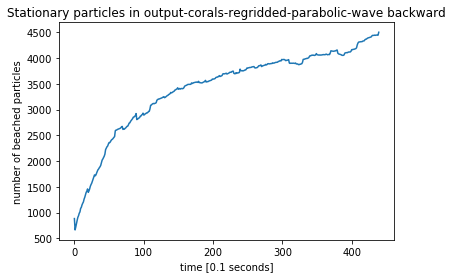

In [14]:
plt.plot(ct[1:])
plt.title('Stationary particles in '+filename+' '+fb)
plt.ylabel('number of beached particles')
plt.xlabel('time [0.1 seconds]')
plt.ylim(bottom=0)
plt.savefig('beached-'+filename+'-'+fb)

Now we want to analyse the time and depth of the outgoing particles. For this we look at each particle and look at the last value before the particle leaves the domain and the values become masked.

In [15]:
zz = np.zeros(len(z))
for i in range(len(zz)):
    zx = z[i][~z[i].mask]
    zz[i] = zx[-1]

In [16]:
tt = []
for i in range(len(t)):
    tx = t[i][~t[i].mask]
    if len(tx)<len(t[0]):
        if fb == 'forward':
            tt += [tx[-1]]
        else:
            tt += [runtime.seconds-tx[-1]]

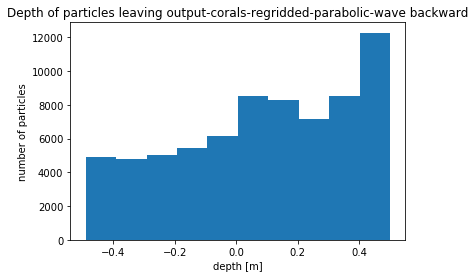

In [17]:
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('depth [m]')
plt.hist(zz)
plt.savefig('depth-'+filename+'-'+fb)

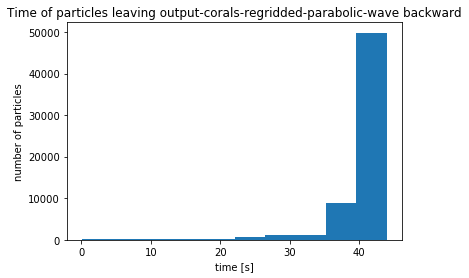

In [18]:
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('time [s]')
plt.hist(tt)
plt.savefig('time-'+filename+'-'+fb)

Finally, we are going to create plots to show the particles, coloured by their initial height.

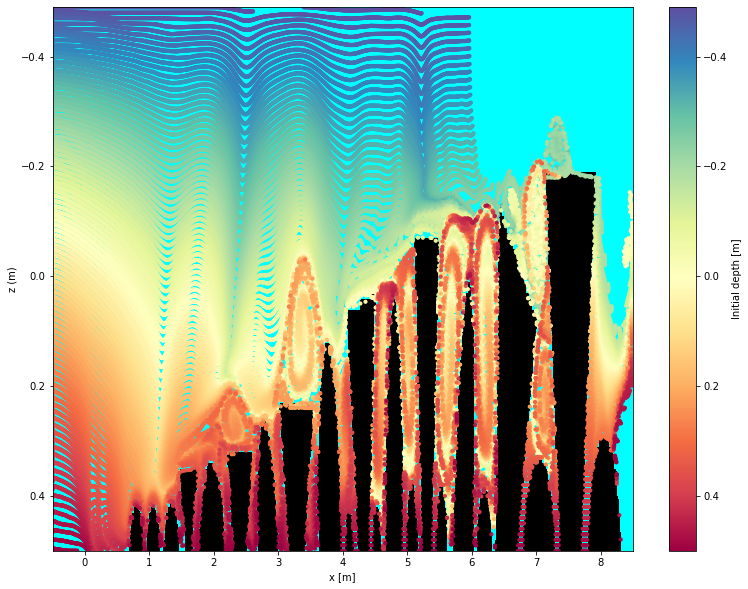

In [19]:
from matplotlib import cm
cstr =cm.get_cmap('Spectral_r')

fig = plt.figure(figsize=(13,10))
ax = plt.axes()
ax.set_facecolor('k')
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap='cool_r')
# for i in range(len(x)):
#     cb = ax.scatter(x[i], z[i], c=len(x[i])*[cstr[int((z[i,0]+0.5)*49)]],s=10, marker="o")
#     c2 = ax.plot(x[i], z[i], c=cstr[int((z[i,0]+0.5)*49)])
#     print(i)
cb = ax.scatter(x[:,10], z[:,10], c=z[:,0],s=10, marker="o",cmap=cstr)
cbar = fig.colorbar(cb,label='Initial depth [m]')
cbar.ax.invert_yaxis()
ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
plt.show()

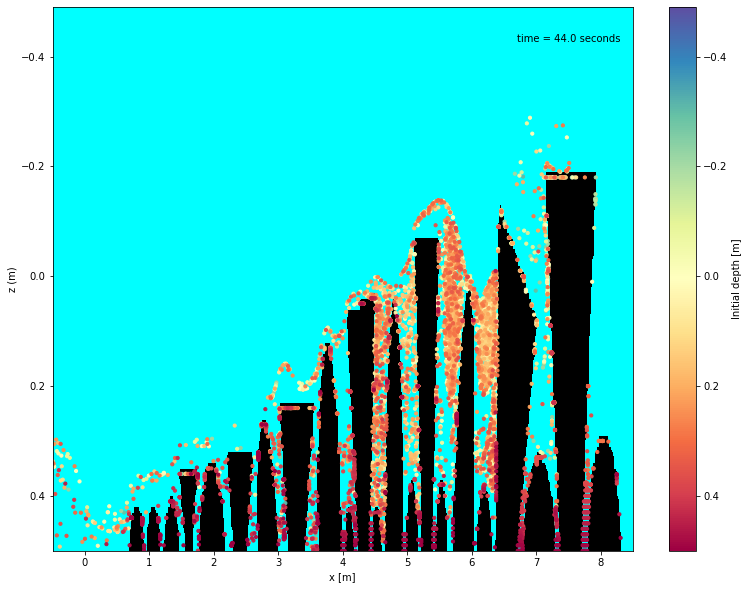

In [20]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
ax.set_facecolor('k')
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap='cool_r')
sc = ax.scatter(x[:,0], z[:,0], c=z[:,0],s=10, marker="o",cmap=cstr)
topleft = 0.05
if fb == 'backward':
    topleft = 0.8
time_text = ax.text(topleft, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
cbar = fig.colorbar(sc,label='Initial depth [m]')
cbar.ax.invert_yaxis()

def animate(i,fig,sc):
    sc.set_offsets(np.c_[x[:,i], z[:,i]])
    ts = i*outputdt.microseconds/1000000
    if fb == 'b':
        ts = ts*-1
    time_text.set_text('time = %.1f seconds' % ts)
    return sc, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc),
                               frames = len(x[0]), blit=True)
anim.save(filename+'-'+str(runtime.seconds)+'-'+fb+'.mp4')
plt.show()